In [1]:
# !git clone https://github.com/elsheikh21/malware-analysis
# !rm -rf sample_data
# !cd malware-analysis

Cloning into 'malware-analysis'...
remote: Enumerating objects: 36106, done.
remote: Counting objects: 100% (36106/36106), done.
remote: Compressing objects: 100% (17624/17624), done.
remote: Total 36106 (delta 18497), reused 36087 (delta 18480), pack-reused 0
Receiving objects: 100% (36106/36106), 23.73 MiB | 17.61 MiB/s, done.
Resolving deltas: 100% (18497/18497), done.
Checking out files: 100% (46492/46492), done.


In [0]:
import pandas as pd
import os
import numpy as np


def read_data():

    print('\nReading data from CSV file...')

    # Read data from file 'sha256_family.csv'
    malwares_path = os.path.join(os.getcwd(), 'malware-analysis', 'drebin', 'sha256_family.csv')
    malwares = pd.read_csv(malwares_path, dtype=str)

    print('Found (' + str(len(malwares.index)) + ') malwares in csv file.')

    print('Reading dataset files...')

    # Read all the files in the feature vector path specified path
    data_path = os.path.join(os.getcwd(), 'malware-analysis', 'drebin', 'feature_vectors')
    features_vector_path = data_path
    dataset_files = os.listdir(features_vector_path)

    dataset_files_length = len(dataset_files)
    print('Found (' + str(dataset_files_length) + ') files to classify.')

    # Separate malwares from non-malwares [Building ground truth arrays]
    malware_files = []
    not_malware_files = []
    for file_name in dataset_files:
        if file_name in (malwares.values[:, 0]):
            malware_files.append(file_name)
        else:
            not_malware_files.append(file_name)

    malware_files_length = len(malware_files)
    not_malware_files_length = len(not_malware_files)
    print('Found (' + str(malware_files_length) + ') malware files.')
    print('Found (' + str(not_malware_files_length) + ') safe files.')

    # Extract features from  dataset files, and label them
    # 1 for malware, 0 otherwise
    # x = {set of features}, y = {0|1}
    x = []
    y = []

    # extract features occurrences in malware files
    for malware_file in malware_files:
        with open(data_path + '/' + malware_file, 'r') as file:
            file_content = file.read().splitlines()
            sample = extract_features(file_content)
            x.append(sample)
            y.append(1)

    # extract features occurrences in safe (non malware) files
    counter = 1  # remove this to work with unbalanced dataset
    for non_malware_file in not_malware_files:
        # remove the following lines to work with unbalanced dataset
        counter += 1
        if(counter == malware_files_length):
            break
        else:
            # remove lines up to here
            with open(data_path + '/' + non_malware_file, 'r') as file:
                file_content = file.read().splitlines()
                sample = extract_features(file_content)
                x.append(sample)
                y.append(0)

    x = np.array(x)
    y = np.array(y)
    print("\nFeatures & Labels arrays' shapes, respectively: " +
          str(x.shape), str(y.shape))
    return x, y

In [32]:
!pip install dask_searchcv

    100% |████████████████████████████████| 40kB 5.3MB/s 


In [0]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score, f1_score, classification_report)
import dask_searchcv as dcv
from dask.diagnostics import ProgressBar
from sklearn.model_selection import ParameterGrid


# Used to print the performance metrices for whatever model invokes this method
def print_metrices_out(y_predicted, y_test):
    print("Accuracy is %f (in percentage)" %
          (accuracy_score(y_test, y_predicted) * 100))
    print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_predicted)))
    print("Recall score is %f." % recall_score(y_test, y_predicted))
    print("Precision score is %f." %
          precision_score(y_test, y_predicted))
    print("F1 score is %f." % f1_score(y_test, y_predicted))
    print("classification Report: \n" +
          str(classification_report(y_test, y_predicted)))
    print("-----------------------------------\n")


# This section contains the fitting of data in the model
# and the prediction of the test data passed to the parameter
# Note that you can add n_jobs=-1 to allow the model to use
# all the preprocessors offered by your pc,
# for example with grid search CV which is known for its
# expensive computations it took 6 mins instead of 15mins
# given same dataset, same PC
def train_svm(x_train, y_train, x_test, y_test):
    print("\n-------------SVM Model-------------")
    model = SVC(gamma='scale')
    # SVM Fit
    model.fit(x_train, y_train)
    # SVM Predict
    y_predicted = model.predict(x_test)
    print("SVM Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_svm_tuning_c_val(x_train, y_train, x_test, y_test, c_value):
    print("-------------SVM, C value Model-------------")
    print("C value: " + str(c_value))
    model = SVC(gamma='scale', C=c_value)
    # SVM Fit
    model.fit(x_train, y_train)
    # SVM Predict
    y_predicted = model.predict(x_test)
    print("SVM, tuned C val Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_recursive_feature_elimination(x_train, y_train, x_test, y_test):
    print("-------------RFE Model-------------")
    model = LogisticRegression(solver='lbfgs')
    rfe = RFE(model, 4)
    # RFE Fit
    rfe.fit(x_train, y_train)
    # RFE Predict
    y_predicted = rfe.predict(x_test)
    print_metrices_out(y_predicted, y_test)


def train_extra_trees(x_train, y_train, x_test, y_test):
    print("-------------Extra Trees Model-------------")
    extra_trees = ExtraTreesClassifier(n_estimators=100)
    # ET Fit
    extra_trees.fit(x_train, y_train)
    # ET Predict
    y_predicted = extra_trees.predict(x_test)
    # ET Matrices
    print("ET Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_extra_trees_n_estimators(x_train, y_train, x_test, y_test,
                                   number_estimators):
    print("-------------Extra Trees Model-------------")
    print("Number of estimators: " + str(number_estimators))
    extra_trees = ExtraTreesClassifier(n_estimators=number_estimators)
    # ET Fit
    extra_trees.fit(x_train, y_train)
    # ET Predict
    y_predicted = extra_trees.predict(x_test)
    # ET Matrices
    print("ET Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_extra_trees_n_jobs(x_train, y_train, x_test, y_test, n_jobs):
    print("-------------Extra Trees Model-------------")
    print("Number of jobs: " + str(n_jobs))
    extra_trees = ExtraTreesClassifier(n_jobs=n_jobs)
    # ET Fit
    extra_trees.fit(x_train, y_train)
    # ET Predict
    y_predicted = extra_trees.predict(x_test)
    # ET Matrices
    print("ET Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_rf(x_train, y_train, x_test, y_test):
    print("-------------RF Model-------------")
    model = RandomForestClassifier(n_estimators=100)
    # RF Fit
    model.fit(x_train, y_train)
    # RF Predict
    y_predicted = model.predict(x_test)
    # RF Matrices
    print("RF Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_rf_number_jobs(x_train, y_train, x_test, y_test, number_of_jobs):
    print("-------------RF Model with nJobs-------------")
    print("N_Jobs: " + str(number_of_jobs))
    model = RandomForestClassifier(n_estimators=100, n_jobs=number_of_jobs)
    # RF Fit
    model.fit(x_train, y_train)
    # RF Predict
    y_predicted = model.predict(x_test)
    # RF Matrices
    print("RF Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_rf_number_jobs_estimators(x_train, y_train, x_test, y_test,
                                    numbers_estimators, number_of_jobs):
    print("-------------RF Model with nJobs-------------")
    print("N_Jobs: " + str(number_of_jobs))
    print("N_Estimators: " + str(numbers_estimators))
    model = RandomForestClassifier(
        n_estimators=numbers_estimators, n_jobs=number_of_jobs)
    # RF Fit
    model.fit(x_train, y_train)
    # RF Predict
    y_predicted = model.predict(x_test)
    # RF Matrices
    print("RF Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_naive_bayes(x_train, y_train, x_test, y_test):
    print("-------------NB Model-------------")
    bern_naive_bayes = BernoulliNB()
    # NB Fit
    bern_naive_bayes.fit(x_train, y_train)
    # NB Predict
    y_predicted = bern_naive_bayes.predict(x_test)
    # NB Matrices
    print("NB Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_grid_search_using_svm(x_train, y_train, x_test, y_test):
    print("-------------GS, SVC Model-------------")
    svc = SVC(gamma="scale")
    parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
    # to print out the number combinatoric product of the different parameters
    # so if you have cv of 5 - as it is the case here -
    # within each grid you will have 5cross validations thus
    # thus we have 20 number of fits
    # to use it uncomment this import sklearn.model_selection
    pg = ParameterGrid(parameters)
    print(len(pg))
    clf = GridSearchCV(svc, parameters, cv=5,
                       refit=True, n_jobs=-1, verbose=1)
    # GS, SVC Fit
    clf.fit(x_train, y_train)
    # GS, SVC Predict
    y_predicted = clf.predict(x_test)
    # GS, SVC Matrices
    print("GS based on SVC model Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)


def train_grid_search_using_rf(x_train, y_train, x_test, y_test):
    print("-------------GS, RF Model-------------")
    param_grid = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['gini', 'entropy']
    }
    clf = dcv.GridSearchCV(estimator=RandomForestClassifier(verbose=3), cv=5,
                           refit=True,
                           param_grid=param_grid,
                           error_score=0)
    # GS, RF Fit
    # use of progress bar to print out "progress"
    # [########################################] | 100% Completed |  4min 11.2s
    # to use it uncomment this import dask.diagnostics
    # with ProgressBar(dt=60.0):
    clf.fit(x_train, y_train)
    # GS, RF Predict
    y_predicted = clf.predict(x_test)
    # GS, RF Matrices
    print("GS based on RF model Evaluation parameters:")
    print_metrices_out(y_predicted, y_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline

def select_features_extra_trees(x, y):
    model = ExtraTreesClassifier(n_estimators=1000)
    model.fit(x, y)

    importances = model.feature_importances_

    indices = np.argsort(importances)[::-1]

    std = np.std([tree.feature_importances_
                  for tree in model.estimators_], axis=0)

    # Print the feature ranking
    print("\nFeature ranking (ordered DESC) using extra trees classifier:")

    for f in range(x.shape[1]):
        print("%d. feature %d (%f)" %
              (f + 1, indices[f], importances[indices[f]]))

    plt.figure()
    plt.title("Features importance due to extra trees classifier")
    plt.bar(range(x.shape[1]), importances[indices],
            color="g", yerr=std[indices], align="center")
    plt.xticks(range(x.shape[1]), indices)
    plt.xlim([-1, x.shape[1]])
    plt.show()


def select_features_random_forest(x, y):
    random_forest_classifier = RandomForestClassifier(
        max_features='sqrt', n_estimators=1000)

    random_forest_classifier.fit(x, y)
    importances = random_forest_classifier.feature_importances_

    indices = np.argsort(importances)[::-1]

    std = np.std([tree.feature_importances_
                  for tree in random_forest_classifier.estimators_], axis=0)

    # Print the feature ranking
    print("\nFeature ranking (ordered DESC) using random forest classifier:")

    for f in range(x.shape[1]):
        print("%d. feature %d (%f)" %
              (f + 1, indices[f], importances[indices[f]]))

    plt.figure()
    plt.title("Features importance due to random forest classifier")
    plt.bar(range(x.shape[1]), importances[indices],
            color="b", yerr=std[indices], align="center")
    plt.xticks(range(x.shape[1]), indices)
    plt.xlim([-1, x.shape[1]])
    plt.show()


def select_features_recursive_feature_elimination(x, y):
    model = LogisticRegression(solver='lbfgs')
    rfe = RFE(model, 4)
    fit = rfe.fit(x, y)
    print('\nRFE chose the the top 4 features: ')
    print('Numbers Features: ' + str(fit.n_features_))
    print('Selected Features: ' + str(fit.support_))
    print('Feature Ranking: ' + str(fit.ranking_))


def select_features_k_best(x, y):
    test = SelectKBest(score_func=chi2, k=4)
    fit = test.fit(x, y)
    # summarize scores
    np.set_printoptions(precision=3)
    print('\nscores for each attribute and the 4 attributes chosen: ')
    print(fit.scores_)
    features = fit.transform(x)
    # summarize selected features
    print(features[0:5, :])

In [0]:
features_set = {
    "feature": 1,
    "permission": 2,
    "activity": 3,
    "service_receiver": 3,
    "provider": 3,
    "service": 3,
    "intent": 4,
    "api_call": 5,
    "real_permission": 6,
    "call": 7,
    "url": 8
}


def extract_features(file_content):
    # list to have the occurrences of each feature in this file,
    # initially filled with zeros
    features_occurrences = {el: 0 for el in range(1, 9)}

    # looping over file content
    for line in file_content:
        # take only lines with set and feature
        # e.g. set is 'url' and feature is 'http://10.0.0.172/'
        # if line != '\n':
        line_set = line.split('::')[0]
        # increment counter for this feature set found
        temp_var = features_set.get(line_set, None)
        if(temp_var is not None):
                features_occurrences[temp_var] += 1

    # returning copy of the features map
    # we created features_occurrences as a dictionary, changing it to a list
    # before returning it
    features = []
    for i in range(1, 9):
        features.append(features_occurrences[i])
    return features


Reading data from CSV file...
Found (5560) malwares in csv file.
Reading dataset files...
Found (46464) files to classify.
Found (2093) malware files.
Found (44371) safe files.

Features & Labels arrays' shapes, respectively: (4184, 8) (4184,)

Features Selection based on KBest: 

scores for each attribute and the 4 attributes chosen: 
[2.991e+02 6.878e+03 4.828e+00 4.671e+02 7.417e+02 8.006e+02 9.290e+02
 8.677e+02]
[[11  6 10 26]
 [25 11  9 89]
 [ 8  5  5 97]
 [11  6 11 26]
 [23  8  5 21]]

Features Selection based on Recursive Features Elimination: 

RFE chose the the top 4 features: 
Numbers Features: 4
Selected Features: [ True  True False False  True  True False False]
Feature Ranking: [1 1 3 5 1 1 2 4]

Features Selection based on Extra trees classifier: 

Feature ranking (ordered DESC) using extra trees classifier:
1. feature 1 (0.274945)
2. feature 7 (0.131037)
3. feature 6 (0.125837)
4. feature 0 (0.112982)
5. feature 2 (0.107908)
6. feature 3 (0.096187)
7. feature 4 (0.0767

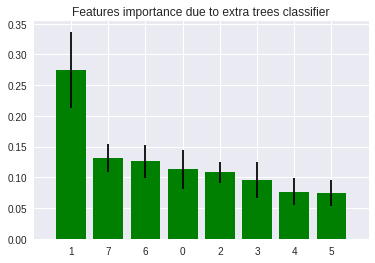


Features Selection based on Random Forest classifier: 

Feature ranking (ordered DESC) using random forest classifier:
1. feature 1 (0.261787)
2. feature 7 (0.147917)
3. feature 2 (0.131897)
4. feature 3 (0.109292)
5. feature 0 (0.108014)
6. feature 6 (0.104769)
7. feature 4 (0.070744)
8. feature 5 (0.065580)


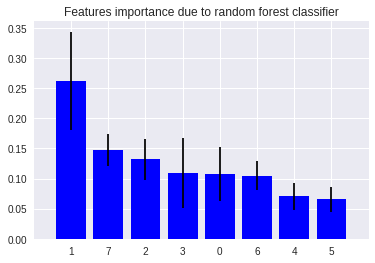


Training data shape (x, y): (4184, 8) (4184,)

Testing data shape (x, y): (837, 8) (837,)

-------------SVM Model-------------
SVM Evaluation parameters:
Accuracy is 85.543608 (in percentage)
Confusion Matrix: 
[[348  42]
 [ 79 368]]
Recall score is 0.823266.
Precision score is 0.897561.
F1 score is 0.858810.
classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       390
           1       0.90      0.82      0.86       447

   micro avg       0.86      0.86      0.86       837
   macro avg       0.86      0.86      0.86       837
weighted avg       0.86      0.86      0.86       837

-----------------------------------

-------------SVM, C value Model-------------
C value: 10
SVM, tuned C val Evaluation parameters:
Accuracy is 87.813620 (in percentage)
Confusion Matrix: 
[[348  42]
 [ 60 387]]
Recall score is 0.865772.
Precision score is 0.902098.
F1 score is 0.883562.
classification Report: 
              precisio

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET Evaluation parameters:
Accuracy is 88.769415 (in percentage)
Confusion Matrix: 
[[352  38]
 [ 56 391]]
Recall score is 0.874720.
Precision score is 0.911422.
F1 score is 0.892694.
classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       390
           1       0.91      0.87      0.89       447

   micro avg       0.89      0.89      0.89       837
   macro avg       0.89      0.89      0.89       837
weighted avg       0.89      0.89      0.89       837

-----------------------------------

-------------Extra Trees Model-------------
Number of jobs: 500


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET Evaluation parameters:
Accuracy is 88.888889 (in percentage)
Confusion Matrix: 
[[354  36]
 [ 57 390]]
Recall score is 0.872483.
Precision score is 0.915493.
F1 score is 0.893471.
classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       390
           1       0.92      0.87      0.89       447

   micro avg       0.89      0.89      0.89       837
   macro avg       0.89      0.89      0.89       837
weighted avg       0.89      0.89      0.89       837

-----------------------------------

-------------RFE Model-------------
Accuracy is 72.998805 (in percentage)
Confusion Matrix: 
[[322  68]
 [158 289]]
Recall score is 0.646532.
Precision score is 0.809524.
F1 score is 0.718905.
classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       390
           1       0.81      0.65      0.72       447

   micro avg       0.73      0.73      0.73     

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200building tree 1 of 200

building tree 2 of 200
building tree 2 of 200
building tree 3 of 200
building tree 3 of 200
building tree 4 of 200
building tree 4 of 200
building tree 5 of 200
building tree 5 of 200
building tree 6 of 200
building tree 6 of 200
building tree 7 of 200
building tree 7 of 200
building tree 8 of 200
building tree 8 of 200
building tree 9 of 200
building tree 9 of 200
building tree 10 of 200
building tree 10 of 200
building tree 11 of 200
building tree 11 of 200
building tree 12 of 200
building tree 12 of 200
building tree 13 of 200
building tree 13 of 200
building tree 14 of 200
building tree 14 of 200
building tree 15 of 200
building tree 15 of 200
building tree 16 of 200
building tree 16 of 200
building tree 17 of 200
building tree 17 of 200
building tree 18 of 200
building tree 18 of 200
building tree 19 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building t

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 1 of 200
building tree 9 of 200
building tree 2 of 200
building tree 10 of 200
building tree 3 of 200
building tree 11 of 200
building tree 4 of 200building tree 12 of 200

building tree 13 of 200
building tree 5 of 200
building tree 14 of 200
building tree 6 of 200
building tree 15 of 200
building tree 7 of 200
building tree 16 of 200
building tree 8 of 200
building tree 17 of 200
building tree 9 of 200
building tree 18 of 200
building tree 10 of 200
building tree 19 of 200
building tree 11 of 200
building tree 20 of 200
building tree 12 of 200
building tree 21 of 200
building tree 13 of 200
building tree 22 of 200
building tree 14 of 200building tree 23 of 200

building tree 15 of 200building tree 24 of 200

building tree 16 of 200
building tree 25 of 200
building tree 26 of 200
building t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 38 of 200
building tree 32 of 200
building tree 39 of 200
building tree 33 of 200
building tree 34 of 200
building tree 40 of 200
building tree 35 of 200
building tree 41 of 200
building tree 36 of 200
building tree 42 of 200building tree 37 of 200

building tree 38 of 200
building tree 43 of 200
building tree 44 of 200
building tree 39 of 200
building tree 45 of 200
building tree 40 of 200
building tree 46 of 200
building tree 41 of 200
building tree 47 of 200
building tree 42 of 200
building tree 48 of 200
building tree 43 of 200building tree 49 of 200

building tree 50 of 200
building tree 44 of 200
building tree 51 of 200
building tree 45 of 200
building tree 52 of 200
building tree 46 of 200
building tree 53 of 200
building tree 47 of 200
building tree 54 of 200
building tree 48 of 200
building tree 55 of 200
building tree 49 of 200
building tree 56 of 200
building tree 50 of 200
building tree 57

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 1 of 500
building tree 10 of 200
building tree 2 of 500
building tree 11 of 200
building tree 3 of 500building tree 12 of 200

building tree 13 of 200
building tree 4 of 500
building tree 14 of 200
building tree 5 of 500
building tree 15 of 200
building tree 6 of 500
building tree 16 of 200
building tree 7 of 500
building tree 17 of 200
building tree 8 of 500
building tree 18 of 200
building tree 9 of 500
building tree 19 of 200
building tree 10 of 500
building tree 20 of 200
building tree 11 of 500
building tree 21 of 200
building tree 12 of 500
building tree 22 of 200
building tree 13 of 500
building tree 23 of 200
building tree 14 of 500
building tree 24 of 200
building tree 15 of 500
building tree 25 of 200
building tree 16 of 500
building tree 26 of 200
building t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 58 of 500
building tree 65 of 200building tree 59 of 500

building tree 66 of 200
building tree 60 of 500building tree 67 of 200

building tree 61 of 500building tree 68 of 200

building tree 62 of 500
building tree 69 of 200
building tree 63 of 500
building tree 70 of 200
building tree 64 of 500
building tree 71 of 200
building tree 65 of 500
building tree 72 of 200
building tree 66 of 500
building tree 67 of 500
building tree 73 of 200
building tree 68 of 500
building tree 74 of 200
building tree 69 of 500building tree 75 of 200

building tree 70 of 500
building tree 76 of 200
building tree 71 of 500
building tree 77 of 200
building tree 72 of 500
building tree 78 of 200
building tree 73 of 500
building tree 79 of 200
building tree 80 of 200
building tree 74 of 500
building tree 81 of 200
building tree 75 of 500
building tree 82 of 200
building tree 76 of 500
building tree 83 of 200
building tree 77 of 500
building tree 84 of 200
building tree 78 of 500
building tree 85

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500
building tree 239 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 329 of 500
building tree 67 of 500building tree 330 of 500

building tree 331 of 500
building tree 68 of 500building tree 332 of 500

building tree 333 of 500
building tree 69 of 500
building tree 334 of 500
building tree 70 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 71 of 500
building tree 338 of 500
building tree 339 of 500
building tree 72 of 500
building tree 340 of 500building tree 73 of 500

building tree 341 of 500
building tree 74 of 500
building tree 342 of 500
building tree 75 of 500
building tree 343 of 500
building tree 76 of 500
building tree 344 of 500
building tree 345 of 500
building tree 77 of 500
building tree 346 of 500
building tree 78 of 500
building tree 347 of 500
building tree 79 of 500
building tree 348 of 500
building tree 80 of 500
building tree 349 of 500
building tree 81 of 500
building tree 350 of 500
building tree 82 of 500
building tree 351 of 500
building tree 83 of 500
building tree 35

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 2 of 500
building tree 398 of 500
building tree 399 of 500
building tree 3 of 500
building tree 400 of 500
building tree 4 of 500
building tree 401 of 500
building tree 5 of 500
building tree 402 of 500
building tree 6 of 500
building tree 403 of 500
building tree 7 of 500
building tree 404 of 500
building tree 8 of 500
building tree 405 of 500
building tree 9 of 500
building tree 10 of 500
building tree 406 of 500
building tree 11 of 500
building tree 407 of 500
building tree 12 of 500
building tree 408 of 500
building tree 13 of 500
building tree 409 of 500
building tree 14 of 500
building tree 410 of 500
building tree 15 of 500
building tree 411 of 500
building tree 16 of 500
building tree 412 of 500
building tree 17 of 500
building tree 413 of 500
building tree 18 of 500
building tree 414 of 500
building tree 19 of 500
building tree 415 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 258 of 500
building tree 259 of 500
building tree 260 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 261 of 500
building tree 262 of 500building tree 2 of 500

building tree 3 of 500
building tree 263 of 500
building tree 4 of 500
building tree 264 of 500
building tree 5 of 500
building tree 265 of 500
building tree 6 of 500
building tree 266 of 500
building tree 7 of 500
building tree 267 of 500
building tree 8 of 500
building tree 268 of 500
building tree 9 of 500
building tree 269 of 500
building tree 10 of 500
building tree 270 of 500
building tree 11 of 500
building tree 271 of 500
building tree 12 of 500
building tree 272 of 500
building tree 13 of 500
building tree 273 of 500
building tree 14 of 500
building tree 274 of 500
building tree 15 of 500
building tree 275 of 500
building tree 16 of 500
building tree 276 of 500
building tree 17 of 500
building tree 277 of 500
building tree 18 of 500
building tree 278 of 500
building tree 19 of 500building tree 279 of 500

building tree 20 of 500
building tree 280 of 500
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 1 of 500
building tree 403 of 500
building tree 2 of 500
building tree 404 of 500
building tree 3 of 500
building tree 405 of 500
building tree 4 of 500building tree 406 of 500

building tree 5 of 500
building tree 407 of 500
building tree 6 of 500
building tree 408 of 500
building tree 7 of 500
building tree 409 of 500
building tree 8 of 500building tree 410 of 500

building tree 411 of 500
building tree 9 of 500
building tree 412 of 500
building tree 10 of 500
building tree 413 of 500
building tree 11 of 500
building tree 414 of 500
building tree 12 of 500
building tree 415 of 500
building tree 13 of 500building tree 416 of 500

building tree 417 of 500
building tree 14 of 500
building tree 418 of 500
building tree 15 of 500
building tree 419 of 500
building tree 16 of 500
building tree 420 of 500
building tree 17 of 500
building tree 421 of 500
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 440 of 500
building tree 42 of 500
building tree 441 of 500
building tree 43 of 500
building tree 442 of 500
building tree 44 of 500
building tree 45 of 500
building tree 443 of 500
building tree 46 of 500
building tree 444 of 500
building tree 47 of 500
building tree 445 of 500
building tree 48 of 500
building tree 446 of 500
building tree 447 of 500
building tree 49 of 500
building tree 448 of 500
building tree 50 of 500
building tree 449 of 500
building tree 51 of 500
building tree 450 of 500
building tree 52 of 500
building tree 53 of 500
building tree 451 of 500
building tree 54 of 500
building tree 452 of 500
building tree 55 of 500building tree 453 of 500

building tree 454 of 500
building tree 56 of 500
building tree 455 of 500
building tree 57 of 500
building tree 456 of 500
building tree 457 of 500
building tree 58 of 500
building tree 458 of 500
building tree 59 of 500
building tree 459 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 26 of 200
building tree 27 of 200
building tree 28 of 200

building tree 276 of 500
building tree 29 of 200
building tree 30 of 200
building tree 277 of 500
building tree 31 of 200
building tree 278 of 500
building tree 32 of 200building tree 279 of 500

building tree 33 of 200
building tree 280 of 500
building tree 34 of 200
building tree 281 of 500
building tree 35 of 200
building tree 282 of 500
building tree 36 of 200
building tree 283 of 500
building tree 37 of 200
building tree 284 of 500
building tree 285 of 500
building tree 38 of 200
building tree 286 of 500building tree 39 of 200

building tree 287 of 500
building tree 40 of 200
building tree 288 of 500
building tree 41 of 200
building tree 289 of 500
building tree 42 of 200
building tree 290 of 500
building tree 43 of 200
building tree 291 of 500
building tree 44 of 200
building tree 292 of 500
building tree 45 of 200
building tree 293 of 500
building tree 46 of 200
building tree 294 of 500
building tree 47 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500
building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 172 of 200
building tree 32 of 200
building tree 173 of 200
building tree 33 of 200
building tree 174 of 200
building tree 34 of 200
building tree 175 of 200
building tree 35 of 200
building tree 176 of 200
building tree 36 of 200
building tree 37 of 200
building tree 177 of 200
building tree 38 of 200
building tree 178 of 200
building tree 39 of 200building tree 179 of 200

building tree 180 of 200
building tree 40 of 200
building tree 181 of 200
building tree 41 of 200
building tree 182 of 200
building tree 42 of 200
building tree 183 of 200
building tree 43 of 200
building tree 184 of 200
building tree 44 of 200
building tree 185 of 200
building tree 45 of 200
building tree 46 of 200
building tree 186 of 200
building tree 47 of 200
building tree 187 of 200
building tree 48 of 200
building tree 188 of 200
building tree 49 of 200
building tree 189 of 200
building tree 50 of 200
building tree 190 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 1 of 200
building tree 129 of 200
building tree 2 of 200building tree 130 of 200



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 131 of 200building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 132 of 200
building tree 6 of 200
building tree 7 of 200
building tree 133 of 200
building tree 8 of 200
building tree 134 of 200
building tree 9 of 200
building tree 135 of 200
building tree 10 of 200
building tree 136 of 200
building tree 11 of 200
building tree 137 of 200
building tree 12 of 200
building tree 138 of 200
building tree 13 of 200
building tree 139 of 200
building tree 14 of 200
building tree 140 of 200
building tree 15 of 200
building tree 141 of 200
building tree 16 of 200
building tree 142 of 200
building tree 17 of 200
building tree 143 of 200
building tree 18 of 200
building tree 144 of 200
building tree 19 of 200
building tree 145 of 200
building tree 20 of 200
building tree 146 of 200
building tree 21 of 200
building tree 147 of 200
building tree 22 of 200
building tree 148 of 200
building tree 23 of 200
building tree 149 of 200
building tree 24 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished




building tree 72 of 200building tree 200 of 200

building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 50 of 200
building tree 51 of 200
building tree 189 of 200building tree 52 of 200

building tree 53 of 200
building tree 190 of 200
building tree 54 of 200building tree 191 of 200

building tree 55 of 200
building tree 192 of 200
building tree 56 of 200building tree 193 of 200

building tree 194 of 200
building tree 57 of 200
building tree 195 of 200
building tree 58 of 200
building tree 196 of 200
building tree 59 of 200
building tree 197 of 200
building tree 60 of 200building tree 198 of 200

building tree 61 of 200building tree 199 of 200

building tree 62 of 200
building tree 200 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 1 of 500
building tree 128 of 200
building tree 2 of 500building tree 129 of 200

building tree 130 of 200
building tree 3 of 500
building tree 131 of 200
building tree 4 of 500
building tree 132 of 200
building tree 5 of 500
building tree 133 of 200
building tree 6 of 500
building tree 134 of 200
building tree 7 of 500
building tree 135 of 200
building tree 8 of 500
building tree 136 of 200
building tree 9 of 500
building tree 137 of 200
building tree 10 of 500
building tree 138 of 200
building tree 11 of 500
building tree 139 of 200
building tree 12 of 500
building tree 13 of 500building tree 140 of 200

building tree 141 of 200
building tree 14 of 5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 49 of 500
building tree 50 of 500
building tree 175 of 200
building tree 51 of 500
building tree 176 of 200building tree 52 of 500

building tree 53 of 500
building tree 177 of 200
building tree 54 of 500
building tree 178 of 200
building tree 55 of 500
building tree 179 of 200
building tree 56 of 500building tree 180 of 200

building tree 181 of 200
building tree 57 of 500
building tree 182 of 200
building tree 58 of 500
building tree 183 of 200
building tree 59 of 500
building tree 184 of 200
building tree 60 of 500
building tree 185 of 200
building tree 61 of 500
building tree 186 of 200
building tree 62 of 500
building tree 187 of 200
building tree 63 of 500
building tree 188 of 200
building tree 64 of 500
building tree 189 of 200
building tree 65 of 500
building tree 190 of 200
building tree 66 of 500
building tree 191 of 200
building tree 67 of 500
building tree 192 of 200
building tree 68 of 500
building tree 193 of 200
building tree 69 of 500
building tree 194 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 1 of 500
building tree 147 of 500
building tree 2 of 500
building tree 148 of 500building tree 3 of 500

building tree 4 of 500
building tree 149 of 500
building tree 5 of 500
building tree 150 of 500
building t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 34 of 500
building tree 179 of 500
building tree 35 of 500
building tree 180 of 500
building tree 36 of 500
building tree 181 of 500
building tree 37 of 500
building tree 182 of 500
building tree 38 of 500
building tree 183 of 500
building tree 39 of 500
building tree 184 of 500
building tree 185 of 500
building tree 40 of 500
building tree 41 of 500
building tree 186 of 500
building tree 42 of 500
building tree 187 of 500
building tree 43 of 500
building tree 188 of 500
building tree 44 of 500
building tree 189 of 500
building tree 45 of 500
building tree 190 of 500
building tree 191 of 500
building tree 46 of 500
building tree 192 of 500
building tree 47 of 500
building tree 193 of 500
building tree 48 of 500
building tree 49 of 500
building tree 194 of 500
building tree 50 of 500
building tree 195 of 500
building tree 51 of 500
building tree 196 of 500
building tree 52 of 500
building tree 197 of 500
building tree 53 of 500
building tree 198 of 500
building tree 54 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 499 of 500
building tree 500 of 500
building tree 1 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 164 of 500
building tree 165 of 500
building tree 1 of 500
building tree 166 of 500
building tree 2 of 500
building tree 167 of 500
building tree 3 of 500building tree 168 of 500

building tree 4 of 500
building tree 169 of 500
building tree 5 of 500
building tree 170 of 500
building tree 6 of 500
building tree 171 of 500
building tree 7 of 500
building tree 172 of 500
building tree 173 of 500building tree 8 of 500

building tree 174 of 500building tree 9 of 500

building tree 10 of 500building tree 175 of 500

building tree 11 of 500
building tree 176 of 500
building tree 12 of 500building tree 177 of 500

building tree 13 of 500
building tree 178 of 500
building tree 14 of 500
building tree 179 of 500
building tree 180 of 500
building tree 15 of 500
building tree 181 of 500
building tree 16 of 500
building tree 182 of 500
building tree 17 of 500
building tree 183 of 500
building tree 18 of 500
building tree 184 of 500
building tree 185 of 500building tree 19 of 500

bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 36 of 500
building tree 37 of 500
building tree 202 of 500
building tree 38 of 500
building tree 203 of 500
building tree 39 of 500building tree 204 of 500

building tree 40 of 500
building tree 205 of 500
building tree 41 of 500
building tree 206 of 500
building tree 207 of 500
building tree 42 of 500
building tree 208 of 500
building tree 43 of 500
building tree 209 of 500
building tree 44 of 500
building tree 210 of 500
building tree 45 of 500
building tree 211 of 500
building tree 46 of 500
building tree 212 of 500
building tree 47 of 500
building tree 213 of 500
building tree 48 of 500
building tree 214 of 500
building tree 49 of 500
building tree 215 of 500
building tree 50 of 500
building tree 216 of 500
building tree 51 of 500
building tree 217 of 500
building tree 52 of 500
building tree 218 of 500
building tree 53 of 500
building tree 219 of 500
building tree 54 of 500
building tree 220 of 500
building tree 55 of 500
building tree 221 of 500
building tree 56 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 1 of 500
building tree 499 of 500
building tree 2 of 500
building tree 500 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 6

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 22 of 200
building tree 188 of 500
building tree 23 of 200
building tree 189 of 500
building tree 24 of 200
building tree 190 of 500
building tree 25 of 200
building tree 191 of 500
building tree 26 of 200
building tree 192 of 500
building tree 27 of 200
building tree 193 of 500
building tree 28 of 200building tree 194 of 500

building tree 195 of 500
building tree 29 of 200
building tree 196 of 500
building tree 30 of 200
building tree 197 of 500
building tree 198 of 500
building tree 31 of 200
building tree 199 of 500
building tree 32 of 200
building tree 200 of 500building tree 33 of 200

building tree 201 of 500
building tree 34 of 200
building tree 202 of 500
building tree 35 of 200building tree 203 of 500

building tree 204 of 500
building tree 36 of 200
building tree 205 of 500
building tree 37 of 200
building tree 206 of 500
building tree 38 of 200
building tree 207 of 500
building tree 39 of 200building tree 208 of 500

building tree 40 of 200building tree 209 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 177 of 200building tree 1 of 200

building tree 178 of 200
building tree 2 of 200
building tree 179 of 200
building tree 3 of 200
building tree 180 of 200
building tree 4 of 200
building tree 181 of 200
building tree 5 of 200
building tree 182 of 200
building tree 183 of 200
building tree 6 of 200
building tree 184 of 200
building tree 7 of 200
building tree 185 of 200
building tree 8 of 200building tree 186 of 200

building tree 9 of 200
building tree 187 of 200
building tree 10 of 200building tree 188 of 200

building tree 11 of 200
building tree 189 of 200
building tree 12 of 200
building tree 190 of 200
building tree 13 of 200
building tree 191 of 200
building tree 14 of 200
building tree 192 of 200
building tree 15 of 200
building tree 193 of 200
building tree 16 of 200
building tree 194 of 200
building tree 17 of 200
building tree 195 of 200
building tree 18 of 200
building tree 196 of 200
building tree 19 of 200
building tree 197 of 200
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 1 of 200
building tree 2 of 200
building tree 79 of 200
building tree 3 of 200
building tree 80 of 200
building tree 4 of 200
building tree 5 of 200
building tree 81 of 200
building tree 6 of 200
building tree 82 of 200
building tree 7 of 200
building tree 83 of 200
building tree 8 of 200
building tree 84 of 200
building tree 9 of 200
building tree 85 of 200
building tree 10 of 200
building tree 86 of 200
building tree 11 of 200
building tree 87 of 200
building tree 12 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 13 of 200
building tree 88 of 200
building tree 14 of 200
building tree 89 of 200
building tree 15 of 200
building tree 90 of 200
building tree 16 of 200
building tree 91 of 200
building tree 17 of 200
building tree 92 of 200
building tree 18 of 200
building tree 93 of 200
building tree 19 of 200
building tree 94 of 200building tree 20 of 200

building tree 21 of 200building tree 95 of 200

building tree 96 of 200
building tree 22 of 200
building tree 97 of 200
building tree 23 of 200
building tree 98 of 200
building tree 24 of 200
building tree 99 of 200
building tree 25 of 200
building tree 100 of 200
building tree 26 of 200
building tree 27 of 200
building tree 101 of 200
building tree 28 of 200
building tree 102 of 200
building tree 103 of 200
building tree 29 of 200
building tree 104 of 200
building tree 30 of 200
building tree 105 of 200
building tree 31 of 200
building tree 106 of 200
building tree 32 of 200
building tree 107 of 200
building tree 33 of 200
building

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 185 of 200
building tree 2 of 200building tree 186 of 200

building tree 187 of 200
building tree 3 of 200
building tree 4 of 200
building tree 188 of 200building tree 5 of 200

building tree 189 of 200
building tree 6 of 200
building tree 190 of 200
building tree 7 of 200
building tree 191 of 200
building tree 8 of 200
building tree 192 of 200
building tree 9 of 200
building tree 193 of 200
building tree 10 of 200
building tree 194 of 200
building tree 11 of 200
building tree 195 of 200
building tree 12 of 200
building tree 196 of 200
building tree 13 of 200
building tree 14 of 200
building tree 197 of 200
building tree 15 of 200
building tree 198 of 200
building tree 16 of 200
building tree 199 of 200
building tree 17 of 200
building tree 200 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 1 of 500
building tree 81 of 200
building tree 2 of 500
building tree 82 of 200
building tree 3 of 500
building tree 83 of 200
building tree 4 of 500
building tree 84 of 200
building tree 5 of 500
building tree 85 of 200
building tree 6 of 500
building tree 86 of 200
building tree 7 of 500
building tree 87 of 200
building tree 8 of 500
building tree 88 of 200building tree 9 of 500

building tree 10 of 500
building tree 89 of 200
building tree 11 of 500
building tree 90 of 200
building tree 12 of 500
building tree 91 of 200
building tree 13 of 500
building tree 14 of 500
building tree 92 of 200
building tree 15 of 500
building tree 93 of 200
building tree 16 of 500
building tree 94 of 200
building tree 17 of 500
building tree 95 of 200
building tree 18 of 500
building tree 96 of 200
building tree 19 of 500
building tree 97 of 200
building tree 20 of 500
building tree 98 of 200
building tree 21 of 500
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200

building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 45 of 500
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200building tree 46 of 500

building tree 47 of 500
building tree 133 of 200
building tree 48 of 500building tree 134 of 200

building tree 49 of 500
building tree 135 of 200
building tree 50 of 500
building tree 136 of 200
building tree 51 of 500
building tree 137 of 200
building tree 52 of 500
building tree 138 of 200
building tree 53 of 500
building tree 139 of 200
building tree 54 of 500
building tree 140 of 200
building tree 55 of 500
building tree 141 of 200
building tree 56 of 500
building tree 142 of 200
building tree 57 of 500
building tree 143 of 200
building tree 58 of 500
building tree 144 of 200
building tree 59 of 500
building tree 60 of 500building tree 14

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 1 of 500
building tree 173 of 500
building tree 2 of 500
building tree 174 of 500
building tree 3 of 500
building tree 175 of 500
building tree 4 of 500
building tree 176 of 500
building tree 5 of 500
building tree 177 of 500
building tree 6 of 500
building tree 178 of 500
building tree 7 of 500
building tree 179 of 500
building tree 8 of 500
building tree 180 of 500
building tree 9 of 500
building tree 181 of 500
building tree 10 of 500
building tree 182 of 500building tree 11 of 500

building tree 12 of 500
building tree 183 of 500
building tree 13 of 500
building tree 184 of 500
building tree 14 of 500
building tree 185 of 500
building tree 15 of 500
building tree 186 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 52 of 500
building tree 53 of 500
building tree 222 of 500
building tree 54 of 500
building tree 223 of 500
building tree 55 of 500
building tree 224 of 500
building tree 56 of 500
building tree 225 of 500
building tree 57 of 500
building tree 226 of 500
building tree 58 of 500
building tree 227 of 500
building tree 59 of 500
building tree 228 of 500
building tree 60 of 500
building tree 229 of 500
building tree 61 of 500
building tree 62 of 500
building tree 230 of 500
building tree 63 of 500
building tree 231 of 500
building tree 64 of 500
building tree 232 of 500
building tree 65 of 500
building tree 233 of 500
building tree 66 of 500
building tree 234 of 500
building tree 67 of 500
building tree 235 of 500
building tree 68 of 500
building tree 236 of 500
building tree 69 of 500
building tree 237 of 500
building tree 70 of 500building tree 238 of 500

building tree 239 of 500
building tree 71 of 500
building tree 240 of 500
building tree 241 of 500
building tree 72 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 1 of 500
building tree 473 of 500
building tree 2 of 500
building tree 474 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 475 of 500
building tree 7 of 500building tree 476 of 500

building tree 477 of 500
building tree 8 of 500
building tree 9 of 500
building tree 478 of 500
building tree 10 of 500
building tree 479 of 500
building tree 11 of 500
building tree 480 of 500
building tree 12 of 500
building tree 481 of 500
building tree 13 of 500
building tree 482 of 500
building tree 14 of 500
building tree 483 of 500building tree 15 of 500

building tree 16 of 500
building tree 484 of 500
building tree 17 of 500
building tree 485 of 500
building tree 486 of 500
building tree 18 of 500
building tree 487 of 500
building tree 19 of 500
building tree 488 of 500
building tree 20 of 500building tree 489 of 500

buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 495 of 500building tree 25 of 500

building tree 26 of 500
building tree 496 of 500
building tree 497 of 500building tree 27 of 500

building tree 498 of 500building tree 28 of 500

building tree 29 of 500
building tree 499 of 500
building tree 30 of 500
building tree 500 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building t

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 1 of 500
building tree 176 of 500
building tree 2 of 500
building tree 177 of 500
building tree 178 of 500
building tree 3 of 500
building tree 179 of 500
building tree 4 of 500
building tree 180 of 500
building tree 5 of 500
building tree 181 of 500
building tree 6 of 500
building tree 182 of 500
building tree 7 of 500
building tree 183 of 500
building tree 8 of 500
building tree 184 of 500
building tree 9 of 500
building tree 185 of 500building tree 10 of 500

building tree 11 of 500
building tree 186 of 500
building tree 12 of 500
building tree 187 of 500
building tree 13 of 500
building tree 188 of 500
building tree 14 of 500
building tree 189 of 500
building tree 15 of 500
building tree 190 of 500
building tree 16 of 500
building tree 191 of 500
building tree 17 of 500
building tree 192 of 500
building tree 18 of 500
building tree 193 of 500
building tree 19 of 500
building tree 194 of 500
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 38 of 500
building tree 212 of 500building tree 39 of 500

building tree 213 of 500
building tree 40 of 500
building tree 214 of 500
building tree 41 of 500
building tree 215 of 500
building tree 42 of 500
building tree 216 of 500
building tree 43 of 500
building tree 217 of 500
building tree 44 of 500
building tree 218 of 500
building tree 45 of 500
building tree 219 of 500
building tree 46 of 500
building tree 220 of 500
building tree 47 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 48 of 500
building tree 224 of 500
building tree 49 of 500
building tree 225 of 500
building tree 50 of 500
building tree 226 of 500
building tree 51 of 500
building tree 227 of 500
building tree 52 of 500
building tree 228 of 500
building tree 53 of 500
building tree 229 of 500
building tree 54 of 500
building tree 230 of 500
building tree 55 of 500
building tree 231 of 500
building tree 56 of 500
building tree 232 of 500
building tree 57 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 1 of 500
building tree 456 of 500
building tree 2 of 500
building tree 3 of 500
building tree 457 of 500
building tree 4 of 500
building tree 458 of 500
building tree 5 of 500
building tree 459 of 500
building tree 6 of 500
building tree 460 of 500
building tree 7 of 500
building tree 461 of 500
building tree 8 of 500
building tree 462 of 500
building tree 9 of 500
building tree 10 of 500
building tree 463 of 500
building tree 11 of 500
building tree 464 of 500
building tree 12 of 500
building tree 465 of 500
building tree 466 of 500
building tree 13 of 500
building tree 467 of 500
building tree 14 of 500
building tree 468 of 500
building tree 15 of 500
building tree 469 of 500
building tree 16 of 500
building tree 17 of 500
building tree 470 of 500
building tree 471 of 500
building tree 18 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 19 of 500
building tree 20 of 500
building tree 472 of 500
building tree 21 of 500
building tree 473 of 500
building tree 22 of 500
building tree 474 of 500
building tree 23 of 500
building tree 475 of 500
building tree 24 of 500
building tree 476 of 500
building tree 25 of 500
building tree 477 of 500
building tree 26 of 500
building tree 478 of 500
building tree 27 of 500
building tree 479 of 500
building tree 28 of 500
building tree 480 of 500
building tree 29 of 500
building tree 30 of 500building tree 481 of 500

building tree 482 of 500
building tree 31 of 500
building tree 483 of 500
building tree 32 of 500
building tree 33 of 500
building tree 484 of 500
building tree 34 of 500
building tree 485 of 500
building tree 35 of 500
building tree 486 of 500building tree 36 of 500

building tree 487 of 500building tree 37 of 500

building tree 488 of 500
building tree 38 of 500
building tree 489 of 500
building tree 39 of 500
building tree 490 of 500
building tree 40 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 1 of 200
building tree 189 of 500
building tree 2 of 200
building tree 190 of 500
building tree 3 of 200
building tree 191 of 500
building tree 4 of 200
building tree 192 of 500
building tree 5 of 200
building tree 193 of 500
building tree 6 of 200
building tree 194 of 500
building tree 7 of 200
building tree 195 of 500
building tree 8 of 200
building tree 196 of 500
building tree 9 of 200
building tree 197 of 500
building tree 10 of 200
building tree 198 of 500
building tree 11 of 200
building tree 199 of 500
building tree 12 of 200
building tree 200 of 500
building tree 13 of 200
building tree 201 of 500building tree 14 of 200

building tree 15 of 200
building tree 202 of 500
building tree 16 of 200
building tree 203 of 500
building tree 17 of 200
building tree 204 of 500building tree 18 of 200

building tree 19 of 200
building tree 205 of 500
building tree 20 of 200
building tree 206 of 500
building tree 21 of 200
building tree 207 of 500
building tree 22 of 200
build

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 1 of 200
building tree 441 of 500
building tree 2 of 200
building tree 442 of 500
building tree 3 of 200
building tree 443 of 500building tree 4 of 200

building tree 444 of 500
building tree 5 of 200
building tree 445 of 500
building tree 6 of 200
building tree 446 of 500
building tree 7 of 200
building tree 447 of 500
building tree 8 of 200
building tree 448 of 500
building tree 9 of 200
building tree 449 of 500
building tree 10 of 200
building tree 450 of 500
building tree 11 of 200
building tree 451 of 500
building tree 12 of 200
building tree 452 of 500
building tree 13 of 200
building tree 453 of 500
building tree 14 of 200
building tree 454 of 500
building tree 15 of 200
building tree 455 of 500
building tree 16 of 200
building tree 456 of 500
building tree 17 of 200
building tree 457 of 500bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200building tree 468 of 500

building tree 469 of 500
building tree 32 of 200
building tree 470 of 500
building tree 33 of 200
building tree 471 of 500
building tree 34 of 200
building tree 472 of 500
building tree 35 of 200
building tree 473 of 500building tree 36 of 200

building tree 37 of 200
building tree 474 of 500building tree 38 of 200

building tree 475 of 500building tree 39 of 200

building tree 476 of 500
building tree 40 of 200
building tree 477 of 500
building tree 41 of 200
building tree 478 of 500
building tree 42 of 200
building tree 479 of 500
building tree 43 of 200
building tree 480 of 500
building tree 44 of 200
building tree 481 of 500building tree 45 of 200

building tree 46 of 200
building tree 482 of 500
building tree 47 of 200
building tree 483 of 500
building tree 48 of 200
building tree 484 of 500
building tree 49 of 200
building tree 485 of 500
building tree 50 of 200
building tree 486 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 52 of 200
building tree 2 of 200
building tree 53 of 200
building tree 3 of 200
building tree 54 of 200
building tree 4 of 200
building tree 55 of 200
building tree 5 of 200building tree 56 of 200

building tree 6 of 200
building tree 57 of 200
building tree 7 of 200
building tree 58 of 200
building tree 8 of 200
building tree 59 of 200
building tree 9 of 200
building tree 60 of 200
building tree 10 of 200
building tree 61 of 200
building tree 11 of 200
building tree 62 of 200
building tree 12 of 200
building tree 63 of 200
building tree 13 of 200
building tree 64 of 200
building tree 14 of 200
building tree 65 of 200
building tree 15 of 200
building tree 66 of 200
building tree 16 of 200
building tree 67 of 200
building tree 17 of 200
building tree 68 of 200
building tree 18 of 200
building tree 69 of 200
building tree 19 of 200
building tree 70 of 200
building tree 20 of 200
building tree 71 of 200
building tree 21 of 200
building tree 72 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200
building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 1 of 500
building tree 67 of 200
building tree 2 of 500
building tree 68 of 200
building tree 3 of 500building tree 69 of 200

building tree 70 of 200
building tree 4 of 500
building tree 5 of 500
building tree 71 of 200
building tree 6 of 500
building tree 72 of 200
building tree 7 of 500
building tree 73 of 200
building tree 8 of 500
building tree 74 of 200
building tree 9 of 500
building tree 75 of 200
building tree 10 of 500
building tree 76 of 200
building tree 11 of 500
building tree 77 of 200
building tree 12 of 500
building tree 13 of 500
building tree 78 of 200
building tree 14 of 500
building tree 79 of 200
building tree 15 of 500
building tree 80 of 200
building tree 16 of 500
building tree 81 of 200
building tree 17 of 500
building tree 82 of 200
building tree 18 of 500
building tree 83 of 200
building tree 19 of 500
building tree 84 of 200
building tree 20 of 500
building tree 85 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 35 of 500
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200building tree 36 of 500

building tree 37 of 500
building tree 103 of 200
building tree 38 of 500
building tree 104 of 200
building tree 39 of 500
building tree 105 of 200
building tree 40 of 500
building tree 106 of 200
building tree 41 of 500
building tree 107 of 200
building tree 42 of 500
building tree 108 of 200
building tree 43 of 500
building tree 109 of 200
building tree 44 of 500
building tree 110 of 200
building tree 45 of 500
building tree 111 of 200
building tree 46 of 500
building tree 112 of 200
building tree 47 of 500
building tree 113 of 200
building tree 48 of 500
building tree 114 of 200
building tree 49 of 500
building tree 115 of 200building tree 50 of 500

building tree 51 of 500building tree 116 of 200

building tree 117 of 200
building tree 52 of 500
building tree 118 of 200
building tree 53 of 500
building tree 119 of 200
building tree 54 of 500
building tree 120 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 1 of 500
building tree 205 of 500
building tree 2 of 500
building tree 206 of 500
building tree 3 of 500
building tree 207 of 500
building tree 4 of 500
building tree 208 of 500
building tree 5 of 500
building tree 209 of 500
building tree 6 of 500
building tree 210 of 500
building tree 7 of 500
building tree 211 of 500
building tree 8 of 500
building tree 212 of 500
building tree 9 of 500
building tree 213 of 500
building tree 10 of 500
building tree 214 of 500
building tree 11 of 500
building tree 215 of 500
building tree 12 of 500
building tree 216 of 500
building tree 13 of 500
building tree 217 of 500
building tree 14 of 500
building tree 218 of 500
building tree 15 of 500
building tree 219 of 500
building tree 16 of 500
building tree 220 of 500
building tree 17 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 18 of 500
building tree 19 of 500
building tree 221 of 500
building tree 20 of 500
building tree 222 of 500
building tree 21 of 500
building tree 223 of 500
building tree 22 of 500
building tree 224 of 500
building tree 23 of 500
building tree 225 of 500
building tree 24 of 500
building tree 226 of 500
building tree 25 of 500
building tree 227 of 500
building tree 26 of 500
building tree 228 of 500
building tree 27 of 500
building tree 229 of 500
building tree 28 of 500
building tree 230 of 500
building tree 29 of 500
building tree 231 of 500
building tree 30 of 500
building tree 232 of 500
building tree 31 of 500
building tree 233 of 500
building tree 32 of 500
building tree 234 of 500
building tree 33 of 500
building tree 235 of 500
building tree 34 of 500
building tree 236 of 500
building tree 35 of 500
building tree 237 of 500
building tree 36 of 500
building tree 238 of 500
building tree 239 of 500
building tree 37 of 500
building tree 240 of 500building tree 38 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished



building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 1 of 500
building tree 453 of 500
building tree 2 of 500
building tree 454 of 500
building tree 3 of 500
building tree 455 of 500
building tree 4 of 500
building tree 456 of 500
building tree 5 of 500
building tree 457 of 500
building tree 6 of 500
building tree 458 of 500
building tree 7 of 500
building tree 459 of 500
building tree 8 of 500
building tree 460 of 500
building tree 9 of 500
building tree 461 of 500
building tree 10 of 500
building tree 462 of 500
building tree 11 of 500
building tree 463 of 500building tree 12 of 500

building tree 13 of 500
building tree 464 of 500
building tree 14 of 500
building tree 465 of 500
building tree 15 of 500
building tree 466 of 500
building tree 16 of 500
building tree 467 of 500
building tree 17 of 500
building tree 468 of 500
building tree 18 of 500
building tree 469 of 500
building tree 19 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 9

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 1 of 500
building tree 199 of 500
building tree 2 of 500
building tree 200 of 500
building tree 3 of 500
building tree 201 of 500
building tree 4 of 500
building tree 202 of 500
building tree 5 of 500
building tree 203 of 500
building tree 6 of 500
building tree 204 of 500
building tree 7 of 500
building tree 205 of 500
building tree 8 of 500building tree 206 of 500

building tree 9 of 500building tree 207 of 500

building tree 10 of 500
building tree 208 of 500
building tree 11 of 500
building tree 209 of 500
building tree 210 of 500building tree 12 of 500

building tree 13 of 500building tree 211 of 500

building tree 14 of 500
building tree 212 of 500
building tree 15 of 500
building tree 213 of 500
building tree 16 of 500
building tree 214 of 500
building tree 17 of 500
building tree 215 of 500
building tree 18 of 500
building tree 216 of 500
building tree 19 of 500
building tree 217 of 500
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 24 of 500
building tree 222 of 500
building tree 25 of 500
building tree 223 of 500
building tree 26 of 500
building tree 224 of 500
building tree 27 of 500
building tree 225 of 500
building tree 28 of 500
building tree 226 of 500
building tree 29 of 500
building tree 227 of 500
building tree 30 of 500
building tree 228 of 500
building tree 31 of 500
building tree 229 of 500
building tree 32 of 500
building tree 230 of 500
building tree 33 of 500
building tree 231 of 500building tree 34 of 500

building tree 35 of 500
building tree 232 of 500
building tree 233 of 500
building tree 36 of 500
building tree 234 of 500
building tree 37 of 500
building tree 235 of 500
building tree 38 of 500
building tree 236 of 500
building tree 39 of 500
building tree 40 of 500
building tree 237 of 500
building tree 41 of 500
building tree 42 of 500
building tree 238 of 500
building tree 43 of 500
building tree 239 of 500
building tree 44 of 500
building tree 45 of 500building tree 240 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 1 of 500
building tree 464 of 500
building tree 2 of 500
building tree 465 of 500
building tree 3 of 500
building tree 466 of 500
building tree 4 of 500
building tree 467 of 500
building tree 5 of 500building tree 468 of 500

building tree 6 of 500building tree 469 of 500

building tree 470 of 500
building tree 7 of 500
building tree 471 of 500
building tree 8 of 500
building tree 472 of 500building tree 9 of 500

building tree 10 of 500
building tree 473 of 500
building tree 11 of 500
building tree 474 of 500
building tree 12 of 500
building tree 475 of 500
building tree 13 of 500
building tree 476 of 500
building tree 14 of 500
building tree 477 of 500
building tree 15 of 500
building tree 478 of 500
building tree 16 of 500
building tree 479 of 500
building tree 17 of 500
building tree 480 of 500
building tree 18 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 215 of 500

building tree 216 of 500
building tree 30 of 200
building tree 217 of 500
building tree 218 of 500
building tree 31 of 200building tree 219 of 500

building tree 220 of 500
building tree 32 of 200
building tree 221 of 500
building tree 33 of 200
building tree 222 of 500
building tree 34 of 200
building tree 223 of 500
building tree 35 of 200
building tree 224 of 500
building tree 225 of 500
building tree 36 of 200
building tree 226 of 500building tree 37 of 200

building tree 38 of 200
building tree 227 of 500
building tree 39 of 200
building tree 228 of 500
building tree 40 of 200
building tree 229 of 500
building tree 41 of 200
building tree 230 of 500
building tree 42 of 200
building tree 231 of 500
building tree 43 of 200
building tree 232 of 500
building tree 44 of 200
building tree 233 of 500
building tree 45 of 200
building tree 234 of 500
building tree 46 of 200
building tree 235 of 500
building tree 47 of 200
building tree 236 of 500
building tree 48 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 446 of 500
building tree 1 of 200
building tree 447 of 500
building tree 2 of 200
building tree 448 of 500
building tree 3 of 200
building tree 449 of 500
building tree 4 of 200building tree 450 of 500

building tree 5 of 200
building tree 451 of 500
building tree 6 of 200
building tree 452 of 500
building tree 7 of 200
building tree 453 of 500
building tree 454 of 500
building tree 8 of 200
building tree 455 of 500
building tree 9 of 200
building tree 456 of 500
building tree 10 of 200
building tree 457 of 500
building tree 11 of 200
building tree 458 of 500
building tree 12 of 200
building tree 459 of 500
building tree 13 of 200
building tree 460 of 500
building tree 14 of 200
building tree 461 of 500building tree 15 of 200

building tree 16 of 200
building tree 462 of 500
building tree 17 of 200
building tree 463 of 500
building tree 18 of 200
building tree 464 of 500
building tree 19 of 200building tree 465 of 500

building tree 466 of 500
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 10

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 o

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 1 of 200
building tree 2 of 200
building tree 71 of 200
building tree 3 of 200
building tree 72 of 200
building tree 4 of 200building tree 73 of 200

building tree 5 of 200
building tree 74 of 200
building tree 6 of 200
building tree 7 of 200
building tree 75 of 200
building tree 8 of 200
building tree 76 of 200
building tree 9 of 200
building tree 77 of 200
building tree 10 of 200
building tree 78 of 200
building tree 11 of 200
building tree 79 of 200
building tree 12 of 200
building tree 80 of 200
building tree 13 of 200
building tree 81 of 200
building tree 14 of 200building tree 82 of 200

building tree 83 of 200
building tree 15 of 200
building tree 84 of 200
building tree 16 of 200
building tree 85 of 200
building tree 17 of 200
building tree 86 of 200building tree 18 of 200

building tree 87 of 200
building tree 19 of 200
building tree 88 of 200
building tree 20 of 200
building tree 89 of 200bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 126 of 200
building tree 56 of 200
building tree 57 of 200
building tree 127 of 200
building tree 58 of 200
building tree 128 of 200
building tree 59 of 200
building tree 129 of 200
building tree 60 of 200
building tree 130 of 200
building tree 61 of 200
building tree 131 of 200
building tree 62 of 200
building tree 132 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 133 of 200
building tree 66 of 200building tree 134 of 200

building tree 135 of 200building tree 67 of 200

building tree 136 of 200
building tree 68 of 200
building tree 137 of 200
building tree 69 of 200
building tree 138 of 200building tree 70 of 200

building tree 71 of 200building tree 139 of 200

building tree 140 of 200
building tree 72 of 200
building tree 141 of 200
building tree 73 of 200
building tree 142 of 200
building tree 143 of 200
building tree 74 of 200
building tree 144 of 200
building tree 75 of 200
building tree 145 of 200
building tree 76 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200building tree 1 of 200

building tree 2 of 200
building tree 192 of 200
building tree 3 of 200
building tree 193 of 200
building tree 4 of 200
building tree 194 of 200
building tree 5 of 200
building tree 195 of 200
building tree 6 of 200
building tree 196 of 200
building tree 7 of 200
building tree 197 of 200
building tree 8 of 200
building tree 198 of 200
building tree 9 of 200
building tree 199 of 200
building tree 10 of 200
building tree 200 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 74 of 200
building tree 2 of 500
building tree 75 of 200
building tree 76 of 200
building tree 3 of 500
building tree 77 of 200
building tree 4 of 500
building tree 78 of 200
building tree 5 of 500
building tree 79 of 200
building tree 6 of 500
building tree 80 of 200
building tree 7 of 500
building tree 81 of 200building tree 8 of 500

building tree 82 of 200
building tree 9 of 500
building tree 83 of 200building tree 10 of 500

building tree 11 of 500
building tree 84 of 200
building tree 85 of 200
building tree 12 of 500
building tree 86 of 200
building tree 13 of 500
building tree 14 of 500
building tree 87 of 200
building tree 15 of 500
building tree 88 of 200
building tree 16 of 500
building tree 89 of 200
building tree 17 of 500
building tree 90 of 200
building tree 18 of 500
building tree 91 of 200
building tree 19 of 500
building tree 92 of 200
building tree 20 of 500
building tree 93 of 200building tree 21 of 500

building tree 22 of 500bu

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 181 of 500
building tree 182 of 500
building tree 1 of 500
building tree 183 of 500
building tree 2 of 500
building tree 184 of 500
building tree 3 of 500building tree 185 of 500

building tree 186 of 500
building tree 4 of 500
building tree 187 of 500
building tree 5 of 500
building tree 188 of 500
building tree 6 of 500
building tree 189 of 500
building tree 7 of 500
building tree 190 of 500
building tree 191 of 500
building tree 8 of 500
building tree 192 of 500
building tree 9 of 500
building tree 193 of 500
building tree 10 of 500
building tree 194 of 500
building tree 11 of 500
building tree 195 of 500
building tree 12 of 500
building tree 196 of 500
building tree 13 of 500
building tree 197 of 500
building tree 14 of 500
building tree 198 of 500
building tree 15 of 500
building tree 199 of 500
building tree 16 of 500
building tree 200 of 500
building tree 17 of 500building tree 201 of 500

building tree 202 of 500
building tree 18 of 500
building tree 203 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 205 of 500
building tree 21 of 500
building tree 22 of 500
building tree 206 of 500
building tree 23 of 500
building tree 207 of 500
building tree 24 of 500
building tree 25 of 500
building tree 208 of 500
building tree 26 of 500
building tree 209 of 500
building tree 27 of 500
building tree 210 of 500
building tree 28 of 500
building tree 211 of 500
building tree 29 of 500
building tree 212 of 500
building tree 30 of 500
building tree 213 of 500
building tree 31 of 500
building tree 214 of 500
building tree 32 of 500
building tree 215 of 500
building tree 33 of 500
building tree 216 of 500
building tree 34 of 500
building tree 217 of 500
building tree 35 of 500
building tree 218 of 500
building tree 36 of 500
building tree 219 of 500
building tree 37 of 500
building tree 220 of 500
building tree 38 of 500
building tree 221 of 500
building tree 39 of 500
building tree 222 of 500
building tree 40 of 500
building tree 223 of 500
building tree 41 of 500
building tree 224 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 462 of 500
building tree 463 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 464 of 500building tree 1 of 500

building tree 2 of 500
building tree 465 of 500
building tree 3 of 500
building tree 466 of 500
building tree 4 of 500
building tree 467 of 500
building tree 5 of 500
building tree 468 of 500
building tree 6 of 500building tree 469 of 500

building tree 470 of 500
building tree 7 of 500
building tree 471 of 500
building tree 8 of 500
building tree 472 of 500
building tree 9 of 500
building tree 473 of 500
building tree 10 of 500
building tree 474 of 500
building tree 11 of 500
building tree 12 of 500
building tree 475 of 500
building tree 13 of 500
building tree 476 of 500
building tree 14 of 500
building tree 477 of 500
building tree 15 of 500
building tree 478 of 500
building tree 16 of 500
building tree 479 of 500
building tree 17 of 500
building tree 18 of 500
building tree 480 of 500building tree 19 of 500

building tree 20 of 500
building tree 481 of 500
building tree 21 of 500
building tree 482 of 500
building tree 22 of 500buildin

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 1 of 500
building tree 200 of 500
building tree 2 of 500
building tree 201 of 500
building tree 3 of 500
building tree 202 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 203 of 500
building tree 7 of 500
building tree 204 of 500
building tree 8 of 500
building tree 205 of 500
building tree 9 of 500
building tree 206 of 500
building tree 10 of 500
building tree 207 of 500
building tree 11 of 500
building tree 208 of 500
building tree 12 of 500
building tree 209 of 500
building tree 13 of 500
building tree 210 of 500
building tree 14 of 500
building tree 211 of 500
building tree 15 of 500
building tree 212 of 500
building tree 16 of 500
building tree 213 of 500
building tree 17 of 500
building tree 214 of 500
building tree 18 of 500
building tree 215 of 500
building tree 19 of 500
building tree 216 of 500
building tree 20 of 500
building tree 217 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 258 of 500
building tree 67 of 500building tree 259 of 500

building tree 68 of 500
building tree 69 of 500
building tree 260 of 500
building tree 70 of 500
building tree 261 of 500
building tree 71 of 500
building tree 262 of 500
building tree 72 of 500
building tree 263 of 500
building tree 73 of 500
building tree 264 of 500
building tree 265 of 500
building tree 74 of 500
building tree 266 of 500
building tree 75 of 500
building tree 267 of 500
building tree 76 of 500
building tree 268 of 500building tree 77 of 500

building tree 78 of 500
building tree 269 of 500
building tree 79 of 500
building tree 270 of 500
building tree 80 of 500
building tree 271 of 500
building tree 81 of 500
building tree 272 of 500
building tree 82 of 500
building tree 273 of 500
building tree 83 of 500
building tree 274 of 500
building tree 84 of 500
building tree 275 of 500
building tree 85 of 50

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished



building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 462 of 500
building tree 1 of 500
building tree 463 of 500
building tree 464 of 500building tree 2 of 500

building tree 465 of 500
building tree 3 of 500
building tree 466 of 500
building tree 4 of 500
building tree 5 of 500
building tree 467 of 500
building tree 6 of 500
building tree 468 of 500
building tree 7 of 500
building tree 469 of 500
building tree 470 of 500
building tree 8 of 500
building tree 471 of 500
building tree 9 of 500
building tree 472 of 500
building tree 10 of 500
building tree 473 of 500
building tree 11 of 500
building tree 474 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 475 of 500
building tree 18 of 500
building tree 476 of 500
building tree 19 of 500
building tree 477 of 500
building tree 478 of 500building tree 20 of 500

building tree 21 of 500
building tree 479 of 500
building tree 22 of 500
building tree 480 of 500
buildi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200
building tree 9 of 200
building tree 202 of 500
building tree 10 of 200
building tree 203 of 500
building tree 11 of 200
building tree 204 of 500
building tree 12 of 200
building tree 205 of 500
building tree 206 of 500building tree 13 of 200

building tree 207 of 500
building tree 14 of 200
building tree 208 of 500
building tree 15 of 200
building tree 209 of 500
building tree 16 of 200
building tree 210 of 500
building tree 211 of 500building tree 17 of 200

building tree 212 of 500
building tree 18 of 200
building tree 213 of 500
building tree 19 of 200
building tree 214 of 500
building tree 20 of 200
building tree 215 of 500
building tree 21 of 200
building tree 216 of 500
building tree 217 of 500building tree 22 of 200

building tree 218 of 500
building tree 23 of 200
building tree 219 of 500
building tree 24 of 200
building tree 220 of 500
building tree 221 of 500
building tree 25 of 200
building tree 222 of 500
building tree 26 of 200
building tree 223 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 1 of 200
building tree 491 of 500
building tree 2 of 200
building tree 492 of 500
building tree 493 of 500
building tree 3 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 494 of 500building tree 4 of 200
building tree 5 of 200

building tree 6 of 200
building tree 495 of 500
building tree 7 of 200
building tree 496 of 500
building tree 8 of 200
building tree 497 of 500building tree 9 of 200

building tree 498 of 500building tree 10 of 200

building tree 499 of 500
building tree 11 of 200
building tree 500 of 500
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 3

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 142 of 200building tree 9 of 200

building tree 10 of 200
building tree 11 of 200building tree 143 of 200

building tree 144 of 200building tree 12 of 200

building tree 13 of 200
building tree 145 of 200
building tree 14 of 200
building tree 15 of 200
building tree 146 of 200
building tree 16 of 200
building tree 147 of 200
building tree 17 of 200
building tree 148 of 200
building tree 18 of 200
building tree 149 of 200
building tree 19 of 200
building tree 150 of 200
building tree 20 of 200
building tree 151 of 200
building tree 21 of 200
building tree 152 of 200
building tree 22 of 200
building tree 153 of 200
building tree 23 of 200
building tree 154 of 200
building tree 24 of 200
building tree 155 of 200
building tree 25 of 200building tree 156 of 200

building tree 157 of 200
building tree 26 of 200
building tree 158 of 200
building tree 27 of 200
building tree 28 of 200building tree 159 of 200

building tree 160 of 200
building tree 29 of 200
building tree 161 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 122 of 200
building tree 123 of 200
building tree 1 of 200
building tree 124 of 200
building tree 2 of 200
building tree 125 of 200
building tree 3 of 200
building tree 126 of 200
building tree 4 of 200
building tree 127 of 200
building tree 5 of 200
building tree 128 of 200
building tree 6 of 200
building tree 129 of 200
building tree 7 of 200
building tree 130 of 200
building tree 8 of 200
building tree 131 of 200
building tree 9 of 200
building tree 132 of 200
building tree 10 of 200
building tree 133 of 200
building tree 11 of 200
building tree 134 of 200
building tree 12 of 200
building tree 135 of 200
building tree 13 of 200
building tree 136 of 200
building tree 14 of 200
building tree 137 of 200
building tree 15 of 200
building tree 138 of 200
building tree 16 of 200
building tree 139 of 200
building tree 17 of 200
building tree 140 of 200
building tree 18 of 200
building tree 141 of 200
building tree 19 of 200
building tree 142 of 200
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 151 of 200
building tree 28 of 200
building tree 152 of 200
building tree 29 of 200
building tree 153 of 200
building tree 30 of 200
building tree 154 of 200
building tree 31 of 200
building tree 155 of 200
building tree 32 of 200
building tree 156 of 200
building tree 33 of 200
building tree 157 of 200
building tree 34 of 200
building tree 158 of 200
building tree 35 of 200
building tree 159 of 200building tree 36 of 200

building tree 37 of 200
building tree 160 of 200
building tree 38 of 200
building tree 161 of 200
building tree 39 of 200
building tree 162 of 200
building tree 40 of 200
building tree 163 of 200
building tree 164 of 200
building tree 41 of 200
building tree 165 of 200
building tree 42 of 200
building tree 166 of 200
building tree 43 of 200
building tree 167 of 200
building tree 44 of 200
building tree 168 of 200
building tree 45 of 200
building tree 169 of 200
building tree 46 of 200
building tree 170 of 200
building tree 47 of 200
building tree 48 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 39 of 200
building tree 173 of 200
building tree 40 of 200
building tree 174 of 200
building tree 41 of 200
building tree 175 of 200
building tree 42 of 200
building tree 176 of 200
building tree 43 of 200
building tree 177 of 200
building tree 44 of 200
building tree 178 of 200
building tree 45 of 200
building tree 179 of 200
building tree 46 of 200
building tree 180 of 200
building tree 47 of 200
building tree 181 of 200
building tree 48 of 200
building tree 182 of 200
building tree 49 of 200
building tree 183 of 200
building tree 50 of 200
building tree 184 of 200
building tree 51 of 200
building tree 185 of 200
building tree 186 of 200
building tree 52 of 200
building tree 187 of 200
building tree 53 of 200
building tree 188 of 200
building tree 54 of 200
building tree 55 of 200
building tree 189 of 200
building tree 56 of 200
building tree 190 of 200
building tree 57 of 200
building tree 191 of 200
building tree 58 of 200
building tree 192 of 200
building tree 59 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 1 of 500
building tree 119 of 200
building tree 2 of 500
building tree 120 of 200
building tree 3 of 500
building tree 121 of 200
building tree 4 of 500
building tree 122 of 200
building tree 5 of 500
building tree 123 of 200
building tree 6 of 500
building tree 124 of 200
building tree 7 of 50

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 135 of 200
building tree 18 of 500
building tree 19 of 500
building tree 136 of 200
building tree 20 of 500
building tree 137 of 200
building tree 21 of 500
building tree 138 of 200
building tree 22 of 500
building tree 139 of 200
building tree 23 of 500
building tree 140 of 200
building tree 24 of 500
building tree 141 of 200
building tree 25 of 500
building tree 142 of 200
building tree 26 of 500
building tree 143 of 200building tree 27 of 500

building tree 28 of 500building tree 144 of 200

building tree 29 of 500
building tree 145 of 200
building tree 30 of 500
building tree 146 of 200
building tree 147 of 200
building tree 31 of 500building tree 148 of 200

building tree 32 of 500
building tree 149 of 200
building tree 33 of 500
building tree 150 of 200
building tree 34 of 500
building tree 151 of 200
building tree 35 of 500
building tree 152 of 200
building tree 36 of 500building tree 153 of 200

building tree 154 of 200
building tree 37 of 500
building tree 38 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 1 of 500
building tree 137 of 500
building tree 2 of 500
building tree 138 of 500
building tree 3 of 500
building tree 139 of 500
building tree 4 of 500
building tree 140 of 500
building tree 5 of 500
building tree 141 of 500
building tree 6 of 500
building tree 142 of 500
building tree 7 of 500
building tree 143 of 500
building tree 8 of 500
building tree 144 of 500
building tree 9 of 500
building tree 145 of 500
building tree 10 of 500
building tree 146 of 500
building tree 11 of 500
building tree 147 of 500
building tree 12 of 500
building tree 148 of 500
building tree 13 of 500
building tree 149 of 500
building tree 14 of 500
building tree 150 of 500
building tree 15 of 500
building tree 151 of 500
building tree 16 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 53 of 500
building tree 54 of 500
building tree 186 of 500
building tree 55 of 500
building tree 187 of 500
building tree 56 of 500
building tree 188 of 500
building tree 57 of 500
building tree 189 of 500
building tree 58 of 500
building tree 190 of 500
building tree 59 of 500
building tree 191 of 500
building tree 60 of 500
building tree 192 of 500
building tree 61 of 500
building tree 62 of 500
building tree 193 of 500
building tree 63 of 500
building tree 194 of 500
building tree 64 of 500
building tree 195 of 500
building tree 65 of 500
building tree 196 of 500
building tree 197 of 500
building tree 66 of 500
building tree 67 of 500
building tree 198 of 500
building tree 199 of 500
building tree 68 of 500
building tree 200 of 500
building tree 69 of 500
building tree 201 of 500
building tree 70 of 500
building tree 202 of 500
building tree 71 of 500
building tree 203 of 500
building tree 72 of 500
building tree 204 of 500
building tree 73 of 500
building tree 205 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 498 of 500
building tree 499 of 500
building tree 500 of 500
building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 1 of 500
building tree 130 of 500
building tree 2 of 500
building tree 131 of 500
building tree 3 of 500
building tree 132 of 500
building tree 4 of 500
building tree 133 of 500
building tree 5 of 500
building tree 6 of 500
building tree 134 of 500
building tree 7 of 500
building tree 135 of 500
building tree 8 of 500
building tree 136 of 500
building tree 9 of 500
building tree 137 of 500
building tree 10 of 500
building tree 138 of 500
building tree 11 of 500
building tree 139 of 500
building tree 12 of 500
building tree 140 of 500
building tree 13 of 500
building tree 141 of 500
building tree 14 of 500
building tree 142 of 500
building tree 15 of 500
building tree 143 of 500
building tree 16 of 500
building tree 144 of 500
building tree 17 of 500
building tree 145 of 500
building tree 18 of 500
building tree 146 of 500
building tree 19 of 500
building tree 147 of 500buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 55 of 500building tree 182 of 500

building tree 56 of 500
building tree 183 of 500
building tree 57 of 500
building tree 184 of 500
building tree 58 of 500
building tree 185 of 500building tree 59 of 500

building tree 186 of 500
building tree 60 of 500
building tree 187 of 500
building tree 61 of 500
building tree 188 of 500
building tree 62 of 500
building tree 189 of 500
building tree 63 of 500
building tree 190 of 500
building tree 64 of 500
building tree 191 of 500
building tree 65 of 500
building tree 192 of 500
building tree 66 of 500
building tree 193 of 500
building tree 67 of 500
building tree 194 of 500
building tree 68 of 500
building tree 195 of 500
building tree 69 of 500
building tree 196 of 500
building tree 70 of 500
building tree 197 of 500
building tree 71 of 500building tree 198 of 500

building tree 199 of 500
building tree 72 of 500
building tree 200 of 500
building tree 73 of 500
building tree 74 of 500
building tree 201 of 500
building tree 75 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 30 of 200
building tree 144 of 500building tree 31 of 200

building tree 32 of 200building tree 145 of 500

building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 146 of 500
building tree 36 of 200
building tree 147 of 500
building tree 37 of 200
building tree 148 of 500
building tree 38 of 200
building tree 149 of 500
building tree 39 of 200
building tree 150 of 500
building tree 40 of 200
building tree 151 of 500
building tree 41 of 200
building tree 152 of 500
building tree 42 of 200
building tree 153 of 500building tree 43 of 200

building tree 154 of 500building tree 44 of 200

building tree 155 of 500
building tree 45 of 200
building tree 156 of 500
building tree 46 of 200
building tree 157 of 500
building tree 47 of 200
building tree 158 of 500building tree 48 of 200

building tree 159 of 500building tree 49 of 200

building tree 50 of 200building tree 160 of 500

building tree 51 of 200
building tree 161 of 500
building tree 52 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 1 of 200
building tree 353 of 500
building tree 2 of 200
building tree 354 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 412 of 500building tree 66 of 200

building tree 67 of 200
building tree 413 of 500
building tree 68 of 200
building tree 414 of 500
building tree 69 of 200
building tree 415 of 500
building tree 70 of 200
building tree 416 of 500
building tree 71 of 200
building tree 417 of 500
building tree 72 of 200
building tree 418 of 500
building tree 73 of 200
building tree 419 of 500building tree 74 of 200

building tree 75 of 200
building tree 420 of 500
building tree 76 of 200
building tree 421 of 500
building tree 77 of 200
building tree 422 of 500
building tree 78 of 200
building tree 423 of 500
building tree 79 of 200
building tree 80 of 200
building tree 424 of 500
building tree 81 of 200
building tree 425 of 500
building tree 82 of 200
building tree 426 of 500
building tree 83 of 200
building tree 427 of 500
building tree 84 of 200
building tree 428 of 500
building tree 85 of 200
building tree 429 of 500
building tree 86 of 200
building tree 430 of 500
building tree 87 of 2

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 59 of 200
building tree 108 of 200
building tree 60 of 200
building tree 109 of 200
building tree 61 of 200
building tree 110 of 200
building tree 62 of 200
building tree 111 of 200
building tree 63 of 200
building tree 112 of 200
building tree 64 of 200
building tree 113 of 200
building tree 65 of 200
building tree 114 of 200
building tree 66 of 200
building tree 115 of 200
building tree 67 of 200
building tree 116 of 200building tree 68 of 200

building tree 69 of 200
building tree 117 of 200
building tree 70 of 200building tree 118 of 200

building tree 71 of 200
building tree 119 of 200
building tree 72 of 200
building tree 120 of 200
building tree 73 of 200building tree 121 of 200

building tree 74 of 200building tree 122 of 200

building tree 75 of 200
building tree 123 of 200
building tree 76 of 200
building tree 124 of 200
building tree 77 of 200
building tree 125 of 200
building tree 78 of 200building tree 126 of 200

building tree 127 of 200
building tree 79 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish


building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 59 of 200building tree 13 of 500

building tree 60 of 200
building tree 61 of 200
building tree 14 of 500
building tree 62 of 200
building tree 15 of 500
building tree 63 of 200
building tree 16 of 500
building tree 64 of 200
building tree 17 of 500
building tree 18 of 500
building tree 65 of 200
building tree 19 of 500
building tree 66 of 200
building tree 20 of 500
building tree 67 of 200
building tree 21 of 500
building tree 68 of 200
building tree 22 of 500
building tree 69 of 200
building tree 23 of 500
building tree 24 of 500
building tree 70 of 200
building tree 25 of 500
building tree 71 of 200
building tree 26 of 500
building tree 72 of 200
building tree 27 of 500
building tree 73 of 200
building tree 28 of 500
building tree 74 of 200
building tree 29 of 500
building tree 75 of 200
building tree 30 of 500
building tree 76 of 200
building tree 31 of 500building tree 77 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 1 of 500
building tree 214 of 500
building tree 2 of 500
building tree 215 of 500
building tree 3 of 500
building tree 216 of 500
building tree 4 of 500
building tree 217 of 500
building tree 5 of 500
building tree 218 of 500
building tree 6 of 500
building tree 7 of 500building tree 219 of 500

building tree 8 of 500
building tree 220 of 500
building tree 9 of 500
building tree 221 of 500
building tree 10 of 500
building tree 222 of 500
building tree 11 of 500
building tree 223 of 500
building tree 12 of 500
building tree 224 of 500
building tree 13 of 500
building tree 225 of 500
building tree 226 of 5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 254 of 500
building tree 40 of 500
building tree 255 of 500
building tree 41 of 500
building tree 256 of 500
building tree 42 of 500
building tree 257 of 500
building tree 43 of 500
building tree 258 of 500
building tree 44 of 500
building tree 259 of 500
building tree 45 of 500
building tree 260 of 500
building tree 46 of 500
building tree 261 of 500
building tree 47 of 500
building tree 262 of 500
building tree 48 of 500
building tree 263 of 500
building tree 49 of 500
building tree 264 of 500
building tree 50 of 500
building tree 265 of 500
building tree 51 of 500
building tree 266 of 500
building tree 52 of 500
building tree 267 of 500
building tree 53 of 500
building tree 268 of 500
building tree 54 of 500building tree 269 of 500

building tree 270 of 500
building tree 55 of 500
building tree 271 of 500
building tree 56 of 500
building tree 272 of 500building tree 57 of 500

building tree 58 of 500
building tree 273 of 500
building tree 59 of 500building tree 274 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 426 of 500
building tree 427 of 500
building tree 1 of 500
building tree 428 of 500
building tree 2 of 500
building tree 429 of 500
building tree 3 of 500
building tree 430 of 500
building tree 4 of 500
building tree 431 of 500
building tree 5 of 500
building tree 432 of 500
building tree 6 of 500
building tree 433 of 500
building tree 7 of 500
building tree 434 of 500
building tree 8 of 500
building tree 435 of 500
building tree 9 of 500
building tree 436 of 500
building tree 10 of 500
building tree 11 of 500
building tree 437 of 500
building tree 12 of 500
building tree 438 of 500
building tree 13 of 500
building tree 439 of 500
building tree 14 of 500
building tree 440 of 500
building tree 15 of 500
building tree 441 of 500
building tree 16 of 500
building tree 442 of 500
building tree 443 of 500
building tree 17 of 500
building tree 444 of 500
building tree 18 of 500
building tree 445 of 500
building tree 19 of 500
building tree 446 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 37 of 500
building tree 462 of 500building tree 38 of 500

building tree 463 of 500
building tree 39 of 500
building tree 464 of 500
building tree 40 of 500
building tree 465 of 500
building tree 41 of 500
building tree 466 of 500
building tree 42 of 500
building tree 467 of 500
building tree 43 of 500
building tree 468 of 500
building tree 44 of 500
building tree 45 of 500
building tree 469 of 500
building tree 46 of 500
building tree 470 of 500
building tree 47 of 500
building tree 471 of 500
building tree 48 of 500
building tree 472 of 500
building tree 49 of 500
building tree 473 of 500
building tree 50 of 500
building tree 474 of 500
building tree 51 of 500
building tree 475 of 500
building tree 52 of 500
building tree 476 of 500
building tree 53 of 500
building tree 477 of 500
building tree 54 of 500building tree 478 of 500

building tree 55 of 500
building tree 479 of 500
building tree 56 of 500
building tree 480 of 500
building tree 57 of 500
building tree 481 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 1 of 500
building tree 227 of 500
building tree 2 of 500
building tree 228 of 500
building tree 3 of 500
building tree 229 of 500
building tree 4 of 500
building tree 230 of 500
building tree 5 of 500
building tree 231 of 500
building tree 6 of 500
building tree 232 of 500
building tree 7 of 500
building tree 233 of 500
building tree 8 of 500
building tree 234 of 500
building tree 9 of 500
building tree 235 of 500
building tree 10 of 500
building tree 236 of 500
building tree 11 of 500
building tree 237 of 500
building tree 12 of 500
building tree 238 of 500
building tree 13 of 500
building tree 239 of 500
building tree 14 of 500
building tree 240 of 500
building tree 15 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 16 of 500
building tree 244 of 500
building tree 17 of 500
building tree 245 of 500
building tree 18 of 500
building tree 246 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 270 of 500
building tree 44 of 500
building tree 271 of 500building tree 45 of 500

building tree 272 of 500
building tree 46 of 500
building tree 273 of 500
building tree 47 of 500
building tree 274 of 500
building tree 48 of 500
building tree 275 of 500
building tree 49 of 500
building tree 276 of 500
building tree 50 of 500
building tree 277 of 500
building tree 51 of 500
building tree 278 of 500
building tree 52 of 500
building tree 279 of 500
building tree 53 of 500
building tree 280 of 500building tree 54 of 500

building tree 55 of 500
building tree 281 of 500
building tree 56 of 500
building tree 282 of 500
building tree 57 of 500
building tree 283 of 500
building tree 58 of 500
building tree 284 of 500
building tree 59 of 500
building tree 285 of 500
building tree 60 of 500
building tree 286 of 500
building tree 61 of 500
building tree 287 of 500
building tree 62 of 500
building tree 288 of 500
building tree 63 of 500
building tree 289 of 500
building tree 290 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 1 of 500
building tree 418 of 500
building tree 2 of 500
building tree 419 of 500
building tree 3 of 500
building tree 420 of 500
building tree 4 of 500
building tree 421 of 500
building tree 5 of 500
building tree 422 of 500
building tree 6 of 500
building tree 423 of 500
building tree 7 of 500
building tree 424 of 500
building tree 8 of 500
building tree 425 of 500
building tree 426 of 500
building tree 9 of 500
building tree 427 of 500
building tree 10 of 500
building tree 428 of 500
building tree 11 of 500
building tree 429 of 500
building tree 12 of 500
building tree 430 of 500
building tree 13 of 500
building tree 431 of 500
building tree 14 of 500
building tree 432 of 500
building tree 15 of 500
building tree 433 of 500
building tree 16 of 500
building tree 434 of 500
building tree 17 of 500
building tree 435 of 500
building tree 18 of 500
building tree 436 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 471 of 500

building tree 472 of 500
building tree 56 of 500
building tree 473 of 500
building tree 57 of 500
building tree 474 of 500building tree 58 of 500

building tree 475 of 500
building tree 59 of 500
building tree 60 of 500
building tree 476 of 500
building tree 61 of 500building tree 477 of 500

building tree 478 of 500
building tree 62 of 500
building tree 479 of 500
building tree 63 of 500
building tree 64 of 500
building tree 480 of 500
building tree 65 of 500
building tree 481 of 500
building tree 66 of 500building tree 482 of 500

building tree 483 of 500
building tree 67 of 500
building tree 484 of 500
building tree 68 of 500
building tree 485 of 500
building tree 69 of 500
building tree 486 of 500
building tree 70 of 500
building tree 487 of 500
building tree 71 of 500
building tree 488 of 500
building tree 72 of 500
building tree 489 of 500
building tree 73 of 500
building tree 490 of 500
building tree 74 of 500
building tree 491 of 500
building tree 75 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200building tree 229 of 500

building tree 230 of 500
building tree 2 of 200
building tree 231 of 500
building tree 3 of 200
building tree 232 of 500
building tree 4 of 200
building tree 233 of 500
building tree 5 of 200
building tree 234 of 500
building tree 6 of 200
building tree 235 of 500
building tree 7 of 200
building tree 236 of 500
building tree 8 of 200
building tree 237 of 500
building tree 9 of 200
building tree 10 of 200
building tree 238 of 500
building tree 11 of 200
building tree 239 of 500
building tree 12 of 200
building tree 13 of 200
building tree 240 of 500
building tree 14 of 200
building tree 241 of 500
building tree 15 of 200
building tree 242 of 500
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 243 of 500
building tree 19 of 200
building tree 244 of 500
building tree 20 of 200
building tree 245 of 500building tree 21 of 200

building tree 246 of 500
building tree 22 of 200
building tree 247 of 500
buildi

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 1 of 200
building tree 481 of 500
building tree 2 of 200
building tree 482 of 500
building tree 3 of 200
building tree 483 of 500
building tree 4 of 200
building tree 484 of 500building tree 5 of 200

building tree 6 of 200
building tree 485 of 500
building tree 7 of 200
building tree 486 of 500
building tree 8 of 200
building tree 487 of 500
building tree 9 of 200
building tree 488 of 500
building tree 10 of 200
building tree 489 of 500
building tree 11 of 200
building tree 490 of 500
building tree 12 of 200
building tree 491 of 500
building tree 13 of 200
building tree 492 of 500
building tree 14 of 200
building tree 15 of 200
building tree 493 of 500
building tree 16 of 200building tree 494 of 500

building tree 17 of 200
building tree 495 of 500
building tree 18 of 200
building tree 496 of 500
building tree 19 of 200
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
bu

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 10 of 200
building tree 170 of 200
building tree 11 of 200
building tree 171 of 200
building tree 12 of 200
building tree 172 of 200
building tree 13 of 200
building tree 173 of 200
building tree 14 of 200
building tree 174 of 200
building tree 15 of 200
building tree 175 of 200
building tree 16 of 200
building tree 176 of 200
building tree 17 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 18 of 200
building tree 180 of 200
building tree 19 of 200
building tree 181 of 200
building tree 20 of 200
building tree 182 of 200
building tree 21 of 200
building tree 183 of 200
building tree 22 of 200
building tree 184 of 200
building tree 23 of 200
building tree 185 of 200
building tree 24 of 200
building tree 186 of 200
building tree 25 of 200
building tree 187 of 200
building tree 26 of 200
building tree 188 of 200
building tree 27 of 200
building tree 189 of 200
building tree 28 of 200
building tree 190 of 200
building tree 29 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 1 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 100 of 200
building tree 2 of 200building tree 101 of 200

building tree 102 of 200
building tree 3 of 200
building tree 103 of 200
building tree 4 of 200
building tree 104 of 200
building tree 5 of 200
building tree 105 of 200
building tree 6 of 200
building tree 106 of 200building tree 7 of 200

building tree 8 of 200
building tree 107 of 200
building tree 9 of 200
building tree 108 of 200
building tree 10 of 200building tree 109 of 200

building tree 110 of 200
building tree 11 of 200building tree 111 of 200

building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 112 of 200
building tree 15 of 200
building tree 113 of 200
building tree 16 of 200
building tree 17 of 200
building tree 114 of 200
building tree 18 of 200
building tree 115 of 200
building tree 19 of 200
building tree 20 of 200building tree 116 of 200

building tree 21 of 200
building tree 117 of 200
building tree 22 of 200
building tree 118 of 200
building tree 23 of 200
build

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 166 of 200building tree 1 of 200

building tree 167 of 200
building tree 168 of 200
building tree 2 of 200
building tree 3 of 200
building tree 169 of 200
building tree 4 of 200
building tree 170 of 200
building tree 5 of 200
building tree 171 of 200
building tree 172 of 200
building tree 6 of 200
building tree 173 of 200
building tree 7 of 200
building tree 174 of 200
building tree 8 of 200
building tree 175 of 200
building tree 9 of 200
building tree 176 of 200
building tree 10 of 200
building tree 177 of 200
building tree 11 of 200
building tree 178 of 200
building tree 12 of 200
building tree 13 of 200
building tree 179 of 200
building tree 14 of 200
building tree 180 of 200
building tree 15 of 200
building tree 181 of 200
building tree 16 of 200
building tree 182 of 200
building tree 17 of 200
building tree 183 of 200
building tree 18 of 200
building tree 184 of 200
building tree 19 of 200
building tree 185 of 200
building tree 20 of 200
building tree 21 of 200buildi

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 1 of 500
building tree 101 of 200
building tree 2 of 500
building tree 102 of 200
building tree 3 of 500building tree 103 of 200

building tree 4 of 500
building tree 104 of 200
building tree 5 of 500
building tree 105 of 200
building tree 6 of 500
building tree 106 of 200
building tree 7 of 500
building tree 107 of 200
building tree 8 of 500
building tree 108 of 200
building tree 9 of 500
building tree 109 of 200

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 500
building tree 11 of 500

building tree 12 of 500
building tree 110 of 200
building tree 13 of 500
building tree 111 of 200
building tree 14 of 500
building tree 15 of 500
building tree 112 of 200
building tree 16 of 500building tree 113 of 200

building tree 17 of 500
building tree 114 of 200
building tree 18 of 500
building tree 115 of 200
building tree 19 of 500
building tree 116 of 200
building tree 20 of 500
building tree 117 of 200
building tree 21 of 500
building tree 118 of 200
building tree 22 of 500
building tree 119 of 200
building tree 23 of 500
building tree 120 of 200
building tree 24 of 500
building tree 121 of 200
building tree 25 of 500
building tree 122 of 200
building tree 26 of 500
building tree 123 of 200
building tree 27 of 500
building tree 124 of 200
building tree 28 of 500
building tree 125 of 200
building tree 29 of 500
building tree 126 of 200
building tree 30 of 500
building tree 127 of 200
building tree 31 of 500
building tree 32 of 5

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 163 of 500
building tree 164 of 500
building tree 1 of 500
building tree 165 of 500
building tree 2 of 500
building tree 166 of 500
building tree 3 of 500
building tree 167 of 500
building tree 4 of 500
building tree 168 of 500
building tree 5 of 500
building tree 169 of 500
building tree 6 of 500
building tree 7 of 500
building tree 170 of 500
building tree 8 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 9 of 500
building tree 171 of 500
building tree 10 of 500
building tree 172 of 500
building tree 11 of 500
building tree 173 of 500
building tree 12 of 500
building tree 174 of 500
building tree 13 of 500
building tree 175 of 500
building tree 14 of 500
building tree 176 of 500
building tree 15 of 500
building tree 177 of 500
building tree 16 of 500
building tree 178 of 500
building tree 17 of 500
building tree 179 of 500
building tree 18 of 500
building tree 180 of 500
building tree 19 of 500
building tree 181 of 500
building tree 20 of 500
building tree 182 of 500
building tree 21 of 500
building tree 22 of 500
building tree 183 of 500
building tree 23 of 500
building tree 184 of 500
building tree 24 of 500
building tree 185 of 500
building tree 25 of 500
building tree 186 of 500
building tree 26 of 500
building tree 187 of 500
building tree 27 of 500
building tree 188 of 500
building tree 189 of 500
building tree 28 of 500
building tree 190 of 500
building tree 29 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished



building tree 469 of 500
building tree 470 of 500
building tree 1 of 500
building tree 471 of 500
building tree 2 of 500
building tree 472 of 500
building tree 3 of 500
building tree 473 of 500
building tree 4 of 500
building tree 474 of 500
building tree 5 of 500
building tree 475 of 500
building tree 6 of 500
building tree 476 of 500
building tree 7 of 500
building tree 477 of 500
building tree 8 of 500
building tree 478 of 500
building tree 9 of 500
building tree 479 of 500
building tree 10 of 500
building tree 480 of 500
building tree 11 of 500
building tree 481 of 500
building tree 12 of 500building tree 482 of 500

building tree 483 of 500building tree 13 of 500

building tree 484 of 500
building tree 14 of 500
building tree 485 of 500
building tree 15 of 500
building tree 486 of 500
building tree 16 of 500
building tree 487 of 500
building tree 17 of 500
building tree 488 of 500
building tree 18 of 500
building tree 489 of 500
building tree 19 of 500
building tree 490 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
bu

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 1 of 500
building tree 173 of 500
building tree 2 of 500
building tree 174 of 500
building tree 3 of 500
building tree 175 of 500
building tree 4 of 500
building tree 176 of 500
building tree 5 of 500
building tree 6 of 500
building tree 177 of 500
building tree 7 of 500
building tree 178 of 500
building tree 8 of 500
building tree 179 of 500
building tree 9 of 500
building tree 180 of 500
building tree 10 of 500
building tree 181 of 500
building tree 11 of 500
building tree 182 of 500
building tree 12 of 500
building tree 183 of 500
building tree 13 of 500
building tree 184 of 500
building tree 14 of 500
building tree 185 of 500
building tree 15 of 500
building tree 16 of 500
building tree 186 of 500
building tree 17 of 500building tree 187 of 500

building tree 188 of 500
building tree 18 of 500
building tree 189 of 500
building tree 19 of 500
building tree 190 of 500building tree 20 of 500

buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 226 of 500
building tree 58 of 500
building tree 227 of 500
building tree 59 of 500
building tree 228 of 500
building tree 60 of 500
building tree 229 of 500
building tree 61 of 500
building tree 230 of 500
building tree 62 of 500
building tree 231 of 500
building tree 232 of 500building tree 63 of 500

building tree 64 of 500building tree 233 of 500

building tree 65 of 500
building tree 234 of 500
building tree 66 of 500
building tree 235 of 500
building tree 67 of 500
building tree 236 of 500
building tree 68 of 500
building tree 69 of 500
building tree 237 of 500
building tree 70 of 500
building tree 238 of 500
building tree 71 of 500
building tree 239 of 500
building tree 72 of 500
building tree 73 of 500
building tree 240 of 500
building tree 74 of 500
building tree 241 of 500
building tree 242 of 500
building tree 75 of 500
building tree 243 of 500
building tree 76 of 500
building tree 244 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 1 of 500
building tree 483 of 500
building tree 2 of 500
building tree 484 of 500
building tree 485 of 500
building tree 3 of 500
building tree 486 of 500
building tree 4 of 500
building tree 487 of 500
building tree 5 of 500
building tree 488 of 500
building tree 6 of 500
building tree 489 of 500
building tree 7 of 500
building tree 490 of 500
building tree 8 of 500
building tree 491 of 500
building tree 9 of 500
building tree 492 of 500
building tree 10 of 500
building tree 493 of 500
building tree 11 of 500
building tree 494 of 500
building tree 12 of 500
building tree 495 of 500building tree 13 of 500

building tree 496 of 500
building tree 14 of 500
building tree 497 of 500
building tree 15 of 500
building tree 498 of 500
building tree 16 of 500
building tree 499 of 500
building tree 17 of 500
building tree 500 of 500
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 1 of 200
building tree 2 of 200
building tree 169 of 500
building tree 3 of 200
building tree 170 of 500
building tree 4 of 200building tree 171 of 500

building tree 172 of 500building tree 5 of 200

building tree 173 of 500
building tree 6 of 200
building tree 174 of 500
building tree 7 of 200
building tree 175 of 500
building tree 8 of 200building tree 176 of 500

building tree 177 of 500
building tree 9 of 200
building tree 178 of 500
building tree 10 of 200
building tree 11 of 200
building tree 179 of 500
building tree 180 of 500
building tree 12 of 200
building tree 181 of 500
building tree 13 of 200
building tree 182 of 500
building tree 14 of 200
building tree 183 of 500
building tree 15 of 200
building tree 184 of 500
building tree 16 of 200building tree 185 of 500

building tree 186 of 500
building tree 17 of 200
building tree 187 of 500
building tree 18 of 200
building tree 188 of 500
bu

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 471 of 500
building tree 472 of 500
building tree 1 of 200
building tree 473 of 500
building tree 2 of 200
building tree 474 of 500
building tree 475 of 500
building tree 3 of 200
building tree 476 of 500
building tree 4 of 200
building tree 477 of 500
building tree 5 of 200
building tree 478 of 500
building tree 6 of 200
building tree 479 of 500
building tree 480 of 500building tree 7 of 200

building tree 481 of 500
building tree 8 of 200
building tree 482 of 500
building tree 9 of 200
building tree 483 of 500
building tree 10 of 200
building tree 484 of 500
building tree 11 of 200
building tree 485 of 500
building tree 12 of 200
building tree 486 of 500
building tree 13 of 200
building tree 487 of 500
building tree 14 of 200
building tree 488 of 500
building tree 489 of 500building tree 15 of 200

building tree 490 of 500
building tree 16 of 200
building tree 491 of 500
building tree 17 of 200
building tree 492 of 500
building tree 18 of 200building tree 493 of 500

bu

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 173 of 200
building tree 174 of 200
building tree 26 of 200
building tree 175 of 200building tree 27 of 200

building tree 28 of 200
building tree 176 of 200
building tree 29 of 200
building tree 177 of 200
building tree 30 of 200
building tree 178 of 200
building tree 31 of 200
building tree 179 of 200
building tree 32 of 200
building tree 180 of 200
building tree 33 of 200
building tree 181 of 200
building tree 34 of 200
building tree 182 of 200
building tree 35 of 200
building tree 183 of 200
building tree 36 of 200
building tree 184 of 200
building tree 37 of 200
building tree 185 of 200
building tree 38 of 200
building tree 186 of 200
building tree 39 of 200
building tree 187 of 200
building tree 188 of 200
building tree 40 of 200
building tree 189 of 200
building tree 41 of 200
building tree 190 of 200
building tree 42 of 200
building tree 191 of 200
building tree 43 of 200
building tree 192 of 200
building tree 193 of 200
building tree 44 of 200
building tree 45 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 1 of 200
building tree 103 of 200
building tree 2 of 200
building tree 104 of 200
building tree 3 of 200
building tree 105 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 200building tree 106 of 200

building tree 5 of 200
building tree 107 of 200
building tree 6 of 200
building tree 108 of 200
building tree 7 of 200
building tree 109 of 200
building tree 110 of 200
building tree 8 of 200
building tree 111 of 200
building tree 9 of 200
building tree 112 of 200
building tree 10 of 200
building tree 113 of 200
building tree 11 of 200
building tree 114 of 200
building tree 12 of 200
building tree 115 of 200
building tree 13 of 200
building tree 116 of 200
building tree 14 of 200
building tree 117 of 200
building tree 15 of 200
building tree 118 of 200
building tree 16 of 200
building tree 119 of 200
building tree 17 of 200
building tree 120 of 200
building tree 18 of 200
building tree 121 of 200
building tree 19 of 200
building tree 122 of 200
building tree 20 of 200
building tree 123 of 200
building tree 21 of 200
building tree 124 of 200
building tree 22 of 200
building tree 125 of 200building tree 23 of 200

building tree 24 of 200
bu

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 1 of 200building tree 152 of 200

building tree 2 of 200
building tree 153 of 200
building tree 3 of 200
buildi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 1 of 500
building tree 103 of 200
building tree 2 of 500
building tree 104 of 200
building tree 3 of 500
building tree 105 of 200
building tree 4 of 500
building tree 106 of 200
building tree 5 of 500
building tree 107 of 200
building tree 6 of 500
building tree 108 of 200
building tree 7 of 500
building tree 109 of 200
building tree 8 of 500
building tree 110 of 200
building tree 9 of 500
building tree 111 of 200
building tree 112 of 200
building tree 10 of 500
building tree 113 of 200
building tree 11 of 500
building tree 114 of 200
building tree 12 of 500
building tree 115 of 200
building tree 13 of 500
building tree 116 of 200
building tree 14 of 500
building tree 117 of 200
building tree 15 of 500
building tree 118 of 200
building tree 16 of 500
building tree 119 of 200
building tree 17 of 500
building tree 120 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 121 of 200
building tree 122 of 200
building tree 18 of 500
building tree 123 of 200
building tree 19 of 500
building tree 124 of 200
building tree 20 of 500
building tree 125 of 200
building tree 21 of 500
building tree 126 of 200
building tree 22 of 500
building tree 127 of 200
building tree 23 of 500
building tree 128 of 200building tree 24 of 500

building tree 25 of 500
building tree 129 of 200
building tree 26 of 500
building tree 130 of 200
building tree 27 of 500
building tree 131 of 200
building tree 28 of 500
building tree 132 of 200
building tree 29 of 500
building tree 133 of 200
building tree 30 of 500
building tree 134 of 200
building tree 31 of 500
building tree 135 of 200
building tree 32 of 500
building tree 136 of 200
building tree 33 of 500
building tree 137 of 200
building tree 34 of 500
building tree 138 of 200
building tree 35 of 500
building tree 139 of 200
building tree 36 of 500
building tree 140 of 200
building tree 37 of 500
building tree 141 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 1 of 500
building tree 156 of 500
building tree 2 of 500
building tree 157 of 500
building tree 3 of 500
building tree 158 of 500
building tree 4 of 500
building tree 159 of 500
building tree 5 of 500
building tree 160 of 500
building tree 6 of 500building tree 161 of 500

building tree 7 of 500
building tree 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 34 of 500
building tree 35 of 500
building tree 190 of 500
building tree 36 of 500
building tree 191 of 500
building tree 37 of 500
building tree 192 of 500
building tree 38 of 500
building tree 193 of 500
building tree 194 of 500
building tree 39 of 500
building tree 195 of 500
building tree 40 of 500
building tree 196 of 500
building tree 41 of 500
building tree 197 of 500
building tree 198 of 500
building tree 42 of 500
building tree 199 of 500
building tree 43 of 500
building tree 200 of 500
building tree 44 of 500
building tree 201 of 500building tree 45 of 500

building tree 46 of 500
building tree 202 of 500
building tree 47 of 500
building tree 203 of 500
building tree 48 of 500
building tree 204 of 500
building tree 49 of 500
building tree 205 of 500
building tree 50 of 500
building tree 206 of 500
building tree 51 of 500
building tree 207 of 500
building tree 52 of 500
building tree 208 of 500
building tree 53 of 500
building tree 209 of 500
building tree 54 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished



building tree 471 of 500
building tree 472 of 500
building tree 473 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 474 of 500
building tree 475 of 500
building tree 2 of 500
building tree 476 of 500
building tree 3 of 500
building tree 477 of 500building tree 4 of 500

building tree 478 of 500
building tree 5 of 500
building tree 479 of 500
building tree 6 of 500
building tree 480 of 500
building tree 7 of 500
building tree 481 of 500
building tree 8 of 500
building tree 482 of 500
building tree 9 of 500
building tree 483 of 500building tree 10 of 500

building tree 11 of 500building tree 484 of 500

building tree 485 of 500
building tree 12 of 500
building tree 486 of 500
building tree 13 of 500
building tree 487 of 500
building tree 14 of 500
building tree 15 of 500
building tree 488 of 500
building tree 16 of 500
building tree 489 of 500
building tree 17 of 500
building tree 490 of 500
building tree 18 of 500building tree 491 of 500

building tree 492 of 500
building tree 19 of 500
building tree 20 of 500
building tree 493 of 500
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 146 of 500
building tree 147 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 148 of 500
building tree 2 of 500
building tree 149 of 500
building tree 3 of 500
building tree 150 of 500
building tree 4 of 500
building tree 151 of 500
building tree 5 of 500
building tree 6 of 500
building tree 152 of 500
building tree 7 of 500
building tree 153 of 500
building tree 8 of 500
building tree 154 of 500
building tree 9 of 500
building tree 155 of 500
building tree 10 of 500
building tree 156 of 500
building tree 11 of 500
building tree 157 of 500
building tree 12 of 500
building tree 158 of 500
building tree 13 of 500
building tree 159 of 500
building tree 14 of 500
building tree 160 of 500
building tree 15 of 500
building tree 16 of 500
building tree 161 of 500
building tree 17 of 500
building tree 162 of 500
building tree 163 of 500
building tree 18 of 500
building tree 164 of 500
building tree 19 of 500
building tree 165 of 500
building tree 20 of 500
building tree 166 of 500
building tree 21 of 500
building tree 167 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 485 of 500
building tree 486 of 500
building tree 487 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 488 of 500
building tree 2 of 500
building tree 489 of 500
building tree 3 of 500
building tree 490 of 500
building tree 491 of 500
building tree 4 of 500
building tree 492 of 500
building tree 5 of 500
building tree 493 of 500
building tree 6 of 500
building tree 494 of 500
building tree 7 of 500
building tree 495 of 500
building tree 8 of 500
building tree 496 of 500
building tree 9 of 500
building tree 497 of 500
building tree 10 of 500
building tree 498 of 500
building tree 11 of 500
building tree 499 of 500
building tree 12 of 500building tree 500 of 500

building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tre

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 134 of 500
building tree 2 of 200
building tree 135 of 500
building tree 3 of 200
building tree 136 of 500
building tree 4 of 200
building tree 137 of 500
building tree 5 of 200
building tree 6 of 200building tree 138 of 500

building tree 7 of 200
building tree 139 of 500
building tree 8 of 200
building tree 140 of 500
building tree 9 of 200
building tree 141 of 500
building tree 10 of 200
building tree 142 of 500
building tree 11 of 200
building tree 143 of 500
building tree 12 of 200
building tree 144 of 500building tree 13 of 200

building tree 14 of 200
building tree 145 of 500
building tree 15 of 200
building tree 146 of 500
building tree 16 of 200
building tree 147 of 500
building tree 17 of 200
building tree 148 of 500building tree 18 of 200

building tree 19 of 200
building tree 149 of 500
building tree 20 of 200
building tree 150 of 500
building tree 21 of 200
building tree 151 of 500
building tree 22 of 200
building tree 152 of 500
buildi

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 1 of 200
building tree 370 of 500building tree 2 of 200

building tree 371 of 500
building tree 3 of 200
building tree 372 of 500building tree 4 of 200

building tree 5 of 200
building tree 373 of 500
building tree 6 of 200
building tree 374 of 500
building tree 7 of 200
building tree 375 of 500
building tree 8 of 200
building tree 376 of 500
building tree 9 of 200
building tree 10 of 200
building tree 377 of 500
building tree 11 of 200
building tree 378 of 500
building tree 379 of 500
building tree 12 of 200

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 13 of 200
building tree 380 of 500
building tree 14 of 200
building tree 381 of 500
building tree 15 of 200
building tree 16 of 200building tree 382 of 500

building tree 383 of 500building tree 17 of 200

building tree 18 of 200
building tree 384 of 500
building tree 19 of 200
building tree 385 of 500
building tree 20 of 200
building tree 386 of 500
building tree 21 of 200
building tree 387 of 500
building tree 22 of 200
building tree 388 of 500building tree 23 of 200

building tree 24 of 200
building tree 389 of 500
building tree 25 of 200
building tree 26 of 200building tree 390 of 500

building tree 27 of 200
building tree 391 of 500
building tree 28 of 200
building tree 392 of 500
building tree 29 of 200
building tree 393 of 500
building tree 30 of 200
building tree 394 of 500
building tree 31 of 200
building tree 395 of 500
building tree 32 of 200
building tree 396 of 500
building tree 33 of 200
building tree 397 of 500
building tree 34 of 200
building tree 398 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 1 of 200
building tree 30 of 200
building tree 2 of 200
building tree 31 of 200
building tree 3 of 200
building tree 32 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 33 of 200
building tree 8 of 200
building tree 9 of 200
building t

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 1 of 500
building tree 25 of 200
building tree 2 of 500
building tree 26 of 200
building tree 3 of 500
building tree 27 of 200
building tree 4 of 500
building tree 28 of 200
building tree 5 of 500
building tree 29 of 200
building tree 6 of 500
building tree 30 of 200
building tree 7 of 500
building tree 31 of 200
building tree 8 of 500
building tree 32 of 200
building tree 9 of 500
building tree 33 of 200
building t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s




building tree 65 of 200
building tree 66 of 200
building tree 42 of 500
building tree 67 of 200building tree 43 of 500

building tree 44 of 500
building tree 68 of 200
building tree 69 of 200
building tree 45 of 500
building tree 70 of 200
building tree 46 of 500
building tree 47 of 500building tree 71 of 200

building tree 48 of 500
building tree 72 of 200
building tree 49 of 500
building tree 73 of 200
building tree 50 of 500
building tree 74 of 200
building tree 51 of 500
building tree 75 of 200
building tree 52 of 500
building tree 76 of 200
building tree 53 of 500
building tree 77 of 200
building tree 54 of 500
building tree 78 of 200
building tree 55 of 500
building tree 79 of 200
building tree 56 of 500
building tree 80 of 200
building tree 57 of 500
building tree 81 of 200
building tree 58 of 500
building tree 82 of 200
building tree 59 of 500
building tree 83 of 200
building tree 60 of 500
building tree 84 of 200
building tree 61 of 500
building tree 85 of 200
building tree 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 1 of 500
building tree 233 of 500
building tree 2 of 500
building tree 234 of 500
building tree 3 of 500
building tree 235 of 500
building tree 4 of 500
building tree 236 of 500
building tree 5 of 500
building tree 237 of 500
building tree 6 of 500
building tree 238 of 500
building tree 7 of 500
building tree 239 of 500
building tree 8 of 500
building tree 240 of 500
building tree 9 of 500
building tree 241 of 500
building tree 10 of 500
building tree 242 of 500
building tree 11 of 500
building tree 243 of 500
building tree 12 of 500
building tree 244 of 500
building tree 13 of 500
building tree 245 of 500
building tree 14 of 5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 270 of 500
building tree 271 of 500
building tree 38 of 500
building tree 272 of 500
building tree 39 of 500
building tree 40 of 500
building tree 273 of 500
building tree 41 of 500
building tree 274 of 500
building tree 42 of 500
building tree 275 of 500
building tree 43 of 500
building tree 276 of 500
building tree 44 of 500
building tree 277 of 500
building tree 278 of 500
building tree 45 of 500
building tree 279 of 500
building tree 46 of 500
building tree 280 of 500
building tree 47 of 500
building tree 281 of 500
building tree 48 of 500
building tree 282 of 500
building tree 49 of 500
building tree 283 of 500
building tree 50 of 500
building tree 284 of 500
building tree 51 of 500
building tree 285 of 500
building tree 52 of 500
building tree 286 of 500
building tree 53 of 500
building tree 287 of 500
building tree 54 of 500
building tree 288 of 500
building tree 55 of 500
building tree 289 of 500
building tree 56 of 500
building tree 290 of 500
building tree 57 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 1 of 500
building tree 404 of 500
building tree 2 of 500
building tree 405 of 500
building tree 3 of 500
building tree 406 of 500
building tree 4 of 500
building tree 407 of 500
building tree 5 of 500
building tree 408 of 500
building tree 6 of 500
building tree 409 of 500
building tree 7 of 500
building tree 410 of 500
building tree 8 of 500building tree 411 of 500

building tree 9 of 500
building tree 412 of 500
building tree 10 of 500
building tree 413 of 500
building tree 11 of 500
building tree 414 of 500
building tree 12 of 500
building tree 415 of 500
building tree 13 of 500
building tree 416 of 500
building tree 14 of 500building tree 417 of 500

building tree 418 of 500
building tree 15 of 500
building tree 16 of 500
building tree 419 of 500
building tree 17 of 500
building tree 420 of 500
building tree 18 of 500
building tree 421 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 39 of 500

building tree 442 of 500
building tree 443 of 500
building tree 40 of 500
building tree 444 of 500
building tree 41 of 500
building tree 445 of 500
building tree 42 of 500
building tree 446 of 500
building tree 43 of 500
building tree 447 of 500
building tree 44 of 500
building tree 448 of 500
building tree 45 of 500
building tree 449 of 500building tree 46 of 500

building tree 47 of 500
building tree 450 of 500
building tree 451 of 500building tree 48 of 500

building tree 49 of 500
building tree 452 of 500
building tree 50 of 500
building tree 453 of 500
building tree 51 of 500building tree 454 of 500

building tree 455 of 500
building tree 52 of 500
building tree 456 of 500
building tree 53 of 500
building tree 457 of 500
building tree 54 of 500
building tree 458 of 500
building tree 55 of 500
building tree 459 of 500
building tree 56 of 500
building tree 460 of 500
building tree 57 of 500
building tree 461 of 500
building tree 58 of 500
building tree 462 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
bu

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 239 of 500building tree 1 of 500

building tree 240 of 500
building tree 2 of 500
building tree 241 of 500
building tree 3 of 500
building tree 4 of 500
building tree 242 of 500
building tree 5 of 500
building tree 243 of 500
building tree 244 of 500
building tree 6 of 500
building tree 245 of 500
building tree 7 of 500
building tree 246 of 500
building tree 8 of 500
building tree 247 of 500
building tree 9 of 500
building tree 248 of 500
building tree 10 of 500
building tree 11 of 500
building tree 249 of 500
building tree 12 of 500
building tree 250 of 500
building tree 13 of 500
building tree 251 of 500
building tree 14 of 500
building tree 252 of 500
building tree 15 of 500
building tree 253 of 500
building tree 16 of 500
building tree 254 of 500
building tree 17 of 500
building tree 255 of 500
building tree 18 of 500
building tree 256 of 500
building tree 19 of 500
building tree 257 of 500
building tree 20 of 500
building tree 258 of 500
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 1 of 500building tree 400 of 500

building tree 401 of 500
building tree 2 of 500
building tree 402 of 500building tree 3 of 500

building tree 403 of 500
building tree 4 of 500
building tree 404 of 500
building tree 5 of 500
building tree 405 of 500
building tree 6 of 500
building tree 7 of 500
building tree 406 of 500
building tree 8 of 500
building tree 407 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 500
building tree 10 of 500
building tree 408 of 500
building tree 409 of 500
building tree 11 of 500
building tree 410 of 500
building tree 12 of 500
building tree 411 of 500
building tree 13 of 500
building tree 14 of 500
building tree 412 of 500
building tree 15 of 500
building tree 413 of 500
building tree 16 of 500
building tree 414 of 500
building tree 415 of 500
building tree 17 of 500
building tree 416 of 500
building tree 18 of 500
building tree 417 of 500
building tree 19 of 500
building tree 418 of 500
building tree 20 of 500
building tree 419 of 500
building tree 21 of 500
building tree 420 of 500building tree 22 of 500

building tree 23 of 500building tree 421 of 500

building tree 24 of 500
building tree 422 of 500
building tree 25 of 500building tree 423 of 500

building tree 26 of 500
building tree 424 of 500
building tree 27 of 500
building tree 425 of 500
building tree 28 of 500
building tree 426 of 500
building tree 29 of 500
building tree 427 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 244 of 500
building tree 1 of 200
building tree 245 of 500
building tree 246 of 500
building tree 2 of 200
building tree 247 of 500
building tree 3 of 200
building tree 4 of 200
building tree 248 of 500
building tree 5 of 200
building tree 249 of 500
building tree 6 of 200
building tree 250 of 500
building tree 7 of 200
building tree 251 of 500
building tree 8 of 200
building tree 252 of 500
building tree 9 of 200
building tree 253 of 500
building tree 10 of 200
building tree 254 of 500
building tree 11 of 200
building tree 255 of 500
building tree 12 of 200
building tree 256 of 500
building tree 13 of 200
building tree 257 of 500
building tree 14 of 200
building tree 258 of 500
building tree 15 of 200
building tree 259 of 500
building tree 16 of 200
building tree 260 of 500
building tree 17 of 200
building tree 261 of 500
building tree 18 of 200
building tree 262 of 500
building tree 263 of 500
building tree 19 of 200
building tree 264 of 500
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 19 of 200building tree 148 of 200

building tree 20 of 200
building tree 21 of 200building tree 149 of 200

building tree 22 of 200
building tree 23 of 200building tree 150 of 200

building tree 151 of 200
building tree 24 of 200
building tree 152 of 200
building tree 25 of 200
building tree 153 of 200
building tree 26 of 200
building tree 154 of 200
building tree 27 of 200
building tree 155 of 200
building tree 28 of 200
building tree 156 of 200
building tree 29 of 200
building tree 157 of 200
building tree 30 of 200
building tree 158 of 200
building tree 31 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 32 of 200
building tree 162 of 200
building tree 33 of 200
building tree 163 of 200
building tree 34 of 200
building tree 164 of 200
building tree 35 of 200
building tree 165 of 200building tree 36 of 200

building tree 37 of 200
building tree 166 of 200
building tree 38 of 200
building tree 167 of 200
building tree 39 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 39 of 200
building tree 40 of 200

building tree 41 of 200
building tree 172 of 200
building tree 42 of 200
building tree 173 of 200
building tree 174 of 200
building tree 43 of 200
building tree 44 of 200
building tree 175 of 200
building tree 45 of 200
building tree 176 of 200
building tree 46 of 200
building tree 177 of 200
building tree 47 of 200
building tree 178 of 200
building tree 179 of 200
building tree 48 of 200
building tree 180 of 200
building tree 49 of 200
building tree 181 of 200
building tree 50 of 200
building tree 182 of 200
building tree 51 of 200
building tree 183 of 200
building tree 52 of 200
building tree 184 of 200
building tree 53 of 200
building tree 185 of 200
building tree 54 of 200
building tree 186 of 200
building tree 55 of 200
building tree 187 of 200
building tree 56 of 200
building tree 188 of 200
building tree 57 of 200
building tree 189 of 200
building tree 58 of 200
building tree 190 of 200
building tree 59 of 200
building tree 60 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 131 of 200
building tree 2 of 200
building tree 132 of 200
building tree 3 of 200
building tree 133 of 200
building tree 4 of 200
building tree 134 of 200
building tree 5 of 200
building tree 135 of 200
building tree 6 of 200
building tree 136 of 200
building tree 7 of 200
building tree 137 of 200
building tree 8 of 200
building tree 138 of 200
building tree 9 of 200
building tree 139 of 200
building tree 10 of 200
building tree 11 of 200
building tree 140 of 200
building tree 12 of 200
building tree 141 of 200
building tree 13 of 200
building tree 142 of 200
building tree 14 of 200
building tree 15 of 200
building tree 143 of 200
building tree 16 of 200
building tree 144 of 200
building tree 17 of 200building tree 145 of 200

building tree 146 of 200
building tree 18 of 200
building tree 147 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 148 of 200
building tree 22 of 200
building tree 149 of 200
buildi

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 1 of 500
building tree 137 of 200
building tree 2 of 500
building tree 138 of 200
building tree 139 of 200
building tree 3 of 500
building tree 140 of 200
building tree 4 of 500
building tree 141 of 200
building tree 5 of 500
building tree 142 of 200
building tree 6 of 500
building tree 143 of 200building tree 7 of 500

building tree 144 of 200
building tree 8 of 500
building tree 145 of 200
building tree 9 of 500
building tree 146 of 200building tree 10 of 500

building tree 11 of 500
building tree 147 of 200
building tree 12 of 500
building tree 148 of 200
building tree 13 of 500
building tree 149 of 200
building tree 14 of 500
building tree 150 of 200
building tree 15 of 500
building tree 151 of 200
building tree 16 of 500
building tree 152 of 200
building tree 17 of 500
building tree 153 of 200
building tree 18 of 500
building tree 154 of 200building tree 19 of 500
building tree 155 of 200

bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 33 of 500
building tree 34 of 500
building tree 168 of 200
building tree 169 of 200
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 170 of 200
building tree 38 of 500
building tree 171 of 200
building tree 39 of 500
building tree 172 of 200
building tree 40 of 500
building tree 173 of 200
building tree 41 of 500
building tree 174 of 200
building tree 42 of 500
building tree 175 of 200
building tree 43 of 500
building tree 176 of 200
building tree 44 of 500
building tree 177 of 200
building tree 45 of 500
building tree 178 of 200
building tree 46 of 500
building tree 47 of 500building tree 179 of 200

building tree 180 of 200
building tree 48 of 500
building tree 181 of 200
building tree 49 of 500
building tree 182 of 200
building tree 50 of 500
building tree 183 of 200
building tree 51 of 500
building tree 184 of 200
building tree 52 of 500
building tree 185 of 200
building tree 53 of 500
building tree 186 of 200
building tree 54 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 1 of 500
building tree 131 of 500
building tree 2 of 500
building tree 132 of 500
building tree 3 of 500
building tree 4 of 500
building tree 133 of 500
building tree 5 of 500
building tree 134 of 500
building tree 6 of 500
building tree 135 of 500
building tree 7 of 500
building tree 136 of 500
building tree 8 of 500
building tree 137 of 500
building tree 9 of 500
building tree 138 of 500
building tree 10 of 500
building tree 139 of 500
building tree 11 of 500
building tree 140 of 500
building tree 12 of 500
building tree 141 of 500
building tree 13 of 500
building tree 142 of 500
building tree 14 of 500
building tree 143 of 500
building tree 15 of 500
building tree 144 of 500
building tree 16 of 500
building tree 145 of 500
building tree 17 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 18 of 500building tree 146 of 500

building tree 147 of 500
building tree 19 of 500
building tree 148 of 500
building tree 20 of 500
building tree 149 of 500building tree 21 of 500

building tree 150 of 500
building tree 22 of 500
building tree 23 of 500
building tree 151 of 500
building tree 152 of 500
building tree 24 of 500
building tree 25 of 500
building tree 153 of 500
building tree 26 of 500
building tree 154 of 500
building tree 27 of 500
building tree 155 of 500
building tree 156 of 500
building tree 28 of 500
building tree 29 of 500
building tree 157 of 500
building tree 30 of 500
building tree 158 of 500
building tree 31 of 500
building tree 159 of 500
building tree 32 of 500
building tree 160 of 500
building tree 33 of 500building tree 161 of 500

building tree 162 of 500
building tree 34 of 500
building tree 35 of 500
building tree 163 of 500
building tree 36 of 500
building tree 164 of 500
building tree 37 of 500
building tree 165 of 500
building tree 38 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 119 of 500
building tree 120 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 121 of 500
building tree 2 of 500
building tree 122 of 500
building tree 3 of 500
building tree 123 of 500
building tree 4 of 500
building tree 124 of 500
building tree 5 of 500
building tree 125 of 500
building tree 6 of 500
building tree 126 of 500
building tree 7 of 500
building tree 127 of 500
building tree 8 of 500
building tree 128 of 500
building tree 9 of 500
building tree 129 of 500
building tree 10 of 500
building tree 130 of 500
building tree 131 of 500
building tree 11 of 500
building tree 132 of 500
building tree 12 of 500
building tree 133 of 500
building tree 13 of 500building tree 134 of 500

building tree 14 of 500
building tree 135 of 500
building tree 15 of 500
building tree 136 of 500
building tree 16 of 500
building tree 17 of 500
building tree 137 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 138 of 500
building tree 21 of 500building tree 139 of 500

building tree 140 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 124 of 500
building tree 1 of 200
building tree 125 of 500
building tree 2 of 200
building tree 126 of 500
building tree 127 of 500
building tree 3 of 200
building tree 128 of 500
building tree 4 of 200
building tree 129 of 500
building tree 5 of 200building tree 130 of 500

building tree 131 of 500
building tree 6 of 200
building tree 132 of 500
building tree 7 of 200
building tree 133 of 500
building tree 8 of 200
building tree 134 of 500
building tree 9 of 200
building tree 135 of 500
building tree 136 of 500
building tree 10 of 200
building tree 137 of 500
building tree 11 of 200
building tree 138 of 500
building tree 12 of 200
building tree 139 of 500
building tree 13 of 200
building tree 140 of 500
building tree 141 of 500building tree 14 of 200

building tree 142 of 500
building tree 15 of 200
building tree 143 of 500
building tree 16 of 200
building tree 144 of 500
building tree 17 of 200
building tree 145 of 500
building tree 18 of 200
building tree 146 of 500
bu

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 1 of 200
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 2 of 200
building tree 432 of 500
building tree 3 of 200
building tree 433 of 500
building tree 434 of 500
building tree 4 of 200
building tree 435 of 500
building tree 5 of 200
building tree 436 of 500
building tree 6 of 200
building tree 437 of 500
building tree 7 of 200
building tree 438 of 500
building tree 8 of 200
building tree 439 of 500
building tree 9 of 200
building tree 440 of 500
building tree 441 of 500building tree 10 of 200

building tree 442 of 500
building tree 11 of 200
building tree 443 of 500
building tree 12 of 200
building tree 444 of 500building tree 13 of 200

building tree 445 of 500
building tree 14 of 200
building tree 446 of 500
building tree 15 of 20

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 22 of 200
building tree 23 of 200
building tree 456 of 500
building tree 24 of 200
building tree 457 of 500
building tree 25 of 200
building tree 458 of 500
building tree 26 of 200
building tree 459 of 500
building tree 460 of 500
building tree 27 of 200
building tree 461 of 500
building tree 28 of 200
building tree 462 of 500
building tree 29 of 200
building tree 463 of 500
building tree 464 of 500
building tree 30 of 200
building tree 465 of 500
building tree 31 of 200
building tree 466 of 500building tree 32 of 200

building tree 467 of 500
building tree 33 of 200
building tree 468 of 500
building tree 34 of 200
building tree 469 of 500
building tree 35 of 200
building tree 470 of 500
building tree 36 of 200
building tree 471 of 500
building tree 472 of 500
building tree 37 of 200
building tree 473 of 500
building tree 38 of 200
building tree 474 of 500
building tree 39 of 200
building tree 475 of 500
building tree 476 of 500building tree 40 of 200

building tree 477 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 173 of 200
building tree 1 of 200
building tree 174 of 200
building tree 2 of 200
building tree 175 of 200
building tree 3 of 200
building tree 176 of 200
building tree 4 of 200
building tree 177 of 200
building tree 5 of 200
building tree 178 of 200
building tree 6 of 200
building tree 179 of 200
building tree 7 of 200
building tree 180 of 200
building tree 8 of 200
building tree 181 of 200
building tree 9 of 200
building tree 182 of 200
building tree 10 of 200
building tree 183 of 200
building tree 11 of 200
building tree 184 of 200
building tree 12 of 200
building tree 185 of 200
building tree 13 of 200
building tree 186 of 200
building tree 14 of 200
building tree 187 of 200
building tree 15 of 200
building tree 188 of 200
building tree 16 of 200
building tree 189 of 200
building tree 17 of 200
building tree 190 of 200
building tree 18 of 200
building tree 191 of 200
building tree 19 of 200
building tree 192 of 200
building tree 20 of 200
building tree 193 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 76 of 200
building tree 4 of 200
building tree 77 of 200
building tree 5 of 200
building tree 6 of 200
building tree 78 of 200
building tree 7 of 200
building tree 79 of 200
building tree 8 of 200
building tree 80 of 200
building tree 9 of 200
building tree 81 of 200
building tree 10 of 200building tree 82 of 200

building tree 11 of 200
building tree 83 of 200
building tree 12 of 200
building tree 84 of 200
building tree 13 of 200
building tree 85 of 200
building tree 14 of 200
building tree 86 of 200
building tree 15 of 200
building tree 87 of 200
building tree 16 of 200
building tree 88 of 200
building tree 89 of 200
building tree 17 of 200
building tree 90 of 200
building tree 18 of 200
building tree 91 of 200
building tree 19 of 200
building tree 92 of 200
building tree 20 of 200
building tree 93 of 200
building tree 21 of 200
building tree 94 of 200building tree 22 of 200

building tree 23 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 1 of 200
building tree 172 of 200
building tree 2 of 200
building tree 173 of 200
building tree 3 of 200
building tree 4 of 200
building tree 174 of 200
building tree 5 of 200
building tree 175 of 200
building tree 6 of 200
building tree 176 of 200
building tree 7 of 200
building tree 177 of 200
building tree 8 of 200
building tree 178 of 200
building tree 9 of 200
building tree 179 of 200
building tree 10 of 200
building tree 180 of 200
building tree 11 of 200
building tree 181 of 200
building tree 12 of 200
building tree 182 of 200
building tree 13 of 200
building tree 183 of 200
building tree 14 of 200
building tree 184 of 200
building tree 15 of 200
building tree 185 of 200
building tree 16 of 200
building tree 186 of 200
building tree 17 of 200
building tree 187 of 200
building tree 18 of 200
building tree 188 of 200
building tree 19 of 200
building tree 189 of 200
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 199 of 200
building tree 200 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 1 of 500
building tree 81 of 200
building tree 2 of 500
building tree 82 of 200
building tree 3 of 500
building tree 83 of 200
building tree 4 of 500
building tree 84 of 200
building tree 5 of 500
building tree 85 of 200
building tree 86 of 200
building tree 6 of 500
building tree 87 of 200
building tree 7 of 500
building tree 88 of 200
building tree 8 of 500
building tree 89 of 200
building tree 9 of 500
building tree 90 of 200
building tree 10 of 500
building tree 91 of 200
building tree 11 of 500
building tree 92 of 200
building tree 12 of 500
building tree 93 of 200
building tree 13 of 500
building tree 94 of 200
building tree 14 of 500
building tree 95 of 200
building tree 15 of 500
building tree 96 of 200
building tree 16 of 500
building tree 97 of 200
building tree 17 of 500
building tree 98 of 200
building tree 18 of 500
building tree 99 of 200
building tree 19 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 136 of 200building tree 53 of 500

building tree 54 of 500
building tree 137 of 200
building tree 55 of 500
building tree 138 of 200
building tree 56 of 500
building tree 139 of 200
building tree 57 of 500
building tree 140 of 200
building tree 58 of 500
building tree 141 of 200
building tree 59 of 500
building tree 142 of 200
building tree 60 of 500
building tree 143 of 200
building tree 61 of 500
building tree 144 of 200
building tree 62 of 500
building tree 145 of 200
building tree 63 of 500
building tree 146 of 200
building tree 64 of 500
building tree 147 of 200
building tree 65 of 500
building tree 148 of 200
building tree 66 of 500
building tree 149 of 200
building tree 67 of 500
building tree 150 of 200
building tree 68 of 500
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 69 of 500
building tree 154 of 200
building tree 155 of 200building tree 70 of 500

building tree 71 of 500building tree 156 of 200

building tree 157 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 1 of 500
building tree 164 of 500
building tree 2 of 500
building tree 165 of 500
building tree 3 of 500
building tree 166 of 500
building tree 4 of 500
building tree 167 of 500
building tree 5 of 500
building tree 6 of 500
building tree 168 of 500
building tree 7 of 500
building tree 169 of 500
building tree 8 of 500
building tree 9 of 500
building tree 170 of 500
building tree 10 of 500
building tree 171 of 500
building tree 11 of 500
building tree 172 of 500
building tree 12 of 500
building tree 173 of 500
building tree 13 of 500
building tree 174 of 500
building tree 14 of 500
building tree 175 of 500
building tree 15 of 500
building tree 176 of 500
building tree 16 of 500
building tree 177 of 500
building tree 17 of 500
building tree 178 of 500
building tree 18 of 500building tree 179 of 500

building tree 19 of 500building tree 180 of 500

bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 209 of 500
building tree 51 of 500
building tree 210 of 500
building tree 52 of 500
building tree 211 of 500
building tree 53 of 500
building tree 212 of 500
building tree 54 of 500
building tree 213 of 500
building tree 55 of 500
building tree 214 of 500
building tree 56 of 500
building tree 57 of 500building tree 215 of 500

building tree 216 of 500
building tree 58 of 500
building tree 217 of 500
building tree 59 of 500
building tree 218 of 500
building tree 60 of 500
building tree 219 of 500
building tree 61 of 500
building tree 220 of 500
building tree 62 of 500
building tree 221 of 500
building tree 63 of 500
building tree 222 of 500
building tree 64 of 500
building tree 223 of 500
building tree 65 of 500
building tree 224 of 500
building tree 66 of 500
building tree 225 of 500
building tree 67 of 500
building tree 226 of 500
building tree 68 of 500
building tree 69 of 500
building tree 227 of 500
building tree 70 of 500
building tree 228 of 500
building tree 71 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 462 of 500
building tree 1 of 500
building tree 463 of 500
building tree 2 of 500
building tree 464 of 500
building tree 3 of 500
building tree 465 of 500
building tree 4 of 500
building tree 466 of 500
building tree 5 of 500
building tree 467 of 500
building tree 6 of 500
building tree 468 of 500
building tree 7 of 500
building tree 469 of 500
building tree 470 of 500
building tree 8 of 500
building tree 471 of 500
building tree 9 of 500
building tree 472 of 500
building tree 10 of 500
building tree 473 of 500
building tree 11 of 500
building tree 474 of 500
building tree 12 of 500
building tree 475 of 500
building tree 13 of 500
building tree 476 of 500
building tree 14 of 500
building tree 477 of 500
building tree 15 of 500
building tree 478 of 500
building tree 16 of 500
building tree 479 of 500
building tree 17 of 500
building tree 480 of 500
building tree 18 of 500
building tree 481 of 500building tree 19 of 500

building tree 20 of 500
building tree 482 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 148 of 500
building tree 2 of 500
building tree 149 of 500
building tree 3 of 500building tree 150 of 500

building tree 4 of 500
building tree 151 of 500
building tree 5 of 500
building tree 152 of 500
building tree 6 of 500
building tree 153 of 500
building tree 7 of 500
building tree 154 of 500
building tree 8 of 500
building tree 155 of 500
building tree 9 of 500
building tree 156 of 500
building tree 157 of 500
building tree 10 of 500
building tree 158 of 500
building tree 11 of 500
building tree 159 of 500
building tree 12 of 500
building tree 13 of 500
building tree 160 of 500
building tree 14 of 500
building tree 161 of 500
building tree 15 of 500
building tree 162 of 500
building tree 16 of 500
building tree 163 of 500
building tree 17 of 500
building tree 164 of 500
building tree 18 of 500
building tree 165 of 500building tree 19 of 500

building tree 20 of 500
building tree 166 of 500
building tree 167 of 500
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 1 of 500
building tree 475 of 500
building tree 2 of 500
building tree 476 of 500
building tree 3 of 500
building tree 477 of 500
building tree 4 of 500
building tree 478 of 500
building tree 5 of 500
building tree 479 of 500
building tree 6 of 500
building tree 480 of 500
building tree 7 of 500
building tree 481 of 500
building tree 8 of 500
building tree 482 of 500
building tree 9 of 500
building tree 483 of 500
building tree 10 of 500
building tree 484 of 500
building tree 11 of 500
building tree 485 of 500building tree 12 of 500

building tree 13 of 500
building tree 486 of 500
building tree 14 of 500
building tree 487 of 500
building tree 15 of 500
building tree 488 of 500
building tree 16 of 500
building tree 489 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 17 of 500
building tree 490 of 500
building tree 18 of 500
building tree 491 of 500
building tree 19 of 500
building tree 492 of 500
building tree 20 of 500
building tree 21 of 500
building tree 493 of 500
building tree 494 of 500
building tree 22 of 500
building tree 495 of 500
building tree 23 of 500
building tree 496 of 500
building tree 24 of 500
building tree 497 of 500
building tree 25 of 500
building tree 498 of 500
building tree 26 of 500
building tree 499 of 500
building tree 27 of 500building tree 500 of 500

building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 1 of 200
building tree 147 of 500
building tree 2 of 200
building tree 148 of 500
building tree 3 of 200
building tree 149 of 500
building tree 4 of 200
building tree 5 of 200building tree 150 of 500

building tree 6 of 200
building tree 151 of 500
building tree 7 of 200
building tree 152 of 500
building tree 8 of 200
building tree 153 of 500
building tree 9 of 200


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 154 of 500
building tree 10 of 200
building tree 155 of 500
building tree 11 of 200
building tree 156 of 500
building tree 12 of 200
building tree 157 of 500
building tree 13 of 200
building tree 158 of 500
building tree 14 of 200
building tree 15 of 200building tree 159 of 500

building tree 160 of 500building tree 16 of 200

building tree 17 of 200
building tree 161 of 500
building tree 18 of 200
building tree 162 of 500
building tree 19 of 200
building tree 20 of 200building tree 163 of 500

building tree 164 of 500
building tree 21 of 200
building tree 22 of 200building tree 165 of 500

building tree 23 of 200
building tree 166 of 500
building tree 24 of 200
building tree 167 of 500
building tree 25 of 200
building tree 168 of 500
building tree 26 of 200
building tree 169 of 500
building tree 27 of 200
building tree 170 of 500
building tree 171 of 500building tree 28 of 200

building tree 29 of 200
building tree 172 of 500building tree 30 of 200

building tree 31 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500building tree 1 of 200

building tree 379 of 500
building tree 2 of 200
building tree 380 of 500building tree 3 of 200

building tree 4 of 200
building tree 381 of 500
building tree 5 of 200
building tree 382 of 500
building tree 6 of 200
building tree 383 of 500
building tree 7 of 200
building tree 384 of 500
building tree 8 of 200
building tree 385 of 500building tree 9 of 200

building tree 10 of 200
building tree 386 of 500
building tree 11 of 200
building tree 387 of 500
building tree 12 of 200
building tree 388 of 500
building tree 13 of 200
building tree 389 of 500
building tree 14 of 200
building tree 390 of 500building tree 15 of 200

building tree 16 of 200
building tree 391 of 500
building tree 17 of 200
building tree 392 of 500
building tree 18 of 200
building tree 393 of 500
building tree 19 of 200
building tree 394 of 500
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 403 of 500
building tree 31 of 200
building tree 404 of 500
building tree 32 of 200
building tree 405 of 500
building tree 33 of 200
building tree 406 of 500
building tree 34 of 200
building tree 407 of 500
building tree 35 of 200
building tree 408 of 500
building tree 36 of 200
building tree 409 of 500
building tree 37 of 200
building tree 410 of 500
building tree 38 of 200
building tree 411 of 500
building tree 39 of 200
building tree 412 of 500
building tree 40 of 200
building tree 41 of 200building tree 413 of 500

building tree 42 of 200
building tree 414 of 500
building tree 43 of 200
building tree 415 of 500
building tree 44 of 200
building tree 416 of 500building tree 45 of 200

building tree 46 of 200
building tree 47 of 200
building tree 417 of 500
building tree 48 of 200building tree 418 of 500

building tree 419 of 500
building tree 49 of 200
building tree 420 of 500building tree 50 of 200

building tree 51 of 200
building tree 421 of 500
building tree 52 of 2

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 1 of 200
building tree 28 of 200
building tree 29 of 200building tree 2 of 200

building tree 3 of 200
building tree 30 of 200
building tree 4 of 200
building tree 31 of 200
building tree 5 of 200
building tree 32 of 200
building tree 6 of 200
building tree 33 of 200
building tree 7 of 200
building tree 34 of 200
building tree 8 of 200
building 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 1 of 500
building tree 31 of 200
building tree 2 of 500
building tree 32 of 200
building tree 33 of 200building tree 3 of 500

building tree 4 of 500building tree 34 of 200

building tree 5 of 500building tree 35 of 200

building tree 36 of 200
building tree 6 of 500
buildin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 32 of 500
building tree 62 of 200
building tree 33 of 500
building tree 63 of 200
building tree 34 of 500
building tree 64 of 200
building tree 65 of 200building tree 35 of 500

building tree 66 of 200
building tree 36 of 500
building tree 67 of 200
building tree 37 of 500
building tree 68 of 200building tree 38 of 500

building tree 69 of 200
building tree 39 of 500
building tree 70 of 200
building tree 40 of 500
building tree 41 of 500
building tree 71 of 200
building tree 42 of 500
building tree 72 of 200
building tree 43 of 500building tree 73 of 200

building tree 74 of 200
building tree 44 of 500
building tree 75 of 200building tree 45 of 500

building tree 76 of 200
building tree 46 of 500
building tree 77 of 200
building tree 47 of 500
building tree 78 of 200
building tree 48 of 500
building tree 79 of 200
building tree 49 of 500
building tree 80 of 200
building tree 50 of 500
building tree 81 of 200
building tree 51 of 500
building tree 82 of 200
building tree 5

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 1 of 500
building tree 233 of 500
building tree 2 of 500
building tree 234 of 500
building tree 3 of 500
building tree 235 of 500
building tree 4 of 500
building tree 236 of 500
building tree 5 of 500
building tree 237 of 500
building tree 6 of 500
building tree 238 of 500
building tree 7 of 500
building tree 239 of 500
building tree 8 of 500
building tree 240 of 500
building tree 9 of 500
building tree 241 of 500
building tree 10 of 500
building tree 242 of 500
building tree 11 of 500
building tree 243 of 500
building tree 12 of 500
building tree 244 of 500
building tree 13 of 500
building tree 245 of 500
building tree 14 of 500
building tree 246 of 500
building tree 15 of 500
building tree 247 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 277 of 500
building tree 46 of 500
building tree 278 of 500building tree 47 of 500

building tree 48 of 500building tree 279 of 500

building tree 49 of 500
building tree 280 of 500
building tree 50 of 500
building tree 281 of 500
building tree 51 of 500
building tree 282 of 500
building tree 52 of 500
building tree 283 of 500
building tree 53 of 500building tree 284 of 500

building tree 285 of 500
building tree 54 of 500
building tree 286 of 500
building tree 55 of 500
building tree 287 of 500
building tree 56 of 500
building tree 288 of 500
building tree 57 of 500
building tree 289 of 500
building tree 58 of 500
building tree 290 of 500building tree 59 of 500

building tree 291 of 500
building tree 60 of 500
building tree 292 of 500
building tree 61 of 500
building tree 293 of 500
building tree 62 of 500
building tree 294 of 500
building tree 63 of 500
building tree 295 of 500
building tree 64 of 500
building tree 296 of 500
building tree 65 of 500
building tree 297 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 398 of 500
building tree 1 of 500
building tree 399 of 500
building tree 400 of 500
building tree 2 of 500
building tree 401 of 500building tree 3 of 500

building tree 402 of 500
building tree 4 of 500
building tree 403 of 500building tree 5 of 500

building tree 404 of 500
building tree 6 of 500
building tree 405 of 500
building tree 7 of 500
building tree 406 of 500
building tree 8 of 500
building tree 407 of 500
building tree 9 of 500
building tree 408 of 500
building tree 10 of 500
building tree 409 of 500
building tree 11 of 500
building tree 410 of 500
building tree 12 of 500
building tree 411 of 500
building tree 13 of 500
building tree 412 of 500
building tree 14 of 500
building tree 413 of 500
building tree 15 of 500
building tree 414 of 500
building tree 16 of 500
building tree 415 of 500
building tree 17 of 500
building tree 416 of 500
building tree 18 of 500
building tree 417 of 500building tree 19 of 500

building tree 20 of 500
building tree 418 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 454 of 500
building tree 58 of 500
building tree 455 of 500
building tree 59 of 500
building tree 456 of 500
building tree 457 of 500building tree 60 of 500

building tree 61 of 500
building tree 458 of 500
building tree 62 of 500
building tree 459 of 500
building tree 63 of 500
building tree 460 of 500
building tree 64 of 500building tree 461 of 500

building tree 462 of 500
building tree 65 of 500
building tree 463 of 500
building tree 66 of 500
building tree 464 of 500
building tree 67 of 500
building tree 68 of 500
building tree 465 of 500
building tree 69 of 500
building tree 466 of 500
building tree 70 of 500
building tree 467 of 500
building tree 71 of 500
building tree 468 of 500
building tree 72 of 500
building tree 469 of 500
building tree 73 of 500
building tree 470 of 500
building tree 74 of 500
building tree 471 of 500
building tree 75 of 500
building tree 472 of 500
building tree 76 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500building tree 241 of 500

building tree 242 of 500
building tree 2 of 500
building tree 243 of 500
building tree 3 of 500
building tree 244 of 500
building tree 4 of 500
building tree 245 of 500
building tree 5 of 500
building tree 246 of 500
building tree 6 of 500
building tree 247 of 500
building tree 7 of 500
building tree 248 of 500
building tree 8 of 500
building tree 249 of 500
building tree 9 of 500
building tree 250 of 500
building tree 10 of 500
building tree 251 of 500
building tree 11 of 500
building tree 252 of 500building tree 12 of 500

building tree 253 of 500building tree 13 of 500

building tree 14 of 500
building tree 254 of 500
building tree 15 of 500
building tree 255 of 500
building tree 256 of 500
building tree 16 of 500
building tree 257 of 500
building tree 17 of 500
building tree 18 of 500
building tree 258 of 500
building tree 19 of 500
building tree 259 of 500
building tree 20 of 500building tree 260 of 500

building tree 261 of 500
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 398 of 500
building tree 1 of 500
building tree 399 of 500
building tree 2 of 500
building tree 3 of 500
building tree 400 of 500
building tree 4 of 500
building tree 401 of 500
building tree 5 of 500
building tree 402 of 500
building tree 6 of 500building tree 403 of 500

building tree 404 of 500
building tree 405 of 500
building tree 7 of 500
building tree 406 of 500
building tree 8 of 500
building tree 407 of 500building tree 9 of 500

building tree 10 of 500
building tree 408 of 500
building tree 409 of 500building tree 11 of 500

building tree 410 of 500
building tree 12 of 500
building tree 411 of 500
building tree 13 of 500
building tree 412 of 500
building tree 14 of 500
building tree 413 of 500
building tree 15 of 500
building tree 414 of 500
building tree 16 of 500
building tree 415 of 500
building tree 17 of 500
building tree 416 of 500
building tree 18 of 500
building tree 417 of 500
building tree 19 of 500
building tree 418 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 48 of 500

building tree 49 of 500
building tree 447 of 500
building tree 50 of 500
building tree 448 of 500
building tree 51 of 500
building tree 449 of 500
building tree 52 of 500
building tree 450 of 500
building tree 53 of 500
building tree 451 of 500
building tree 54 of 500
building tree 452 of 500
building tree 55 of 500
building tree 453 of 500
building tree 56 of 500
building tree 57 of 500
building tree 454 of 500
building tree 58 of 500
building tree 455 of 500
building tree 59 of 500
building tree 456 of 500
building tree 60 of 500
building tree 457 of 500
building tree 458 of 500building tree 61 of 500

building tree 62 of 500
building tree 459 of 500
building tree 460 of 500
building tree 63 of 500
building tree 461 of 500
building tree 64 of 500
building tree 462 of 500
building tree 65 of 500
building tree 463 of 500
building tree 66 of 500
building tree 464 of 500
building tree 67 of 500
building tree 465 of 500
building tree 68 of 500
building tree 466 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 266 of 500
building tree 24 of 200
building tree 25 of 200
building tree 267 of 500building tree 26 of 200

building tree 27 of 200
building tree 268 of 500
building tree 28 of 200
building tree 269 of 500
building tree 29 of 200
building tree 270 of 500
building tree 271 of 500
building tree 30 of 200
building tree 31 of 200
building tree 272 of 500
building tree 32 of 200
building tree 273 of 500
building tree 33 of 200
building tree 274 of 500
building tree 34 of 200
building tree 275 of 500
building tree 35 of 200
building tree 276 of 500
building tree 36 of 200
building tree 277 of 500
building tree 37 of 200
building tree 278 of 500building tree 38 of 200

building tree 279 of 500
building tree 39 of 200
building tree 280 of 500
building tree 40 of 200
building tree 41 of 200
building tree 281 of 500
building tree 42 of 200
building tree 282 of 500
building tree 43 of 200
building tree 283 of 500
building tree 44 of 200
building tree 45 of 200
building tree 284 of 5

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 477 of 500
building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 493 of 500
building tree 2 of 200
building tree 494 of 500
building tree 3 of 200building tree 495 of 500

building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 4 of 200
building tree 5 of 200building tree 499 of 500

building tree 6 of 200
building tree 7 of 200
building tree 500 of 500
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s




building tree 10 of 200
building tree 11 of 200
building tree 154 of 200
building tree 12 of 200
building tree 155 of 200
building tree 13 of 200
building tree 156 of 200
building tree 14 of 200
building tree 157 of 200
building tree 15 of 200
building tree 158 of 200
building tree 16 of 200
building tree 159 of 200
building tree 17 of 200
building tree 160 of 200
building tree 18 of 200
building tree 19 of 200
building tree 161 of 200
building tree 20 of 200
building tree 162 of 200
building tree 21 of 200
building tree 163 of 200
building tree 22 of 200
building tree 164 of 200
building tree 23 of 200
building tree 165 of 200
building tree 24 of 200building tree 166 of 200

building tree 167 of 200
building tree 25 of 200
building tree 168 of 200
building tree 26 of 200
building tree 169 of 200building tree 27 of 200

building tree 170 of 200
building tree 28 of 200
building tree 171 of 200
building tree 29 of 200
building tree 172 of 200
building tree 30 of 200
building tree 173 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
buildin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 167 of 200
building tree 168 of 200
building tree 49 of 200
building tree 169 of 200
building tree 50 of 200
building tree 170 of 200
building tree 51 of 200
building tree 171 of 200
building tree 52 of 200
building tree 172 of 200
building tree 53 of 200
building tree 173 of 200building tree 54 of 200

building tree 174 of 200
building tree 55 of 200building tree 175 of 200

building tree 56 of 200
building tree 176 of 200
building tree 57 of 200
building tree 177 of 200
building tree 178 of 200
building tree 58 of 200
building tree 179 of 200building tree 59 of 200

building tree 60 of 200
building tree 180 of 200
building tree 61 of 200
building tree 181 of 200
building tree 182 of 200building tree 62 of 200

building tree 183 of 200
building tree 63 of 200
building tree 184 of 200
building tree 64 of 200
building tree 185 of 200
building tree 65 of 200
building tree 186 of 200
building tree 66 of 200
building tree 187 of 200
building tree 67 of 200
building tree 188 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 1 of 200
building tree 136 of 200
building tree 2 of 200
building tree 137 of 200
building tree 3 of 200
building tree 138 of 200
building tree 4 of 200
building tree 139 of 200
building tree 5 of 200
building tree 140 of 200
building tree 6 of 200
building tree 141 of 200
building tre

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 145 of 200
building tree 14 of 200
building tree 146 of 200
building tree 15 of 200
building tree 147 of 200
building tree 16 of 200
building tree 148 of 200
building tree 17 of 200
building tree 149 of 200
building tree 18 of 200
building tree 19 of 200
building tree 150 of 200
building tree 151 of 200
building tree 20 of 200
building tree 152 of 200
building tree 21 of 200
building tree 153 of 200
building tree 22 of 200
building tree 154 of 200
building tree 23 of 200
building tree 155 of 200
building tree 24 of 200
building tree 156 of 200
building tree 25 of 200
building tree 157 of 200
building tree 26 of 200
building tree 158 of 200
building tree 27 of 200
building tree 159 of 200
building tree 28 of 200
building tree 29 of 200building tree 160 of 200

building tree 30 of 200
building tree 161 of 200
building tree 162 of 200building tree 31 of 200

building tree 163 of 200
building tree 32 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 129 of 200
building tree 2 of 500
building tree 130 of 200
building tree 3 of 500
building tree 131 of 200
building tree 132 of 200
building tree 4 of 500
building tree 133 of 200
building tree 5 of 500
building tree 134 of 200
building tree 6 of 500
building tree 135 of 200
building tree 7 of 500
building tree 136 of 200
building tree 8 of 500
building tree 137 of 200
building tree 9 of 500
building tree 138 of 200
building tree 10 of 500
building tree 139 of 200
building tree 11 of 500
building tree 140 of 200
building tree 12 of 500
building tree 141 of 200
building tree 13 of 500
building tree 142 of 200
building tree 14 of 500
building tree 15 of 500
building tree 143 of 200
building tree 16 of 500
building tree 144 of 200
building tree 17 of 500
building tree 145 of 200
building tree 18 of 500
building tree 146 of 200
building tree 19 of 500
building tree 147 of 200
building tree 20 of 500
building tree 148 of 200
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 1 of 500
building tree 133 of 500
building tree 2 of 500
building tree 134 of 500
building tree 3 of 500
building tree 4 of 500building tree 135 of 500

building tree 136 of 500building tree 5 of 500

building tree 6 of 500
building tree 137 of 500
building tree 7 of 500
building tree 138 of 500
building tree 8 of 500
building tree 139 of 500
building tree 9 of 500
building tree 140 of 500
building tree 10 of 500
building tree 141 of 500
building tree 11 of 500building tree 142 of 500

building tree 12 of 500
building tree 143 of 500
building tree 13 of 500
building tree 144 of 500
building tree 14 of 500
building tree 145 of 500
building tree 15 of 500building tree 146 of 500

building tree 147 of 500
building tree 16 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 188 of 500
building tree 58 of 500
building tree 189 of 500
building tree 59 of 500
building tree 60 of 500building tree 190 of 500

building tree 61 of 500
building tree 191 of 500
building tree 62 of 500
building tree 192 of 500
building tree 63 of 500building tree 193 of 500

building tree 64 of 500
building tree 194 of 500
building tree 65 of 500building tree 195 of 500

building tree 196 of 500
building tree 66 of 500
building tree 197 of 500
building tree 67 of 500
building tree 198 of 500
building tree 68 of 500
building tree 199 of 500
building tree 69 of 500
building tree 200 of 500
building tree 70 of 500
building tree 201 of 500
building tree 71 of 500
building tree 202 of 500
building tree 72 of 500
building tree 203 of 500
building tree 73 of 500
building tree 204 of 500
building tree 74 of 500
building tree 205 of 500
building tree 75 of 500
building tree 206 of 500
building tree 76 of 500
building tree 207 of 500
building tree 77 of 500
building tree 208 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 139 of 500
building tree 140 of 500
building tree 1 of 500
building tree 141 of 500
building tree 2 of 500
building tree 142 of 500
building tree 3 of 500
building tree 143 of 500
building tree 4 of 500
building tree 144 of 500
building tree 5 of 500
building tree 145 of 500
building tree 6 of 500
building tree 146 of 500
building tree 7 of 500
building tree 147 of 500building tree 8 of 500

building tree 9 of 500
building tree 148 of 500
building tree 10 of 500
building tree 149 of 500
building tree 11 of 500
building tree 150 of 500
building tree 12 of 500
building tree 151 of 500
building tree 13 of 500
building tree 152 of 500
building tree 14 of 500
building tree 153 of 500
building tree 15 of 500
building tree 154 of 500
building tree 16 of 500
building tree 155 of 500
building tree 17 of 500
building tree 156 of 500
building tree 18 of 500
building tree 157 of 500
building tree 19 of 500
building tree 158 of 500
building tree 159 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 44 of 500
building tree 45 of 500
building tree 182 of 500
building tree 46 of 500
building tree 183 of 500
building tree 47 of 500
building tree 184 of 500
building tree 48 of 500
building tree 185 of 500
building tree 49 of 500
building tree 186 of 500
building tree 50 of 500
building tree 51 of 500
building tree 187 of 500
building tree 52 of 500
building tree 188 of 500
building tree 189 of 500building tree 53 of 500

building tree 54 of 500
building tree 55 of 500
building tree 190 of 500
building tree 191 of 500
building tree 56 of 500
building tree 57 of 500
building tree 192 of 500
building tree 58 of 500
building tree 193 of 500
building tree 59 of 500
building tree 194 of 500
building tree 60 of 500
building tree 195 of 500
building tree 61 of 500
building tree 196 of 500
building tree 62 of 500
building tree 197 of 500
building tree 63 of 500
building tree 198 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 199 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 23 of 200
building tree 24 of 200
building tree 160 of 500
building tree 25 of 200
building tree 161 of 500
building tree 162 of 500
building tree 26 of 200
building tree 163 of 500
building tree 27 of 200
building tree 164 of 500
building tree 165 of 500
building tree 28 of 200
building tree 166 of 500
building tree 29 of 200
building tree 167 of 500
building tree 30 of 200
building tree 31 of 200
building tree 168 of 500
building tree 32 of 200building tree 169 of 500

building tree 170 of 500
building tree 33 of 200
building tree 171 of 500
building tree 34 of 200
building tree 172 of 500
building tree 35 of 200
building tree 173 of 500
building tree 174 of 500
building tree 36 of 200
building tree 175 of 500
building tree 37 of 200
building tree 176 of 500
building tree 38 of 200
building tree 177 of 500
building tree 178 of 500
building tree 39 of 200
building tree 179 of 500
building tree 40 of 200
building tree 180 of 500
building tree 41 of 200
building tree 181 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 1 of 200
building tree 425 of 500
building tree 426 of 500building tree 2 of 200

building tree 427 of 500
building tree 3 of 200
building tree 428 of 500
building tree 4 of 200
building tree 429 of 500
building tree 5 of 200
building tree 430 of 500
building tree 6 of 200
building tree 431 of 500
building tree 432 of 500building tree 7 of 200

building tree 433 of 500
building tree 8 of 200
building tree 434 of 500
building tree 9 of 200
building tree 435 of 500
building tree 10 of 200
building tree 436 of 500
building tree 437 of 500
building tree 11 of 200
building tree 438 of 500
building tree 12 of 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 444 of 500building tree 17 of 200

building tree 445 of 500
building tree 18 of 200
building tree 446 of 500
building tree 19 of 200
building tree 447 of 500
building tree 20 of 200building tree 448 of 500

building tree 21 of 200
building tree 449 of 500
building tree 22 of 200
building tree 450 of 500
building tree 451 of 500
building tree 23 of 200
building tree 452 of 500
building tree 24 of 200
building tree 453 of 500
building tree 25 of 200
building tree 454 of 500
building tree 26 of 200
building tree 455 of 500
building tree 27 of 200
building tree 456 of 500
building tree 28 of 200
building tree 457 of 500
building tree 458 of 500
building tree 29 of 200
building tree 459 of 500
building tree 30 of 200
building tree 460 of 500
building tree 31 of 200
building tree 461 of 500
building tree 32 of 200
building tree 462 of 500
building tree 463 of 500
building tree 33 of 200
building tree 464 of 500
building tree 34 of 200
building tree 465 of 500
building tree 35 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished


building tree 25 of 200
building tree 26 of 200
building tree 198 of 200
building tree 199 of 200building tree 27 of 200

building tree 200 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 73 of 200
building tree 2 of 200
building tree 74 of 200
building tree 3 of 200
building tree 75 of 200
building tree 4 of 200
building tree 76 of 200
building tree 77 of 200
building tree 5 of 200
building tree 78 of 200building tree 6 of 200

building tree 79 of 200
building tree 7 of 200
building tree 80 of 200
building tree 8 of 200
building tree 81 of 200
building tree 9 of 200
building tree 82 of 200
building tree 83 of 200
building tree 10 of 200
building tree 84 of 200
building tree 11 of 200
building tree 85 of 200
building tree 12 of 200
building tree 13 of 200
building tree 86 of 200
building tree 14 of 200
building tree 87 of 200
building tree 15 of 200
building tree 88 of 200
building tree 16 of 200
building tree 89 of 200
building tree 17 of 200
building tree 90 of 200
building tree 18 of 200
building tree 91 of 200
building tree 19 of 200
building tree 92 of 200
building tree 20 of 200
building tree 21 of 200building tree 93 of 200

b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 1 of 200
building tree 177 of 200
building tree 2 of 200
building tree 178 of 200
building tree 3 of 200
building tree 179 of 200
building tree 4 of 200
building tree 180 of 200
building tree 5 of 200
building tree 181 of 200
building tree 6 of 200
building tree 182 of 200
building tree 7 of 200
building tree 8 of 200
building tree 183 of 200
building tree 9 of 200
building tree 184 of 200
building tree 10 of 200
building tree 185 of 200
building tree 11 of 200
building tree 186 of

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 13 of 200
building tree 14 of 200
building tree 188 of 200
building tree 15 of 200building tree 189 of 200

building tree 190 of 200building tree 16 of 200

building tree 17 of 200building tree 191 of 200

building tree 192 of 200building tree 18 of 200

building tree 19 of 200
building tree 193 of 200
building tree 20 of 200
building tree 194 of 200
building tree 21 of 200
building tree 195 of 200
building tree 22 of 200
building tree 196 of 200
building tree 23 of 200
building tree 24 of 200
building tree 197 of 200
building tree 25 of 200
building tree 198 of 200
building tree 26 of 200
building tree 199 of 200
building tree 27 of 200building tree 200 of 200

building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
bui

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 79 of 200
building tree 80 of 200
building tree 1 of 500
building tree 81 of 200
building tree 2 of 500
building tree 82 of 200
building tree 3 of 500
building tree 83 of 200
building tree 4 of 500
building tree 84 of 200
building tree 5 of 500
building tree 85 of 200
building tree 6 of 500
building tree 86 of 200
building tree 7 of 500
building tree 87 of 200
building tree 8 of 500
building tree 88 of 200
building tree 9 of 500
building tree 89 of 200
building tree 10 of 500
building tree 90 of 200
building tree 11 of 500
building tree 91 of 200
building tree 12 of 500
building tree 92 of 200
building tree 13 of 500
building tree 93 of 200
building tree 14 of 500
building tree 94 of 200
building tree 15 of 500
building tree 95 of 200
building tree 16 of 500
building tree 96 of 200
building tree 17 of 500
building tree 97 of 200
building tree 18 of 500
building tree 98 of 200
building tree 19 of 500
building tree 99 of 200
building tree 20 of 500
building tree 100 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 44 of 500

building tree 125 of 200
building tree 45 of 500
building tree 126 of 200
building tree 46 of 500
building tree 127 of 200
building tree 47 of 500
building tree 128 of 200
building tree 48 of 500
building tree 129 of 200
building tree 49 of 500
building tree 130 of 200building tree 50 of 500

building tree 51 of 500
building tree 131 of 200
building tree 132 of 200building tree 52 of 500

building tree 53 of 500
building tree 133 of 200
building tree 134 of 200building tree 54 of 500

building tree 55 of 500
building tree 135 of 200
building tree 56 of 500
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 57 of 500
building tree 139 of 200
building tree 58 of 500
building tree 140 of 200
building tree 59 of 500
building tree 141 of 200
building tree 60 of 500
building tree 142 of 200
building tree 61 of 500
building tree 143 of 200
building tree 62 of 500
building tree 144 of 200
building tree 63 of 500
building tree 145 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 1 of 500
building tree 166 of 500
building tree 2 of 500
building tree 167 of 500
building tree 3 of 500
building tree 4 of 500
building tree 168 of 500
building tree 5 of 500
building tree 169 of 500
building tree 6 of 500
building tree 170 of 500
building tree 7 of 500
building tree 171 of 500
building tree 8 of 500
building tree 172 of 500
building tree 9 of 500
building tree 173 of 500
building tree 10 of 500
building tree 174 of 500
building tree 11 of 500
building tree 175 of 500
building tree 12 of 500
building tree 176 of 500
building tree 13 of 500
building tree 177 of 500
building tree 14 of 500
building tree 178 of 500
building tree 15 of 500
building tree 179 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 58 of 500
building tree 226 of 500
building tree 227 of 500
building tree 59 of 500
building tree 228 of 500
building tree 60 of 500
building tree 229 of 500
building tree 61 of 500
building tree 230 of 500
building tree 62 of 500
building tree 231 of 500
building tree 63 of 500
building tree 232 of 500
building tree 64 of 500
building tree 233 of 500
building tree 65 of 500
building tree 234 of 500
building tree 66 of 500
building tree 235 of 500
building tree 67 of 500
building tree 236 of 500
building tree 68 of 500
building tree 237 of 500
building tree 69 of 500
building tree 238 of 500
building tree 70 of 500
building tree 239 of 500
building tree 71 of 500
building tree 240 of 500
building tree 72 of 500
building tree 241 of 500
building tree 242 of 500building tree 73 of 500

building tree 74 of 500
building tree 243 of 500
building tree 75 of 500
building tree 244 of 500
building tree 76 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished



building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 1 of 500
building tree 440 of 500
building tree 2 of 500
building tree 441 of 500
building tree 3 of 500
building tree 442 of 500
building tree 4 of 500
building tree 443 of 500
building tree 5 of 500
building tree 444 of 500
building tree 6 of 500
building tree 445 of 500
building tree 7 of 500
building tree 446 of 500
building tree 8 of 500
building tree 447 of 500
building tree 9 of 500
building tree 448 of 500
building tree 10 of 500
building tree 449 of 500
building tree 11 of 500
building tree 450 of 500
building tree 12 of 500
building tree 451 of 500
building tree 13 of 500
building tree 452 of 500
building tree 14 of 500building tree 453 of 500

building tree 454 of 500
building tree 15 of 500
building tree 455 of 500
building tree 16 of 500
building tree 456 of 500
building tree 17 of 500
building tree 457 of 500
building tree 18 of 500
building tree 458 of 500
building tree 19 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 486 of 500
building tree 47 of 500
building tree 487 of 500
building tree 48 of 500
building tree 488 of 500
building tree 49 of 500
building tree 489 of 500
building tree 50 of 500
building tree 490 of 500
building tree 51 of 500
building tree 491 of 500
building tree 52 of 500
building tree 492 of 500
building tree 53 of 500
building tree 493 of 500
building tree 54 of 500
building tree 494 of 500building tree 55 of 500

building tree 495 of 500
building tree 56 of 500
building tree 496 of 500
building tree 57 of 500
building tree 58 of 500
building tree 497 of 500
building tree 498 of 500
building tree 59 of 500
building tree 499 of 500
building tree 60 of 500
building tree 500 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 166 of 500
building tree 167 of 500
building tree 1 of 500
building tree 168 of 500
building tree 2 of 500
building tree 169 of 500
building tree 3 of 500
building tree 170 of 500
building tree 4 of 500
building tree 171 of 500
building tree 5 of 500
building tree 172 of 500
building tree 6 of 500
building tree 173 of 500
building tree 7 of 500
building tree 174 of 500
building tree 8 of 500
building tree 175 of 500
building tree 9 of 500
building tree 176 of 500
building tree 10 of 500
building tree 177 of 500
building tree 11 of 500
building tree 178 of 500
building tree 12 of 500
building tree 179 of 500
building tree 13 of 500
building tree 180 of 500
building tree 14 of 500
building tree 181 of 500
building tree 15 of 500
building tree 182 of 500
building tree 16 of 500
building tree 183 of 500
building tree 17 of 500
building tree 184 of 500
building tree 18 of 500
building tree 185 of 500
building tree 19 of 500
building tree 186 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 41 of 500
building tree 42 of 500
building tree 207 of 500
building tree 43 of 500
building tree 208 of 500
building tree 44 of 500
building tree 209 of 500
building tree 45 of 500
building tree 210 of 500building tree 46 of 500

building tree 211 of 500building tree 47 of 500

building tree 212 of 500building tree 48 of 500

building tree 49 of 500
building tree 213 of 500
building tree 50 of 500
building tree 214 of 500
building tree 51 of 500
building tree 215 of 500
building tree 52 of 500
building tree 216 of 500
building tree 53 of 500
building tree 217 of 500
building tree 54 of 500
building tree 218 of 500
building tree 55 of 500
building tree 219 of 500
building tree 56 of 500
building tree 220 of 500
building tree 57 of 500
building tree 221 of 500
building tree 58 of 500
building tree 222 of 500
building tree 223 of 500
building tree 59 of 500
building tree 224 of 500
building tree 60 of 500
building tree 225 of 500
building tree 61 of 500
building tree 226 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 441 of 500
building tree 442 of 500
building tree 1 of 500
building tree 443 of 500
building tree 2 of 500
building tree 444 of 500
building tree 3 of 500
building tree 445 of 500
building tree 4 of 500
building tree 446 of 500
building tree 5 of 500
building tree 447 of 500
building tree 6 of 500
building tree 448 of 500
building tree 7 of 500
building tree 449 of 500
building tree 8 of 500
building tree 450 of 500
building tree 9 of 500
building tree 451 of 500
building tree 10 of 500
building tree 452 of 500
building tree 11 of 500
building tree 453 of 500
building tree 12 of 500
building tree 454 of 500
building tree 13 of 500
building tree 455 of 500
building tree 14 of 500
building tree 456 of 500
building tree 15 of 500
building tree 457 of 500
building tree 16 of 500
building tree 458 of 500
building tree 17 of 500
building tree 459 of 500
building tree 18 of 500
building tree 460 of 500
building tree 19 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 20 of 500
building tree 461 of 500
building tree 21 of 500
building tree 462 of 500building tree 22 of 500

building tree 463 of 500
building tree 23 of 500
building tree 464 of 500
building tree 24 of 500
building tree 465 of 500
building tree 25 of 500
building tree 466 of 500
building tree 26 of 500
building tree 467 of 500
building tree 27 of 500
building tree 468 of 500
building tree 28 of 500
building tree 469 of 500
building tree 29 of 500
building tree 30 of 500building tree 470 of 500

building tree 471 of 500
building tree 31 of 500
building tree 472 of 500
building tree 32 of 500
building tree 473 of 500
building tree 33 of 500
building tree 474 of 500
building tree 34 of 500
building tree 475 of 500
building tree 35 of 500
building tree 476 of 500
building tree 36 of 500
building tree 477 of 500
building tree 37 of 500
building tree 478 of 500
building tree 38 of 500
building tree 479 of 500
building tree 39 of 500
building tree 40 of 500
building tree 480 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
bu

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 173 of 500
building tree 174 of 500
building tree 1 of 200
building tree 2 of 200building tree 175 of 500

building tree 3 of 200
building tree 176 of 500
building tree 4 of 200
building tree 177 of 500building tree 5 of 200

building tree 6 of 200
building tree 178 of 500
building tree 179 of 500
building tree 7 of 200
building tree 180 of 500
building tree 8 of 200
building tree 9 of 200
building tree 181 of 500
building tree 10 of 200
building tree 182 of 500building tree 11 of 200

building tree 12 of 200
building tree 183 of 500
building tree 13 of 200
building tree 184 of 500
building tree 14 of 200
building tree 15 of 200
building tree 185 of 500
building tree 16 of 200
building tree 186 of 500
building tree 187 of 500
building tree 17 of 200
building tree 18 of 200
building tree 188 of 500
building tree 19 of 200
building tree 189 of 500
building tree 20 of 200
building tree 21 of 200
building tree 190 of 500
building tree 22 of 200
building tree 23 of 200building

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 1 of 200building tree 338 of 500

building tree 2 of 200
building tree 339 of 500
building tree 3 of 200
building tree 340 of 500
building tree 4 of 200
building tree 5 of 200
building t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 386 of 500

building tree 77 of 200
building tree 387 of 500
building tree 78 of 200
building tree 388 of 500
building tree 79 of 200
building tree 80 of 200
building tree 389 of 500
building tree 390 of 500
building tree 81 of 200
building tree 82 of 200
building tree 391 of 500
building tree 83 of 200
building tree 84 of 200
building tree 392 of 500
building tree 85 of 200
building tree 393 of 500
building tree 86 of 200
building tree 394 of 500
building tree 87 of 200
building tree 88 of 200
building tree 395 of 500
building tree 89 of 200
building tree 90 of 200
building tree 396 of 500
building tree 91 of 200
building tree 397 of 500
building tree 92 of 200
building tree 93 of 200
building tree 398 of 500
building tree 94 of 200
building tree 95 of 200
building tree 399 of 500
building tree 96 of 200
building tree 97 of 200building tree 400 of 500

building tree 98 of 200
building tree 401 of 500
building tree 99 of 200
building tree 100 of 200building tree 402 of 50

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.

building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500
building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 19 of 200
building tree 20 of 200
building tree 21 of 200building tree 198 of 200

building tree 22 of 200
building tree 199 of 200
building tree 23 of 200
building tree 200 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tre

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 1 of 200
building tree 90 of 200
building tree 2 of 200
building tree 91 of 200building tree 3 of 200

building tree 92 of 200
building tree 4 of 200
building tree 93 of 200
building tree 5 of 200
building tree 94 of 200
building tree 6 of 200
building tree 95 of 200
building tree 7 of 200
building tree 96 of 200
building tree 8 of 200
building tree 9 of 200
building tree 97 of 200
building tree 10 of 200
building tree 98 of 200
building tree 11 of 200
building tree 99 of 200
building tree 12 of 200
building tree 100 of 200
building tree 13 of 200
building tree 101 of 200building tree 14 of 200

building tree 102 of 200
building tree 15 of 200
building tree 103 of 200
building tree 16 of 200
building tree 104 of 200
building tree 17 of 200
building tree 105 of 200
building tree 106 of 200building tree 18 of 200

building tree 107 of 200
building tree 19 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 121 of 200
building tree 35 of 200
building tree 122 of 200
building tree 36 of 200
building tree 123 of 200
building tree 37 of 200
building tree 124 of 200
building tree 38 of 200
building tree 39 of 200
building tree 125 of 200building tree 40 of 200

building tree 41 of 200
building tree 126 of 200
building tree 42 of 200
building tree 127 of 200
building tree 43 of 200
building tree 128 of 200
building tree 44 of 200
building tree 45 of 200
building tree 129 of 200
building tree 46 of 200building tree 130 of 200

building tree 47 of 200
building tree 131 of 200
building tree 48 of 200
building tree 132 of 200
building tree 49 of 200
building tree 133 of 200
building tree 50 of 200
building tree 134 of 200
building tree 51 of 200
building tree 135 of 200
building tree 52 of 200
building tree 136 of 200
building tree 53 of 200
building tree 137 of 200
building tree 54 of 200
building tree 138 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 1 of 500
building tree 191 of 200
building tree 2 of 500
building tree 3 of 500
building tree 192 of 200
building tree 4 of 500
building tree 193 of 200
building tree 5 of 500
building tree 194 of 200
building tree 6 of 500
building tree 195 of 200
building tree 7 of 500
building tree 196 of 200
building tree 8 of 500
building tree 197 of 200
building tree 9 of 500
building tree 198 of 200
building tree 10 of 500
building tree 199 of 200
building tree 11 of 500
building tree 200 of 200
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 1 of 500
building tree 73 of 500
building tree 2 of 500
building tree 74 of 500
building tree 3 of 500
building tree 75 of 500
building tree 4 of 500
building tree 76 of 500
building tree 5 of 500
building tree 77 of 500
building tree 6 of 500
building tree 78 of 500building tree 7 of 500

building tree 8 of 500
building tree 79 of 500
building tree 9 of 500
building tree 80 of 500
building tree 10 of 500
building tree 81 of 500
building tree 11 of 500
building tree 82 of 500
building tree 12 of 500
building tree 83 of 500
building tree 13 of 500
building tree 84 of 500
building tree 14 of 500
building tree 85 of 500
building tree 15 of 500
building tree 86 of 500
building tree 16 of 500
building tree 87 of 500
building tree 17 of 500
building tree 88 of 500
building tree 18 of 500
building tree 89 of 500
building tree 19 of 500
building tree 90 of 500
building tree 91 of 500
building tree 20 of 500
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 140 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 141 of 500
building tree 73 of 500
building tree 142 of 500
building tree 74 of 500
building tree 143 of 500
building tree 75 of 500
building tree 144 of 500
building tree 145 of 500building tree 76 of 500

building tree 77 of 500
building tree 146 of 500
building tree 78 of 500
building tree 147 of 500building tree 79 of 500

building tree 80 of 500
building tree 148 of 500
building tree 81 of 500
building tree 149 of 500
building tree 82 of 500
building tree 150 of 500
building tree 83 of 500
building tree 151 of 500
building tree 84 of 500building tree 152 of 500

building tree 153 of 500building tree 85 of 500

building tree 86 of 500
building tree 154 of 500building tree 87 of 500

building tree 155 of 500
building tree 88 of 500
building tree 156 of 500
building tree 89 of 500
building tree 157 of 500
building tree 90 of 500
building tree 158 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finish

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500building tree 66 of 500

building tree 9 of 500
building tree 10 of 500building tree 67 of 500

building tree 68 of 500
building tree 11 of 500
building tree 69 of 500
building tree 12 of 500
building tree 70 of 500
building tree 13 of 500
building tree 71 of 500
building tree 14 of 500
building tree 72 of 500
building tree 15 of 500
building tree 73 of 500
building tree 16 of 500
building tree 74 of 500
building tree 17 of 500
building tree 75 of 500
building tree 18 of 500
building tree 76 of 500
building tree 19 of 500
building tree 77 of 500
building tree 20 of 500
building tree 78 of 500
building tree 21 of 500
building tree 79 of 500building tree 22 of 500

building tree 80 of 500
building tree 23 of 500
building tree 81 of 500
building tree 24 of 500
building tree 82 of 500
building tree 25 of 500
building tree 83 of 500building tree 26 of 500

building tree 84 of 500building tree 27 of 50

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finish

building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500building tree 1 of 200

building tree 2 of 200
building tree 39 of 500
building tree 40 of 500

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 3 of 200
building tree 4 of 200
building tree 41 of 500
building tree 5 of 200
building tree 42 of 500
building tree 6 of 200
building tree 43 of 500
building tree 7 of 200
building tree 44 of 500
building tree 8 of 200
building tree 45 of 500
building tree 9 of 200
building tree 46 of 500
building tree 10 of 200
building tree 47 of 500
building tree 11 of 200
building tree 48 of 500
building tree 12 of 200
building tree 49 of 500
building tree 13 of 200
building tree 50 of 500
building tree 14 of 200
building tree 51 of 500
building tree 15 of 200
building tree 52 of 500
building tree 16 of 200
building tree 53 of 500
building tree 17 of 200
building tree 54 of 500
building tree 18 of 200
building tree 55 of 500
building tree 19 of 200
building tree 56 of 500
building tree 20 of 200
building tree 57 of 500
building tree 21 of 200
building tree 58 of 500
building tree 22 of 200
building tree 59 of 500
building tree 23 of 200
building tree 60 of 500
building tree 24 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 256 of 500
building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500
building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 369 of 500building tree 64 of 200

building tree 65 of 200
building tree 370 of 500
building tree 66 of 200
building tree 371 of 500
building tree 67 of 200
building tree 372 of 500
building tree 68 of 200
building tree 373 of 500
building tree 69 of 200
building tree 374 of 500
building tree 375 of 500
building tree 70 of 200
building tree 376 of 500
building tree 71 of 200
building tree 377 of 500
building tree 72 of 200
building tree 378 of 500
building tree 379 of 500
building tree 73 of 200
building tree 380 of 500
building tree 74 of 200
building tree 381 of 500
building tree 75 of 200
building tree 382 of 500
building tree 76 of 200
building tree 383 of 500
building tree 77 of 200
building tree 384 of 500
building tree 78 of 200
building tree 385 of 500
building tree 386 of 500
building tree 79 of 200
building tree 387 of 500
building tree 80 of 200
building tree 388 of 500
building tree 81 of 200
building tree 389 of 500
building tree 390 of 500
building tree 82 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 113 of 200

building tree 114 of 200
building tree 36 of 200
building tree 115 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 116 of 200
building tree 40 of 200building tree 117 of 200

building tree 118 of 200
building tree 41 of 200
building tree 119 of 200
building tree 42 of 200
building tree 120 of 200
building tree 43 of 200
building tree 121 of 200
building tree 44 of 200
building tree 122 of 200
building tree 45 of 200
building tree 123 of 200
building tree 46 of 200
building tree 124 of 200
building tree 47 of 200
building tree 125 of 200
building tree 48 of 200
building tree 126 of 200
building tree 49 of 200
building tree 127 of 200
building tree 50 of 200
building tree 128 of 200
building tree 51 of 200
building tree 129 of 200
building tree 52 of 200building tree 130 of 200

building tree 53 of 200
building tree 131 of 200
building tree 54 of 200
building tree 132 of 200
building tree 55 of 200
building tree 133 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 1 of 200
building tree 190 of 200
building tree 2 of 200
building tree 191 of 200
building tree 3 of 200
building tree 192 of 200
building tree 4 of 200
building tree 193 of 200
building tree 5 of 200
building tree 194 of 200
building tree 6 of 200
building tree 195 of 200
building tree 7 of 200
building tree 196 of 200
building tree 8 of 200
building tree 197 of 200
building tree 9 of 200
building tree 198 of 200
building tree 10 of 200
building tree 199 of 200
building tree 11 of 200
building tree 200 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 1 of 500
building tree 73 of 200
building tree 2 of 500
building tree 74 of 200
building tree 3 of 500
building tree 75 of 200
building tree 4 of 500
building tree 5 of 500
building tree 76 of 200
building tree 77 of 200
building tree 6 of 500
building tree 78 of 200
building tree 7 of 500
building tree 79 of 200
building tree 8 of 500
building tree 80 of 200
building tree 9 of 500
building tree 81 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 500
building tree 11 of 500
building tree 82 of 200
building tree 12 of 500
building tree 83 of 200
building tree 13 of 500
building tree 84 of 200
building tree 14 of 500
building tree 85 of 200
building tree 15 of 500
building tree 86 of 200
building tree 16 of 500
building tree 87 of 200
building tree 17 of 500
building tree 88 of 200
building tree 18 of 500
building tree 89 of 200
building tree 19 of 500
building tree 20 of 500
building tree 90 of 200
building tree 21 of 500
building tree 91 of 200
building tree 22 of 500
building tree 92 of 200
building tree 23 of 500
building tree 93 of 200
building tree 24 of 500
building tree 94 of 200
building tree 25 of 500
building tree 95 of 200
building tree 26 of 500
building tree 96 of 200
building tree 27 of 500
building tree 97 of 200
building tree 28 of 500
building tree 98 of 200
building tree 99 of 200
building tree 29 of 500
building tree 100 of 200
building tree 30 of 500
building tree 101 of 200
building tree 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 26 of 500
building tree 27 of 500

building tree 28 of 500
building tree 216 of 500
building tree 29 of 500
building tree 217 of 500
building tree 30 of 500building tree 218 of 500

building tree 219 of 500
building tree 31 of 500
building tree 220 of 500
building tree 32 of 500
building tree 221 of 500
building tree 33 of 500
building tree 222 of 500
building tree 34 of 500
building tree 223 of 500
building tree 35 of 500
building tree 224 of 500
building tree 36 of 500
building tree 225 of 500
building tree 37 of 500
building tree 226 of 500
building tree 38 of 500
building tree 227 of 500
building tree 39 of 500
building tree 228 of 500
building tree 40 of 500
building tree 229 of 500
building tree 41 of 500
building tree 230 of 500
building tree 42 of 500
building tree 231 of 500
building tree 43 of 500
building tree 232 of 500
building tree 44 of 500building tree 233 of 500

building tree 234 of 500
building tree 45 of 500
building tree 235 of 500
building tree 46 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 458 of 500
building tree 459 of 500
building tree 1 of 500
building tree 460 of 500building tree 2 of 500

building tree 3 of 500
building tree 461 of 500
building tree 4 of 500
building tree 462 of 500
building tree 5 of 500
building tree 463 of 500
building tree 6 of 500
building tree 464 of 500
building tree 7 of 500
building tree 465 of 500
building tree 8 of 500
building tree 466 of 500
building tree 9 of 500
building tree 467 of 500
building tree 10 of 500
building tree 468 of 500
building tree 11 of 500
building tree 469 of 500
building tree 12 of 500
building tree 470 of 500
building tree 13 of 500
building tree 471 of 500building tree 14 of 500

building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 472 of 500
building tree 18 of 500
building tree 473 of 500
building tree 19 of 500
building tree 474 of 500building tree 20 of 500

building tree 475 of 500
building tree 21 of 500
building tree 476 of 500
building tree 22 of 500
buildi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 197 of 500
building tree 198 of 500
building tree 1 of 500
building tree 2 of 500
building tree 199 of 500
building tree 3 of 500
building tree 200 of 500
building tree 4 of 500
building tree 201 of 500
building tree 5 of 500
building tree 202 of 500
building tree 6 of 500
building tree 203 of 500
building tree 7 of 500
building tree 204 of 500
building tree 8 of 500
building tree 205 of 500
building tree 9 of 500
building tree 206 of 500
building tree 10 of 500
building tree 207 of 500
building tree 11 of 500
building tree 208 of 500
building tree 12 of 500
building tree 13 of 500
building tree 209 of 500
building tree 14 of 500
building tree 210 of 500
building tree 15 of 500
building tree 211 of 500
building tree 16 of 500building tree 212 of 500

building tree 213 of 500
building tree 17 of 500
building tree 214 of 500
building tree 18 of 500
building tree 215 of 500
building tree 19 of 500
building tree 216 of 500
building tree 20 of 500building tree 217 of 500

buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 28 of 500
building tree 29 of 500
building tree 30 of 500building tree 226 of 500

building tree 31 of 500building tree 227 of 500

building tree 32 of 500
building tree 228 of 500
building tree 33 of 500
building tree 229 of 500
building tree 34 of 500
building tree 230 of 500
building tree 35 of 500
building tree 231 of 500
building tree 36 of 500
building tree 232 of 500
building tree 37 of 500
building tree 233 of 500
building tree 38 of 500
building tree 234 of 500
building tree 39 of 500
building tree 235 of 500
building tree 40 of 500
building tree 236 of 500
building tree 41 of 500
building tree 237 of 500
building tree 42 of 500
building tree 238 of 500
building tree 43 of 500
building tree 239 of 500
building tree 44 of 500
building tree 240 of 500
building tree 241 of 500building tree 45 of 500

building tree 46 of 500
building tree 242 of 500building tree 47 of 500

building tree 48 of 500
building tree 243 of 500
building tree 49 of 500
building tree 244 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 452 of 500
building tree 453 of 500
building tree 1 of 500
building tree 454 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 455 of 500building tree 2 of 500

building tree 3 of 500
building tree 456 of 500building tree 4 of 500

building tree 457 of 500
building tree 5 of 500
building tree 458 of 500
building tree 6 of 500
building tree 459 of 500
building tree 7 of 500
building tree 460 of 500
building tree 8 of 500
building tree 461 of 500
building tree 9 of 500
building tree 462 of 500
building tree 10 of 500
building tree 463 of 500
building tree 11 of 500
building tree 464 of 500
building tree 12 of 500
building tree 465 of 500
building tree 13 of 500
building tree 466 of 500
building tree 14 of 500
building tree 467 of 500
building tree 15 of 500
building tree 468 of 500
building tree 16 of 500
building tree 469 of 500building tree 17 of 500

building tree 18 of 500
building tree 470 of 500
building tree 471 of 500
building tree 19 of 500
building tree 20 of 500
building tree 472 of 500
building tree 21 of 500building tree 473 of 500

building tree 474 of 500
building tree 22 of 500
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 219 of 500
building tree 220 of 500

building tree 221 of 500
building tree 21 of 200
building tree 222 of 500
building tree 223 of 500
building tree 22 of 200
building tree 224 of 500
building tree 23 of 200
building tree 225 of 500
building tree 24 of 200
building tree 226 of 500
building tree 25 of 200
building tree 227 of 500
building tree 26 of 200building tree 228 of 500

building tree 229 of 500
building tree 27 of 200
building tree 230 of 500
building tree 231 of 500
building tree 28 of 200
building tree 232 of 500building tree 29 of 200

building tree 233 of 500
building tree 30 of 200
building tree 234 of 500
building tree 31 of 200
building tree 235 of 500building tree 32 of 200

building tree 33 of 200
building tree 236 of 500
building tree 34 of 200
building tree 237 of 500
building tree 35 of 200
building tree 238 of 500
building tree 239 of 500building tree 36 of 200

building tree 240 of 500building tree 37 of 200

building tree 241 of 500building tree 38 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500building tree 1 of 200

building tree 486 of 500
building tree 2 of 200
building tree 487 of 500
building tree 3 of 200
building tree 488 of 500building tree 4 of 200

building tree 489 of 500
building tree 5 of 200
building tree 490 of 500
building tree 6 of 200
building tree 491 of 500
building tree 7 of 200
building tree 492 of 500
building tree 8 of 200
building tree 493 of 500
building tree 9 of 200
building tree 494 of 500
building tree 10 of 200
building tree 495 of 500
building tree 11 of 200
building tree 496 of 500
building tree 12 of 200
building tree 497 of 500
building tree 13 of 200
building tree 498 of 500
building tree 14 of 200
building tree 499 of 500
building tree 15 of 200building tree 500 of 500

building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
build

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 18 of 200building tree 159 of 200

building tree 19 of 200
building tree 160 of 200
building tree 20 of 200
building tree 161 of 200
building tree 21 of 200
building tree 162 of 200
building tree 22 of 200building tree 163 of 200

building tree 23 of 200building tree 164 of 200

building tree 165 of 200building tree 24 of 200

building tree 166 of 200building tree 25 of 200

building tree 26 of 200
building tree 167 of 200
building tree 27 of 200
building tree 168 of 200building tree 28 of 200

building tree 29 of 200
building tree 169 of 200
building tree 170 of 200
building tree 30 of 200
building tree 171 of 200
building tree 172 of 200
building tree 31 of 200
building tree 173 of 200
building tree 174 of 200
building tree 32 of 200
building tree 175 of 200
building tree 33 of 200
building tree 176 of 200
building tree 34 of 200
building tree 177 of 200
building tree 35 of 200
building tree 178 of 200
building tree 36 of 200
building tree 179 of 200
building tree 37 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 111 of 200
building tree 2 of 200
building tree 112 of 200
building tree 3 of 200
building tree 113 of 200
building tree 4 of 200
building tree 114 of 200
building tree 5 of 200
building tree 115 of 200
building tree 6 of 200
building tree 116 of 200
building tree 7 of 200
building tree 117 of 200
building tree 8 of 200
building tree 118 of 200
building tree 9 of 200
building tree 119 of 200
building tree 120 of 200building tree 10 of 200

building tree 121 of 200
building tree 11 of 200
building tree 122 of 200
building tree 12 of 200
building tree 123 of 200
building tree 13 of 200
building tree 124 of 200
building tree 14 of 200
building tree 125 of 200
building tree 15 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 16 of 200
building tree 129 of 200
building tree 17 of 200
building tree 130 of 200
building tree 18 of 200
building tree 131 of 200
building tree 19 of 200building tree 132 of 200

bui

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200building tree 1 of 200

building tree 2 of 200
building tree 143 of 200
building tree 3 of 200
building tree 144 of 200
building tree 4 of 200
building tree 145 of 200
building tree 5 of 200
building tree 146 of 200
building tree 6 of 200
building tree 147 of 200
building tree 7 of 200
building tree 148 of 200
building tree 8 of 200
building tree 149 of 200
building tree 9 of 200
building tree 150 of 200
building tree 10 of 200
building tree 151 of 200
building tree 11 of 200
building tree 152 of 200
building tree 12 of 200
building tree 153 of 200
building tree 13 of 200
building tree 154 of 200
building tree 14 of 200
building tree 155 of 200
building tree 15 of 200

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 27 of 200
building tree 171 of 200
building tree 28 of 200
building tree 172 of 200
building tree 29 of 200
building tree 173 of 200
building tree 30 of 200
building tree 174 of 200
building tree 31 of 200
building tree 175 of 200
building tree 32 of 200
building tree 176 of 200building tree 33 of 200

building tree 34 of 200
building tree 177 of 200
building tree 35 of 200
building tree 178 of 200
building tree 36 of 200
building tree 179 of 200
building tree 37 of 200
building tree 180 of 200
building tree 38 of 200
building tree 181 of 200
building tree 39 of 200
building tree 182 of 200
building tree 40 of 200
building tree 183 of 200
building tree 41 of 200
building tree 184 of 200
building tree 42 of 200
building tree 185 of 200
building tree 186 of 200
building tree 43 of 200
building tree 187 of 200
building tree 44 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 1 of 500
building tree 111 of 200
building tree 2 of 500
building tree 112 of 200
building tree 3 of 500
building tree 113 of 200
building tree 4 of 500building tree 114 of 200

building tree 115 of 200
building tree 5 of 500
building tree 116 of 200
building tree 6 of 500
building tree 117 of 200
building tree 7 of 500
building tree 118 of 200
building tree 8 of 500
build

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 153 of 200
building tree 154 of 200
building tree 45 of 500
building tree 155 of 200
building tree 46 of 500
building tree 156 of 200
building tree 47 of 500
building tree 157 of 200
building tree 48 of 500
building tree 158 of 200
building tree 49 of 500
building tree 159 of 200
building tree 50 of 500
building tree 160 of 200
building tree 51 of 500
building tree 161 of 200
building tree 52 of 500
building tree 162 of 200
building tree 163 of 200
building tree 53 of 500
building tree 164 of 200
building tree 54 of 500
building tree 165 of 200
building tree 55 of 500
building tree 166 of 200
building tree 56 of 500
building tree 167 of 200
building tree 57 of 500
building tree 168 of 200
building tree 58 of 500
building tree 169 of 200
building tree 59 of 500
building tree 170 of 200
building tree 60 of 500
building tree 171 of 200
building tree 61 of 500
building tree 172 of 200
building tree 62 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 1 of 500
building tree 146 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 188 of 500

building tree 47 of 500
building tree 48 of 500building tree 189 of 500

building tree 49 of 500
building tree 190 of 500
building tree 50 of 500
building tree 191 of 500
building tree 51 of 500
building tree 192 of 500
building tree 52 of 500
building tree 193 of 500
building tree 194 of 500
building tree 53 of 500
building tree 195 of 500
building tree 54 of 500
building tree 196 of 500
building tree 55 of 500
building tree 197 of 500
building tree 56 of 500
building tree 198 of 500
building tree 57 of 500
building tree 199 of 500
building tree 58 of 500
building tree 59 of 500
building tree 200 of 500
building tree 201 of 500
building tree 60 of 500
building tree 202 of 500
building tree 61 of 500
building tree 62 of 500
building tree 203 of 500
building tree 204 of 500
building tree 63 of 500
building tree 205 of 500
building tree 64 of 500
building tree 206 of 500
building tree 65 of 500
building tree 207 of 500
building tree 66 of 500
building tree 208 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 1 of 500
building tree 497 of 500
building tree 2 of 500
building tree 498 of 500
building tree 3 of 500
building tree 499 of 500
building tree 500 of 500building tree 4 of 500

building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 1 of 500
building tree 131 of 500
building tree 2 of 500
building tree 132 of 500
building tree 3 of 500
building tree 133 of 500
building tree 4 of 500
building tree 134 of 500
building tree 5 of 500
building tree 135 of 500
building tree 6 of 500
building tree 136 of 500
building tree 7 of 500
building tree 137 of 500
building tree 8 of 500
building tree 138 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 139 of 500
building tree 9 of 500
building tree 140 of 500
building tree 141 of 500
building tree 10 of 500
building tree 142 of 500
building tree 11 of 500
building tree 143 of 500
building tree 12 of 500
building tree 144 of 500
building tree 13 of 500
building tree 145 of 500
building tree 14 of 500
building tree 146 of 500
building tree 15 of 500
building tree 147 of 500
building tree 148 of 500
building tree 16 of 500building tree 149 of 500

building tree 17 of 500
building tree 150 of 500
building tree 18 of 500
building tree 151 of 500
building tree 19 of 500
building tree 152 of 500
building tree 20 of 500
building tree 153 of 500
building tree 21 of 500
building tree 154 of 500
building tree 22 of 500
building tree 155 of 500
building tree 23 of 500
building tree 156 of 500
building tree 24 of 500
building tree 157 of 500
building tree 25 of 500
building tree 158 of 500
building tree 26 of 500building tree 159 of 500

building tree 160 of 500
building tree 27 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 488 of 500
building tree 1 of 500building tree 489 of 500

building tree 2 of 500building tree 490 of 500

building tree 491 of 500
building tree 3 of 500
building tree 492 of 500
building tree 4 of 500
building tree 493 of 500
building tree 5 of 500
building tree 494 of 500
building tree 6 of 500
building tree 495 of 500
building tree 7 of 500
building tree 496 of 500
building tree 8 of 500
building tree 497 of 500
building tree 9 of 500
building tree 498 of 500
building tree 10 of 500
building tree 499 of 500
building tree 11 of 500
building tree 500 of 500building tree 12 of 500

building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tre

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 1 of 200
building tree 133 of 500
building tree 2 of 200
building tree 134 of 500
building tree 3 of 200
building tree 135 of 500
building tree 4 of 200
building tree 136 of 500
building tree 5 of 200
building tree 137 of 500
building tree 6 of 200
building tree 138 of 500
building tree 7 of 200
building tree 139 of 500building tree 8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 143 of 500building tree 12 of 200
building tree 13 of 200

building tree 14 of 200building tree 144 of 500

building tree 15 of 200
building tree 145 of 500
building tree 146 of 500
building tree 16 of 200
building tree 147 of 500building tree 17 of 200

building tree 18 of 200
building tree 19 of 200
building tree 148 of 500
building tree 20 of 200building tree 149 of 500

building tree 150 of 500
building tree 21 of 200
building tree 151 of 500building tree 22 of 200

building tree 23 of 200
building tree 152 of 500
building tree 24 of 200building tree 153 of 500

building tree 154 of 500
building tree 25 of 200
building tree 155 of 500
building tree 26 of 200
building tree 27 of 200
building tree 156 of 500
building tree 28 of 200
building tree 157 of 500
building tree 29 of 200
building tree 158 of 500
building tree 30 of 200
building tree 159 of 500
building tree 31 of 200
building tree 160 of 500
building tree 32 of 200
building tree 161 of 500
building tree 33 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 379 of 500
building tree 2 of 200
building tree 380 of 500
building tree 3 of 200
building tree 381 of 500
building tree 4 of 200
building tree 382 of 500
building tree 5 of 200
building tree 383 of 500
building tree 6 of 200
building tree 384 of 500
building tree 7 of 200
building tree 385 of 500
building tree 8 of 200
building tree 386 of 500
building tree 9 of 200
building tree 10 of 200building tree 387 of 500

building tree 11 of 200
building tree 388 of 500
building tree 12 of 200
building tree 389 of 500
building tree 13 of 200
building tree 14 of 200building tree 390 of 500

building tree 391 of 500
building tree 15 of 200
building tree 16 of 200building tree 392 of 500

building tree 393 of 500building tree 17 of 200

building tree 18 of 200
building tree 394 of 500
building tree 19 of 200
building tree 395 of 500
building tree 20 of 200
building tree 396 of 500
building tree 21 of 200
building tree 397 of 500
building tree 22 of 200
buildi

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 1 of 200building tree 10 of 200

building tree 11 of 200
building tree 2 of 200
building tree 12 of 200
building tree 3 of 200
building tree 13 of 200
building tree 4 of 200
building tree 14 of 200
building tree 5 of 200
building tree 15 of 200
building tree 6 of 200
building tree 16 of 200
building tree 7 of 200
building tree 17 of 200
building tree 8 of 200
building tree 9 of 200
building tree 18 of 200
building tree 10 of 200
building tree 19 of 200building tree 11 of 200

building tree 12 of 200
building tree 20 of 200
building tree 13 of 200
building tree 21 of 200
building tree 14 of 200
building tree 22 of 200
building tree 15 of 200
building tree 23 of 200
building tree 16 of 200
building tree 24 of 200
building tree 17 of 200
building tree 25 of 200
building t

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 1 of 500
building tree 16 of 200
building tree 2 of 500
building tree 17 of 200
building tree 3 of 500
building tree 18 of 200
building tree 4 of 500
building tree 19 of 200
building tree 5 of 500
building tree 20 of 200
building tree 6 of 500
building tree 21 of 200
building tree 7 of 500
building tree 22 of 200
building tree 8 of 500
building tree 23 of 200
building tree 9 of 500
building tree 24 of 200
building tree 10 of 500
building tree 25 of 200
building tree 11 of 500
building tree 26 of 200
building tree 12 of 500
building tree 27 of 200
building tree 13 of 500
building tree 28 of 200
building tree 14 of 500
building t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 64 of 200
building tree 49 of 500
building tree 65 of 200
building tree 50 of 500
building tree 51 of 500building tree 66 of 200

building tree 67 of 200
building tree 52 of 500
building tree 68 of 200
building tree 69 of 200
building tree 53 of 500
building tree 54 of 500
building tree 70 of 200
building tree 55 of 500
building tree 71 of 200
building tree 56 of 500
building tree 57 of 500
building tree 72 of 200
building tree 58 of 500
building tree 73 of 200
building tree 59 of 500
building tree 74 of 200
building tree 60 of 500
building tree 75 of 200
building tree 61 of 500
building tree 76 of 200
building tree 62 of 500
building tree 63 of 500
building tree 77 of 200
building tree 64 of 500
building tree 65 of 500
building tree 78 of 200
building tree 66 of 500
building tree 79 of 200
building tree 67 of 500
building tree 80 of 200
building tree 68 of 500
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 69 of 500
building tree 8

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500
building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 269 of 500
building tree 25 of 500
building tree 270 of 500
building tree 26 of 500
building tree 271 of 500
building tree 27 of 500
building tree 272 of 500
building tree 28 of 500
building tree 273 of 500
building tree 29 of 500
building tree 30 of 500
building tree 274 of 500
building tree 31 of 500
building tree 275 of 500
building tree 32 of 500
building tree 276 of 500
building tree 33 of 500
building tree 277 of 500
building tree 34 of 500
building tree 278 of 500
building tree 35 of 500
building tree 279 of 500
building tree 36 of 500
building tree 280 of 500building tree 37 of 500

building tree 38 of 500
building tree 281 of 500
building tree 39 of 500
building tree 282 of 500
building tree 40 of 500building tree 283 of 500

building tree 284 of 500
building tree 41 of 500
building tree 285 of 500
building tree 42 of 500
building tree 286 of 500
building tree 43 of 500
building tree 287 of 500
building tree 44 of 500
building tree 288 of 500
building tree 45 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 1 of 500
building tree 2 of 500
building tree 402 of 500
building tree 3 of 500
building tree 403 of 500
building tree 4 of 500
building tree 404 of 500
building tree 5 of 500
building tree 405 of 500
building tree 6 of 500
building tree 406 of 500
building tree 7 of 500
building tree 407 of 500
building tree 8 of 500
building tree 408 of 500
building tree 9 of 500
building tree 409 of 500
building tree 10 of 500
building tree 410 of 500
building tree 11 of 500
building tree 411 of 500
building tree 12 of 500
building tree 412 of 500
building tree 13 of 500
building tree 413 of 500
building tree 14 of 500
building tree 414 of 500
building tree 15 of 500
building tree 415 of 500
building tree 16 of 500
building tree 416 of 500
building tree 17 of 500building tree 417 of 500

building tree 18 of 500building tree 418 of 500

building tree 419 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 27 of 500

building tree 28 of 500
building tree 427 of 500building tree 29 of 500

building tree 30 of 500building tree 428 of 500

building tree 31 of 500
building tree 429 of 500
building tree 32 of 500
building tree 430 of 500
building tree 33 of 500
building tree 34 of 500building tree 431 of 500

building tree 35 of 500
building tree 432 of 500
building tree 36 of 500
building tree 433 of 500
building tree 37 of 500
building tree 434 of 500
building tree 435 of 500
building tree 38 of 500
building tree 436 of 500
building tree 39 of 500
building tree 437 of 500
building tree 40 of 500
building tree 438 of 500building tree 41 of 500

building tree 42 of 500building tree 439 of 500

building tree 43 of 500
building tree 440 of 500
building tree 44 of 500
building tree 441 of 500
building tree 45 of 500
building tree 442 of 500
building tree 443 of 500
building tree 46 of 500
building tree 47 of 500
building tree 444 of 500
building tree 48 of 500
building tree 445 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 1 of 500
building tree 244 of 500
building tree 2 of 500
building tree 245 of 500
building tree 3 of 500
building tree 246 of 500
building tree 4 of 500
building tree 247 of 500
building tree 248 of 500building tree 5 of 500

building tree 249 of 500
building tree 6 of 500
building tree 250 of 500building tree 7 of 500

building tree 251 of 500
building tree 8 of 500
building tree 252 of 500building tree 9 of 500

building tree 10 of 500
building tree 253 of 500
building tree 11 of 500
building tree 254 of 500
building tree 12 of 500
building tree 255 of 500
building tree 13 of 500
building tree 256 of 500
building tree 14 of 500
building tree 257 of 500
building tree 15 of 500
building tree 258 of 500
building tree 16 of 500
building tree 259 of 500
building tree 17 of 500
building tree 260 of 500
building tree 18 of 500
building tree 261 of 500
building tree 19 of 500
building tree 262 of 500
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 33 of 500building tree 275 of 500

building tree 276 of 500
building tree 277 of 500
building tree 34 of 500
building tree 278 of 500
building tree 35 of 500
building tree 36 of 500
building tree 279 of 500
building tree 37 of 500
building tree 280 of 500
building tree 38 of 500
building tree 281 of 500
building tree 39 of 500building tree 282 of 500

building tree 283 of 500
building tree 40 of 500
building tree 41 of 500building tree 284 of 500

building tree 42 of 500building tree 285 of 500

building tree 43 of 500
building tree 286 of 500
building tree 44 of 500
building tree 287 of 500
building tree 45 of 500
building tree 288 of 500
building tree 46 of 500building tree 289 of 500

building tree 290 of 500
building tree 47 of 500
building tree 291 of 500
building tree 48 of 500
building tree 292 of 500
building tree 49 of 500
building tree 293 of 500
building tree 50 of 500
building tree 51 of 500
building tree 294 of 500
building tree 52 of 500
building tree 295 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 1 of 500
building tree 400 of 500
building tree 2 of 500
building tree 401 of 500
building tree 3 of 500
building tree 402 of 500
building tree 4 of 500
building tree 403 of 500
building tree 5 of 500
building tree 404 of 500building tree 6 of 500

building tree 7 of 500
building tree 405 of 500
building tree 8 of 500
building tree 406 of 500
building tree 9 of 500
building tree 407 of 500
building tree 10 of 500
building tree 408 of 500
building tree 11 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 12 of 500building tree 409 of 500

building tree 13 of 500
building tree 410 of 500
building tree 14 of 500
building tree 411 of 500
building tree 15 of 500
building tree 412 of 500
building tree 16 of 500
building tree 413 of 500
building tree 17 of 500
building tree 414 of 500
building tree 18 of 500building tree 415 of 500

building tree 416 of 500building tree 19 of 500

building tree 417 of 500
building tree 20 of 500
building tree 418 of 500
building tree 21 of 500
building tree 419 of 500
building tree 22 of 500
building tree 420 of 500building tree 23 of 500

building tree 24 of 500
building tree 421 of 500
building tree 25 of 500
building tree 422 of 500
building tree 26 of 500
building tree 423 of 500
building tree 27 of 500
building tree 424 of 500
building tree 28 of 500
building tree 425 of 500
building tree 29 of 500
building tree 426 of 500
building tree 30 of 500
building tree 427 of 500
building tree 31 of 500
building tree 428 of 500
building tree 32 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 240 of 500building tree 1 of 200

building tree 241 of 500building tree 2 of 200

building tree 242 of 500
building tree 3 of 200
building tree 243 of 500
building tree 4 of 200
building tree 244 of 500
building tree 5 of 200
building tree 245 of 500
building tree 6 of 200
building tree 246 of 500
building tree 7 of 200
building tree 247 of 500building tree 8 of 200

building tree 248 of 500
building tree 9 of 200
building tree 10 of 200
building tree 249 of 500
building tree 11 of 200
building tree 250 of 500
building tree 12 of 200building tree 251 of 500

building tree 13 of 200
building tree 252 of 500
building tree 14 of 200
building tree 253 of 500
building tree 15 of 200
building tree 254 of 500
building tree 255 of 500
building tree 16 of 200
building tree 256 of 500
building tree 17 of 200
building tree 257 of 500building tree 18 of 200

building tree 19 of 200
building tree 258 of 500
building tree 20 of 200
building tree 259 of 500
building tree 21 of 200
build

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 496 of 500
building tree 1 of 200
building tree 497 of 500
building tree 2 of 200
building tree 498 of 500
building tree 3 of 200
building tree 499 of 500
building tree 4 of 200
building tree 500 of 500
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 9

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 14 of 200
building tree 15 of 200
building tree 161 of 200
building tree 16 of 200
building tree 162 of 200
building tree 17 of 200
building tree 163 of 200
building tree 18 of 200building tree 164 of 200

building tree 165 of 200
building tree 19 of 200
building tree 20 of 200
building tree 166 of 200
building tree 167 of 200
building tree 21 of 200
building tree 168 of 200
building tree 22 of 200
building tree 169 of 200
building tree 23 of 200
building tree 170 of 200
building tree 24 of 200
building tree 171 of 200
building tree 25 of 200
building tree 172 of 200
building tree 26 of 200
building tree 173 of 200
building tree 27 of 200
building tree 174 of 200
building tree 28 of 200
building tree 175 of 200
building tree 176 of 200
building tree 29 of 200
building tree 177 of 200
building tree 30 of 200
building tree 178 of 200
building tree 31 of 200
building tree 179 of 200
building tree 32 of 200
building tree 180 of 200
building tree 33 of 200
building tree 181 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 1 of 200
building tree 113 of 200
building tree 114 of 200
building tree 2 of 200
building tree 115 of 200
building tree 3 of 200
building tree 116 of 200
building tree 4 of 200
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 119 of 200
building tree 7 of 200building tree 120 of 200

building tree 121 of 200
building tree 8 of 200
building tree 122 of 200
building tree 9 of 200
building tree 123 of 200
building tree 10 of 200
building tree 124 of 200
building tree 11 of 200
building tree 125 of 200building tree 12 of 200

building tree 13 of 200
building tree 126 of 200
building tree 14 of 200
building tree 127 of 200
building tree 15 of 200
building tree 128 of 200
building tree 16 of 200
building tree 129 of 200
building tree 17 of 200
building tree 130 of 200
building tree 131 of 200
building tree 18 of 200
building tree 19 of 200building tree 132 of 200

building tree 20 of 200
building tree 133 of 200
building tree 134 of 200
building tree 21 of 200
building tree 135 of 200
building tree 22 of 200
building tree 23 of 200
building tree 136 of 200
building tree 24 of 200
building tree 137 of 200
building tree 25 of 200
building tree 138 of 200
building tree 26 of 200
building tree 139 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 1 of 200
building tree 150 of 200
building tree 2 of 200
building tree 151 of 200
building tree 3 of 200
building tree 152 of 200
building tree 4 of 200
building tree 5 of 200
building tree 153 of 200
building tree 6 of 200
building tree 154 of 200
building tree 7 of 200
building tree 155 of 200
building tree 8 of 200
building tree 156 of 200
building tree 9 of 200
building tree 157 of 200
building tree 10 of 200
building tree 158 of 200
building tree 11 of 200
building tree 159 of 200
building tree 12 of 200
building tree 160 of 200
building tree 13 of 200
building tree 161 of 200
building tree 14 of 200
building tree 162 of 20

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 168 of 200
building tree 27 of 200
building tree 169 of 200
building tree 28 of 200
building tree 170 of 200
building tree 29 of 200
building tree 171 of 200
building tree 30 of 200
building tree 172 of 200
building tree 31 of 200
building tree 173 of 200building tree 32 of 200

building tree 174 of 200
building tree 33 of 200
building tree 175 of 200building tree 34 of 200

building tree 35 of 200
building tree 36 of 200building tree 176 of 200

building tree 37 of 200
building tree 177 of 200
building tree 38 of 200
building tree 178 of 200
building tree 179 of 200
building tree 39 of 200
building tree 40 of 200
building tree 180 of 200
building tree 41 of 200
building tree 181 of 200
building tree 42 of 200
building tree 182 of 200
building tree 43 of 200
building tree 183 of 200
building tree 184 of 200
building tree 44 of 200
building tree 185 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 1 of 500
building tree 124 of 200
building tree 2 of 500
building tree 125 of 200
building tree 3 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 32 of 500
building tree 33 of 500
building tree 154 of 200building tree 34 of 500

building tree 155 of 200
building tree 35 of 500
building tree 156 of 200
building tree 36 of 500
building tree 157 of 200
building tree 37 of 500
building tree 158 of 200
building tree 38 of 500
building tree 39 of 500
building tree 159 of 200
building tree 160 of 200
building tree 40 of 500
building tree 161 of 200
building tree 41 of 500
building tree 42 of 500building tree 162 of 200

building tree 43 of 500
building tree 163 of 200
building tree 44 of 500
building tree 164 of 200
building tree 45 of 500
building tree 165 of 200
building tree 46 of 500
building tree 166 of 200
building tree 167 of 200
building tree 47 of 500
building tree 168 of 200
building tree 48 of 500
building tree 169 of 200
building tree 170 of 200
building tree 49 of 500
building tree 171 of 200
building tree 50 of 500
building tree 172 of 200
building tree 51 of 500
building tree 173 of 200
building tree 52 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 139 of 500building tree 1 of 500

building tree 140 of 500
building tree 2 of 500
building tree 141 of 500
building tree 3 of 500
building tree 142 of 500
building tree 4 of 500
building tree 143 of 500
building tree 5 of 500
building tree 144 of 500
building tree 6 of 500
building tree 145 of 500
building tree 7 of 500
building tree 146 of 500
building tree 8 of 500
building tree 147 of 500building tree 9 of 500

building tree 148 of 500building tree 10 of 500

building tree 11 of 500
building tree 149 of 500
building tree 12 of 500
building tree 150 of 500
building tree 151 of 500
building tree 13 of 500
building tree 152 of 500
building tree 14 of 500
building tree 153 of 500
building tree 15 of 500
building tree 154 of 500
building tree 16 of 500
building tree 155 of 500
building tree 17 of 500
building tree 156 of 500
building tree 18 of 500
building tree 157 of 500
building tree 19 of 500
building tree 158 of 500
building tree 159 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 128 of 500
building tree 129 of 500
building tree 130 of 500building tree 1 of 500

building tree 131 of 500building tree 2 of 500

building tree 3 of 500building tree 132 of 500

building tree 4 of 500
building tree 133 of 500
building tree 5 of 500
building tree 134 of 500
building tree 6 of 500
building tree 135 of 500
building tree 7 of 500
building tree 136 of 500
building tree 8 of 500
building tree 137 of 500
building tree 9 of 500
building tree 138 of 500
building tree 10 of 500
building tree 139 of 500
building tree 11 of 500
building tree 140 of 500
building tree 12 of 500
building tree 141 of 500building tree 13 of 500

building tree 14 of 500
building tree 142 of 500
building tree 15 of 500
building tree 143 of 500
building tree 16 of 500
building tree 144 of 500
building tree 17 of 500
building tree 145 of 500
building tree 18 of 500
building tree 146 of 500
building tree 19 of 500
building tree 147 of 500
building tree 20 of 500
building tree 148 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 197 of 500building tree 72 of 500

building tree 198 of 500
building tree 73 of 500
building tree 74 of 500
building tree 199 of 500
building tree 200 of 500
building tree 75 of 500
building tree 201 of 500building tree 76 of 500

building tree 202 of 500
building tree 77 of 500
building tree 203 of 500
building tree 78 of 500
building tree 204 of 500
building tree 79 of 500
building tree 205 of 500
building tree 80 of 500
building tree 206 of 500
building tree 81 of 500
building tree 207 of 500
building tree 82 of 500
building tree 83 of 500
building tree 208 of 500
building tree 84 of 500
building tree 209 of 500
building tree 85 of 500
building tree 210 of 500
building tree 86 of 500
building tree 211 of 500
building tree 87 of 500
building tree 212 of 500
building tree 88 of 500
building tree 213 of 500
building tree 89 of 500
building tree 214 of 500
building tree 90 of 500
building tree 215 of 500
building tree 91 of 500
building tree 216 of 500
building tree 92 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 128 of 500
building tree 129 of 500
building tree 130 of 500building tree 1 of 200

building tree 131 of 500
building tree 2 of 200
building tree 132 of 500
building tree 3 of 200
building tree 133 of 500
building tree 4 of 200
building tree 134 of 500
building tree 135 of 500building tree 5 of 200

building tree 136 of 500
building tree 6 of 200
building tree 137 of 500
building tree 7 of 200
building tree 138 of 500
building tree 8 of 200
building tree 139 of 500
building tree 140 of 500
building tree 9 of 200
building tree 141 of 500
building tree 10 of 200
building tree 142 of 500
building tree 11 of 200
building tree 143 of 500
building tree 12 of 200building tree 144 of 500

building tree 13 of 200
building tree 145 of 500
building tree 14 of 200
building tree 146 of 500
building tree 147 of 500building tree 15 of 200

building tree 148 of 500
building tree 16 of 200
building tree 149 of 500
building tree 17 of 200
building tree 150 of 500
building tree 18 of 200bui

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 426 of 500building tree 1 of 200

building tree 427 of 500
building tree 2 of 200
building tree 428 of 500
building tree 3 of 200
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 4 of 200
building tree 432 of 500
building tree 5 of 200
building tree 433 of 500
building tree 6 of 200
building tree 434 of 500
building tree 7 of 200
building tree 435 of 500
building tree 436 of 500building tree 8 of 200

building tree 9 of 200building tree 437 of 500

building tree 438 of 500
building tree 10 of 200
building tree 439 of 500
building tree 11 of 200
building tree 440 of 500
building tree 12 of 200
building tree 441 of 500
building tree 13 of 200
building tree 442 of 500
building tree 443 of 500building tree 14 of 200

building tree 444 of 500building tree 15 of 200

building tree 445 of 500
building tree 16 of 200
building tree 446 of 500
building tree 17 of 200building tree 447 of 500

building tree 448 of 500
building tree 18 of 200
bu

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 27 of 200
building tree 28 of 200
building tree 195 of 200
building tree 29 of 200
building tree 196 of 200
building tree 30 of 200
building tree 197 of 200
building tree 31 of 200
building tree 198 of 200
building tree 199 of 200building tree 32 of 200

building tree 33 of 200
building tree 200 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building t

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200building tree 80 of 200

building tree 81 of 200
building tree 2 of 200
building tree 82 of 200
building tree 3 of 200
building tree 83 of 200building tree 4 of 200

building tree 84 of 200
building tree 5 of 200
building tree 85 of 200
building tree 6 of 200
building tree 86 of 200
building tree 7 of 200
building tree 87 of 200
building tree 8 of 200
building tree 88 of 200
building tree 9 of 200
building tree 89 of 200
building tree 10 of 200
building tree 90 of 200
building tree 11 of 200
building tree 91 of 200
building tree 12 of 200
building tree 13 of 200
building tree 92 of 200
building tree 14 of 200
building tree 15 of 200building tree 93 of 200

building tree 94 of 200
building tree 16 of 200
building tree 95 of 200building tree 17 of 200

building tree 18 of 200
building tree 96 of 200
building tree 19 of 200
building tree 97 of 200
building tree 20 of 200
building tree 98 of 200
building tree 21 of 200
building tree 99 of 200
building tree 22 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finish

building tree 1 of 200
building tree 171 of 200
building tree 2 of 200
building tree 172 of 200
building tree 3 of 200
building tree 173 of 200
building tree 4 of 200
building tree 174 of 200
building tree 5 of 200
building tree 175 of 200
building tree 6 of 200
building tree 176 of 200
building tree 7 of 200
building tree 177 of 200
building tree 8 of 200building tree 178 of 200

building tree 9 of 200building tree 179 of 200

building tree 10 of 200
building tree 180 of 200
building tree 181 of 200building tree 11 of 200

building tree 182 of 200
building tree 12 of 200
building tree 183 of 200
building tree 13 of 200
building tree 184 of 200
building tree 14 of 200
building tree 185 of 200
building tree 15 of 200
building tree 16 of 200
building tree 186 of 200
building tree 17 of 200
building tree 187 of 200
building tree 18 of 200
building tree 188 of 200
building tree 19 of 200
building tree 189 of 200
building tree 20 of 200
building tree 190 of 200
building tree 21 of 200
build

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 79 of 200
building tree 80 of 200
building tree 1 of 500
building tree 81 of 200
building tree 2 of 500
building tree 3 of 500
building tree 82 of 200
building tree 4 of 500
building tree 83 of 200
building tree 5 of 500
building tree 84 of 200
building tree 6 of 500
building tree 85 of 200
building tree 7 of 500
building tree 86 of 200
building tree 8 of 500building tree 87 of 200

building tree 9 of 500
building tree 88 of 200
building tree 10 of 500
building tree 89 of 200
building tree 11 of 500
building tree 90 of 200
building tree 12 of 500
building tree 91 of 200
building tree 13 of 500
building tree 92 of 200
building tree 14 of 500
building tree 93 of 200
building tree 15 of 500
building tree 94 of 200
building tree 16 of 500
building tree 95 of 200
building tree 17 of 500
building tree 96 of 200
building tree 18 of 500building tree 97 of 200

building tree 19 of 500
building tree 98 of 200
building tree 20 of 500
building tree 21 of 500
building tree 99 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 120 of 200
building tree 43 of 500
building tree 121 of 200
building tree 44 of 500building tree 122 of 200

building tree 123 of 200
building tree 45 of 500
building tree 124 of 200
building tree 46 of 500
building tree 125 of 200
building tree 47 of 500
building tree 126 of 200
building tree 48 of 500
building tree 127 of 200
building tree 49 of 500
building tree 128 of 200
building tree 50 of 500
building tree 129 of 200
building tree 51 of 500
building tree 130 of 200
building tree 52 of 500
building tree 131 of 200
building tree 53 of 500
building tree 132 of 200
building tree 54 of 500
building tree 133 of 200
building tree 55 of 500
building tree 134 of 200
building tree 56 of 500
building tree 57 of 500building tree 135 of 200

building tree 58 of 500
building tree 136 of 200
building tree 59 of 500
building tree 137 of 200
building tree 60 of 500
building tree 61 of 500
building tree 138 of 200
building tree 62 of 500
building tree 139 of 200
building tree 63 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 1 of 500building tree 177 of 500

building tree 178 of 500
building tree 2 of 500
building tree 179 of 500
building tree 3 of 500
building tree 180 of 500
building tree 4 of 500
building tree 181 of 500
building tree 5 of 500
building tree 182 of 500
building tree 6 of 500
building tree 183 of 500
building tree 7 of 500
building tree 184 of 500
building tree 8 of 500
building tree 185 of 500
building tree 9 of 500
building tree 186 of 500
building tree 10 of 500
building tree 11 of

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 35 of 500
building tree 36 of 500
building tree 209 of 500building tree 37 of 500

building tree 38 of 500
building tree 210 of 500
building tree 39 of 500
building tree 211 of 500
building tree 40 of 500
building tree 212 of 500
building tree 41 of 500
building tree 213 of 500
building tree 42 of 500
building tree 214 of 500
building tree 43 of 500
building tree 215 of 500
building tree 44 of 500building tree 216 of 500

building tree 45 of 500
building tree 217 of 500
building tree 46 of 500
building tree 218 of 500
building tree 47 of 500
building tree 219 of 500
building tree 48 of 500
building tree 220 of 500
building tree 49 of 500
building tree 221 of 500
building tree 50 of 500
building tree 222 of 500
building tree 51 of 500
building tree 223 of 500
building tree 52 of 500
building tree 224 of 500
building tree 53 of 500
building tree 225 of 500
building tree 54 of 500
building tree 226 of 500
building tree 55 of 500
building tree 227 of 500
building tree 56 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 453 of 500
building tree 1 of 500
building tree 454 of 500
building tree 2 of 500
building tree 455 of 500
building tree 3 of 500
building tree 456 of 500
building tree 4 of 500
building tree 457 of 500
building tree 5 of 500
building tree 458 of 500
building tree 6 of 500
building tree 459 of 500
building tree 7 of 500
building tree 460 of 500
building tree 8 of 500
building tree 461 of 500
building tree 9 of 500
building tree 462 of 500
building tree 10 of 500
building tree 463 of 500
building tree 11 of 500
building tree 464 of 500
building tree 12 of 500
building tree 465 of 500
building tree 13 of 500
building tree 466 of 500
building tree 14 of 500
building tree 467 of 500
building tree 15 of 500
building tree 468 of 500
building tree 16 of 500
building tree 469 of 500
building tree 17 of 500
building tree 470 of 500
building tree 471 of 500
building tree 18 of 500
building tree 472 of 500
building tree 19 of 500
building tree 473 of 500building tree 20 of 500

buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 1 of 500
building tree 165 of 500
building tree 2 of 500
building tree 166 of 500
building tree 3 of 500building tree 167 of 500

building tree 4 of 500
building tree 168 of 500
building tree 5 of 500
building tree 169 of 500
building tree 6 of 500
building tree 170 of 500
building tree 7 of 500
building tree 171 of 500
building tree 8 of 500
building tree 172 of 500
building tree 9 of 500
building tree 173 of 500
building tree 10 of 500
building tree 174 of 500
building tree 11 of 500
building tree 175 of 500building tree 12 of 500

building tree 13 of 500
building tree 176 of 500
building tree 177 of 500
building tree 14 of 500
building tree 15 of 500building tree 178 of 500

building tree 179 of 500
building tree 16 of 500
building tree 17 of 500building tree 180 of 500

building tree 18 of 500
building tree 181 of 500
building tree 19 of 500
building tree 182 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s




building tree 50 of 500building tree 212 of 500

building tree 51 of 500building tree 213 of 500

building tree 52 of 500building tree 214 of 500

building tree 215 of 500
building tree 216 of 500building tree 53 of 500

building tree 54 of 500
building tree 217 of 500
building tree 55 of 500
building tree 218 of 500
building tree 56 of 500
building tree 219 of 500
building tree 57 of 500
building tree 220 of 500
building tree 58 of 500
building tree 221 of 500
building tree 59 of 500
building tree 222 of 500
building tree 60 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 61 of 500
building tree 226 of 500
building tree 62 of 500
building tree 227 of 500
building tree 63 of 500
building tree 228 of 500
building tree 64 of 500
building tree 65 of 500
building tree 229 of 500
building tree 66 of 500
building tree 230 of 500
building tree 67 of 500
building tree 231 of 500
building tree 68 of 500
building tree 232 of 500
building tree 69 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 451 of 500
building tree 452 of 500
building tree 453 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 454 of 500
building tree 455 of 500
building tree 2 of 500
building tree 456 of 500
building tree 3 of 500
building tree 4 of 500
building tree 457 of 500
building tree 5 of 500
building tree 458 of 500
building tree 6 of 500
building tree 459 of 500
building tree 7 of 500
building tree 460 of 500
building tree 8 of 500
building tree 461 of 500
building tree 9 of 500
building tree 462 of 500
building tree 10 of 500
building tree 463 of 500
building tree 11 of 500
building tree 464 of 500
building tree 12 of 500
building tree 465 of 500
building tree 13 of 500
building tree 466 of 500
building tree 14 of 500
building tree 467 of 500
building tree 15 of 500
building tree 468 of 500
building tree 16 of 500
building tree 469 of 500
building tree 17 of 500
building tree 470 of 500
building tree 18 of 500
building tree 471 of 500
building tree 19 of 500
building tree 472 of 500
building tree 20 of 500
building tree 473 of 500
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 164 of 500
building tree 165 of 500
building tree 1 of 200
building tree 166 of 500
building tree 2 of 200
building tree 167 of 500
building tree 3 of 200
building tree 168 of 500building tree 4 of 200

building tree 169 of 500
building tree 5 of 200
building tree 170 of 500
building tree 6 of 200
building tree 171 of 500
building tree 7 of 200
building tree 8 of 200
building tree 172 of 500
building tree 9 of 200
building tree 173 of 500
building tree 10 of 200
building tree 174 of 500
building tree 11 of 200
building tree 175 of 500
building tree 12 of 200
building tree 176 of 500
building tree 13 of 200
building tree 177 of 500
building tree 14 of 200
building tree 178 of 500
building tree 15 of 200
building tree 179 of 500
building tree 16 of 200
building tree 180 of 500building tree 17 of 200

building tree 181 of 500building tree 18 of 200

building tree 19 of 200building tree 182 of 500

building tree 183 of 500building tree 20 of 200

building tree 21 of 200
build

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 1 of 200
building tree 400 of 500
building tree 2 of 200
building tree 401 of 500
building tree 3 of 200
building tree 402 of 500
building tree 4 of 200
building tree 403 of 500building tree 5 of 200

building tree 6 of 200
building tree 404 of 500
building tree 7 of 200
building tree 405 of 500
building tree 8 of 200
building tree 406 of 500
building tree 9 of 200
building tree 407 of 500
building tree 10 of 200
building tree 408 of 500
building tree 11 of 200
building tree 409 of 500building tree 12 of 200

building tree 410 of 500building tree 13 of 20

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 17 of 200
building tree 413 of 500
building tree 18 of 200
building tree 414 of 500
building tree 19 of 200
building tree 415 of 500building tree 20 of 200

building tree 21 of 200
building tree 416 of 500
building tree 22 of 200
building tree 417 of 500
building tree 23 of 200
building tree 418 of 500
building tree 419 of 500building tree 24 of 200

building tree 25 of 200
building tree 420 of 500
building tree 26 of 200
building tree 421 of 500
building tree 27 of 200building tree 422 of 500

building tree 28 of 200
building tree 423 of 500
building tree 29 of 200
building tree 424 of 500
building tree 30 of 200
building tree 425 of 500
building tree 31 of 200
building tree 426 of 500
building tree 32 of 200
building tree 427 of 500
building tree 33 of 200
building tree 428 of 500
building tree 34 of 200
building tree 429 of 500building tree 35 of 200

building tree 36 of 200
building tree 430 of 500
building tree 37 of 200
building tree 431 of 500
building tree 38 of 2

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 1 of 200
building tree 10 of 200
building tree 2 of 200
building tree 3 of 200
building tree 11 of 200
building tree 4 of 200
building tree 12 of 200
building tree 5 of 200
building tree 13 of 200building tree 6 of 200

building tree 14 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 15 of 200
building tree 12 of 200
building tree 16 of 200
building tree 13 of 200
building tree 17 of 200building tree 14 of 200

building tree 18 of 200
building tree 15 of 200
building tree 19 of 200
building tree 16 of 200
building tree 20 of 200
building tree 17 of 200
building tree 18 of 200
building tree 21 of 200
building tree 19 of 200
building tree 22 of 200
building tree 23 of 200building tr

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 1 of 500
building tree 9 of 200
building tree 2 of 500
building tree 10 of 200
building tree 3 of 500
building tree 11 of 200
building tree 4 of 500
building tree 12 of 200building tree 5 of 500

building tree 6 of 500
building tree 13 of 200building tree 7 of 500

building tree 8 of 500
building tree 14 of 200
building tree 9 of 500
building tree 15 of 200
building tree 10 of 500
building tree 16 of 200
building tree 11 of 500
building tree 17 of 200
building tree 12 of 500
building tree 18 of 200
building tree 13 of 500
building tree 19 of 200
building tree 14 of 500
building tree 20 of 200
building tree 15 of 500
building tree 21 of 200
building tree 16 of 500
building tree 22 of 200
building tree 17 of 500
building tree 23 of 200
building tree 18 of 500
building tree 24 of 200
building t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 65 of 500
building tree 75 of 200
building tree 66 of 500
building tree 76 of 200
building tree 67 of 500
building tree 77 of 200
building tree 68 of 500
building tree 78 of 200
building tree 69 of 500
building tree 79 of 200
building tree 70 of 500
building tree 80 of 200
building tree 71 of 500
building tree 81 of 200
building tree 72 of 500
building tree 82 of 200
building tree 73 of 500
building tree 83 of 200
building tree 74 of 500
building tree 84 of 200
building tree 75 of 500
building tree 85 of 200
building tree 76 of 500
building tree 86 of 200
building tree 77 of 500
building tree 78 of 500
building tree 87 of 200
building tree 79 of 500
building tree 88 of 200
building tree 80 of 500
building tree 89 of 200
building tree 81 of 500
building tree 90 of 200
building tree 82 of 500
building tree 91 of 200
building tree 83 of 500
building tree 92 of 200
building tree 84

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 245 of 500
building tree 1 of 500
building tree 246 of 500
building tree 2 of 500
building tree 247 of 500
building tree 3 of 500
building tree 248 of 500
building tree 4 of 500
building tree 249 of 500
building tree 5 of 500
building tree 250 of 500
building tree 6 of 500
building tree 251 of 500
building tree 7 of 500
building tree 252 of 500
building tree 8 of 500
building tree 253 of 500
building tree 9 of 500
building tree 254 of 500
building tree 10 of 500
building tree 255 of 500
building tree 11 of 500
building tree 256 of 500
building tree 12 of 500
building tree 257 of 500
building tree 13 of 500
building tree 258 of 500
building tree 14 of 500
building tree 259 of 500
building tree 15 of 500
building tree 260 of 500
building tree 16 of 500
building tree 261 of 500
building tree 17 of 500
building tree 262 of 500
building tree 18 of 500
building tree 263 of 500
building tree 19 of 500
building tree 20 of 500
building tree 264 of 500
building tree 21 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 50 of 500

building tree 294 of 500
building tree 51 of 500
building tree 295 of 500
building tree 52 of 500
building tree 296 of 500
building tree 53 of 500
building tree 297 of 500
building tree 298 of 500
building tree 54 of 500
building tree 299 of 500
building tree 55 of 500
building tree 300 of 500building tree 56 of 500

building tree 57 of 500building tree 301 of 500

building tree 302 of 500
building tree 58 of 500
building tree 303 of 500
building tree 59 of 500
building tree 304 of 500
building tree 60 of 500
building tree 305 of 500
building tree 61 of 500
building tree 306 of 500
building tree 307 of 500building tree 62 of 500

building tree 63 of 500
building tree 308 of 500
building tree 64 of 500
building tree 309 of 500
building tree 65 of 500
building tree 310 of 500building tree 66 of 500

building tree 67 of 500
building tree 311 of 500
building tree 68 of 500
building tree 312 of 500
building tree 69 of 500
building tree 313 of 500
building tree 70 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished



building tree 391 of 500
building tree 392 of 500building tree 1 of 500

building tree 393 of 500
building tree 2 of 500
building tree 394 of 500
building tree 3 of 500
building tree 395 of 500
building tree 4 of 500
building tree 396 of 500
building tree 5 of 500
building tree 397 of 500building tree 6 of 500

building tree 7 of 500
building tree 398 of 500
building tree 8 of 500
building tree 399 of 500
building tree 9 of 500building tree 400 of 500

building tree 401 of 500
building tree 10 of 500
building tree 402 of 500
building tree 11 of 500
building tree 403 of 500
building tree 12 of 500
building tree 404 of 500
building tree 13 of 500
building tree 405 of 500
building tree 14 of 500
building tree 406 of 500
building tree 15 of 500
building tree 407 of 500
building tree 16 of 500
building tree 408 of 500
building tree 17 of 500
building tree 409 of 500
building tree 18 of 500
building tree 410 of 500
building tree 19 of 500
building tree 20 of 500
building tree 411 of 500
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 456 of 500
building tree 457 of 500

building tree 458 of 500
building tree 64 of 500
building tree 459 of 500
building tree 65 of 500
building tree 460 of 500
building tree 66 of 500
building tree 461 of 500
building tree 67 of 500
building tree 462 of 500
building tree 68 of 500
building tree 463 of 500
building tree 69 of 500
building tree 464 of 500
building tree 70 of 500
building tree 465 of 500
building tree 71 of 500
building tree 466 of 500
building tree 72 of 500
building tree 467 of 500
building tree 73 of 500
building tree 468 of 500
building tree 74 of 500
building tree 75 of 500
building tree 469 of 500
building tree 76 of 500
building tree 470 of 500
building tree 77 of 500
building tree 471 of 500
building tree 78 of 500
building tree 472 of 500
building tree 79 of 500
building tree 473 of 500
building tree 474 of 500
building tree 80 of 500
building tree 475 of 500
building tree 81 of 500
building tree 476 of 500
building tree 82 of 500
building tree 477 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 1 of 500
building tree 2 of 500
building tree 243 of 500
building tree 244 of 500
building tree 3 of 500
building tree 245 of 500
building tree 4 of 500
building tree 246 of 500
building tree 5 of 500
building tree 247 of 500
building tree 6 of 500
building tree 248 of 500
building tree 7 of 500
building tree 249 of 500
building tree 8 of 500
building tree 250 of 500
building tree 9 of 500
building tree 251 of 500
building tree 10 of 500
building tree 252 of 500
building tree 253 of 500
building tree 11 of 500
building tree 254 of 500
building tree 12 of 500
building tree 255 of 500
building tree 13 of 500
building tree 256 of 500
building tree 14 of 500
building tree 257 of 500building tree 15 of 500

building tree 258 of 500
building tree 16 of 500building tree 259 of 500

building tree 260 of 500
building tree 17 of 500
building tree 261 of 500
building tree 18 of 500
building tree 262 of 500
bu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 287 of 500
building tree 288 of 500
building tree 45 of 500
building tree 289 of 500building tree 46 of 500

building tree 290 of 500
building tree 47 of 500
building tree 291 of 500
building tree 48 of 500
building tree 292 of 500
building tree 49 of 500
building tree 293 of 500
building tree 50 of 500
building tree 294 of 500
building tree 51 of 500
building tree 295 of 500
building tree 52 of 500
building tree 296 of 500
building tree 53 of 500
building tree 297 of 500
building tree 54 of 500
building tree 298 of 500
building tree 55 of 500
building tree 299 of 500
building tree 56 of 500
building tree 300 of 500
building tree 57 of 500
building tree 301 of 500
building tree 58 of 500
building tree 302 of 500
building tree 59 of 500
building tree 60 of 500
building tree 303 of 500
building tree 61 of 500
building tree 304 of 500
building tree 62 of 500
building tree 305 of 500
building tree 63 of 500building tree 306 of 500

building tree 307 of 500
building tree 64 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 1 of 500
building tree 395 of 500
building tree 2 of 500
building tree 396 of 500
building tree 3 of 500
building tree 397 of 500
building tree 4 of 500
building tree 398 of 500
building tree 5 of 500
building tree 399 of 500
building tree 6 of 500
building tree 400 of 500
building tree 7 of 500
building tree 401 of 500
building tree 8 of 500
building tree 402 of 500
building tree 9 of 500
building tree 403 of 500
building tree 10 of 500
building tree 404 of 500
building tree 11 of 500
building tree 405 of 500
building tree 12 of 500
building tree 406 of 500
building tree 13 of 500
building tree 407 of 500
building tree 14 of 500
building tree 408 of 500
building tree 15 of 500
building tree 409 of 500
building tree 16 of 500
building tree 410 of 500
building tree 17 of 500
building tree 411 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 18 of 500
building tree 412 of 500
building tree 19 of 500
building tree 413 of 500
building tree 414 of 500building tree 20 of 500

building tree 415 of 500
building tree 21 of 500
building tree 22 of 500building tree 416 of 500

building tree 417 of 500
building tree 23 of 500
building tree 418 of 500
building tree 24 of 500
building tree 419 of 500
building tree 25 of 500
building tree 420 of 500
building tree 26 of 500
building tree 421 of 500
building tree 27 of 500
building tree 422 of 500
building tree 28 of 500
building tree 423 of 500building tree 29 of 500

building tree 424 of 500
building tree 30 of 500
building tree 425 of 500
building tree 31 of 500
building tree 426 of 500
building tree 32 of 500
building tree 427 of 500
building tree 33 of 500
building tree 428 of 500
building tree 34 of 500
building tree 429 of 500
building tree 35 of 500
building tree 430 of 500building tree 36 of 500

building tree 431 of 500
building tree 37 of 500
building tree 432 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 234 of 500
building tree 3 of 200
building tree 235 of 500
building tree 4 of 200
building tree 236 of 500
building tree 5 of 200
building tree 237 of 500
building tree 6 of 200
building tree 238 of 500
building tree 7 of 200
building tree 239 of 500
building tree 8 of 200
building tree 240 of 500
building tree 9 of 200
building tree 241 of 500
building tree 10 of 200
building tree 242 of 500
building tree 11 of 200
building tree 243 of 500
building tree 12 of 200
building tree 244 of 500
building tree 13 of 200
building tree 245 of 500
building tree 14 of 200
building tree 246 of 500
building tree 15 of 200
building tree 16 of 200
building tree 247 of 500
building tree 248 of 500building tree 17 of 200

building tree 18 of 200
building tree 249 of 500
building tree 19 of 200
building tree 250 of 500
building tree 20 of 200
building tree 251 of 500
building tree 21 of 200
building tree 252 of 500
building tree 22 of 200
buildi

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 1 of 200
building tree 483 of 500
building tree 2 of 200
building tree 484 of 500
building tree 3 of 200
building tree 485 of 500
building tree 4 of 200
building tree 486 of 500building tree 5 of 200

building tree 6 of 200
building tree 487 of 500
building tree 7 of 200
building tree 488 of 500
building tree 8 of 200
building tree 489 of 500
building tree 9 of 200
building tree 490 of 500
building tree 10 of 200
building tree 491 of 500
building tree 11 of 200
building tree 492 of 500
building tree 12 of 200
building tree 493 of 500
building tree 13 of 200
building tree 494 of 500
building tree 14 of 200
building tree 495 of 500
building tree 15 of 200
building tree 496 of 500
building tree 16 of 200
building tree 497 of 500
building tree 17 of 200
building tree 498 of 500
building tree 18 of 200
building tree 499 of 500
building tree 19 of 200
building tree 500 of 500
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tre

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 150 of 200
building tree 151 of 200
building tree 1 of 200
building tree 152 of 200
building tree 2 of 200
building tree 153 of 200
building tree 3 of 200
building tree 154 of 200
building tree 4 of 200
building tree 155 of 200
building tree 5 of 200
building tree 156 of 200
building tree 6 of 200
building tree 157 of 200
building tree 7 of 200
building tree 158 of 200
building tree 8 of 200
building tree 159 of 200
building tree 9 of 200
building tree 160 of 200
building tree 10 of 200
building tree 161 of 200
building tree 11 of 200
building tree 162 of 200
building tree 12 of 200
building tree 163 of 200
building tree 13 of 200
building tree 164 of 200
building tree 14 of 200
building tree 165 of 200
building tree 15 of 200
building tree 166 of 200
building tree 16 of 200
building tree 167 of 200
building tree 17 of 200
building tree 168 of 200
building tree 18 of 200
building tree 169 of 200
building tree 19 of 200
building tree 170 of 200
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 1 of 200
building tree 105 of 200
building tree 2 of 200
building tree 106 of 200
building tree 3 of 200
building tree 107 of 200
building tree 4 of 200building tree 108 of 200

building tree 5 of 200
building tree 109 of 200
building tree 6 of 200
building tree 110 of 200
building tree 7 of 200
building tree 111 of 200
building tree 8 of 200
building tree 112 of 200
building tree 9 of 200
building tree 113 of 200
building tree 10 of 200
building tree 114 of 200
building tree 11 of 200
building tree 115 of 200
building tree 116 of 200
building tree 12 of 200
building tree 117 of 200
building tree 13 of 200
building tree 118 of 200
building tree 14 of 200
building tree 119 of 200
building tree 15 of 200
building tree 120 of 200
building tree 16 of 200
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 131 of 200
building tree 132 of 200
building tree 25 of 200
building tree 26 of 200building tree 133 of 200

building tree 134 of 200building tree 27 of 200

building tree 135 of 200building tree 28 of 200

building tree 136 of 200building tree 29 of 200

building tree 30 of 200
building tree 137 of 200
building tree 138 of 200
building tree 31 of 200
building tree 139 of 200building tree 32 of 200

building tree 33 of 200building tree 140 of 200

building tree 141 of 200
building tree 34 of 200
building tree 142 of 200building tree 35 of 200

building tree 36 of 200building tree 143 of 200

building tree 144 of 200
building tree 37 of 200
building tree 145 of 200
building tree 38 of 200
building tree 146 of 200
building tree 39 of 200
building tree 147 of 200
building tree 40 of 200
building tree 148 of 200
building tree 41 of 200
building tree 149 of 200
building tree 42 of 200
building tree 150 of 200
building tree 43 of 200
building tree 151 of 200
building tree 44 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 148 of 200
building tree 1 of 200
building tree 149 of 200
building tree 2 of 200
building tree 150 of 200
building tree 3 of 200
building tree 151 of 200
building tree 4 of 200
building tree 152 of 200
building tree 5 of 200
building tree 153 of 200
building tree 6 of 200
building tree 154 of 200
building tree 7 of 200
building tree 155 of 200
building tree 8 of 200
building tree 156 of 200
building tree 9 of 200
building tree 157 of 200
building tree 10 of 200
building tree 158 of 200
building tree 11 of 200
building tree 159 of 200
building tree 12 of 200
building tree 160 of 200
building tree 13 of 200
building tree 161 of 200
building tree 14 of 200
building tree 162 of 200
building tree 15 of 200
building tree 163 of 200
building tree 16 of 200
building tree 164 of 200
building tree 17 of 200
building tree 165 of 200
building tree 18 of 200
building tree 166 of 200
building tree 19 of 200
building tree 167 of 200
building tree 20 of 200
building tree 168 of 200
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 183 of 200

building tree 184 of 200
building tree 36 of 200building tree 185 of 200

building tree 37 of 200
building tree 186 of 200
building tree 38 of 200building tree 187 of 200

building tree 188 of 200
building tree 39 of 200
building tree 189 of 200building tree 40 of 200

building tree 41 of 200
building tree 190 of 200
building tree 42 of 200
building tree 191 of 200
building tree 43 of 200
building tree 192 of 200
building tree 44 of 200
building tree 193 of 200
building tree 45 of 200
building tree 194 of 200
building tree 46 of 200
building tree 195 of 200
building tree 47 of 200
building tree 196 of 200
building tree 48 of 200
building tree 197 of 200
building tree 49 of 200
building tree 198 of 200
building tree 50 of 200
building tree 199 of 200
building tree 51 of 200
building tree 200 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 1 of 500
building tree 104 of 200
building tree 105 of 200
building tree 2 of 500
building tree 106 of 200
building tree 3 of 500
building tree 107 of 200
building tree 4 of 500
building tree 108 of 200
building tree 5 of 500
building tree 109 of 200
building tree 110 of 200
building tree 6 of 500
building tree 111 of 200
building tree 7 of 500
building tree 112 of 200
building tree 8 of 500
building tree 113 of 200
building tree 9 of 500
building tree 114 of 200
building tree 10 of 500
building tree 115 of 200
building tree 11 of 500
building tree 12 of 500
building tree 116 of 200
building tree 13 of 500
building tree 117 of 200
building tree 14 of 500
building tree 118 of 200
building tree 15 of 500
building tree 119 of 200
build

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 46 of 500
building tree 149 of 200
building tree 47 of 500
building tree 150 of 200
building tree 48 of 500
building tree 151 of 200
building tree 49 of 500
building tree 152 of 200
building tree 50 of 500
building tree 153 of 200
building tree 51 of 500
building tree 154 of 200
building tree 52 of 500building tree 155 of 200

building tree 156 of 200building tree 53 of 500

building tree 54 of 500
building tree 157 of 200
building tree 55 of 500
building tree 158 of 200
building tree 56 of 500
building tree 159 of 200
building tree 57 of 500
building tree 160 of 200
building tree 58 of 500
building tree 161 of 200
building tree 59 of 500
building tree 162 of 200
building tree 60 of 500
building tree 163 of 200
building tree 61 of 500
building tree 164 of 200
building tree 62 of 500building tree 165 of 200

building tree 166 of 200
building tree 63 of 500
building tree 167 of 200
building tree 168 of 200
building tree 64 of 500
building tree 169 of 200
building tree 65 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 201 of 500

building tree 51 of 500
building tree 202 of 500
building tree 52 of 500
building tree 203 of 500building tree 53 of 500

building tree 54 of 500
building tree 204 of 500
building tree 55 of 500
building tree 205 of 500
building tree 56 of 500
building tree 206 of 500
building tree 57 of 500
building tree 207 of 500
building tree 58 of 500
building tree 208 of 500building tree 59 of 500

building tree 209 of 500building tree 60 of 500

building tree 61 of 500
building tree 210 of 500
building tree 62 of 500
building tree 211 of 500
building tree 63 of 500
building tree 212 of 500
building tree 64 of 500
building tree 213 of 500
building tree 65 of 500
building tree 214 of 500
building tree 66 of 500
building tree 215 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 216 of 500
building tree 71 of 500
building tree 217 of 500
building tree 72 of 500
building tree 218 of 500
building tree 73 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 482 of 500
building tree 483 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 484 of 500building tree 2 of 500

building tree 3 of 500building tree 485 of 500

building tree 4 of 500
building tree 486 of 500
building tree 5 of 500
building tree 487 of 500
building tree 6 of 500
building tree 488 of 500
building tree 7 of 500
building tree 489 of 500
building tree 8 of 500
building tree 490 of 500
building tree 9 of 500
building tree 491 of 500
building tree 10 of 500
building tree 492 of 500
building tree 11 of 500
building tree 493 of 500
building tree 12 of 500
building tree 494 of 500
building tree 13 of 500
building tree 495 of 500
building tree 14 of 500
building tree 496 of 500
building tree 15 of 500
building tree 497 of 500
building tree 16 of 500
building tree 498 of 500
building tree 17 of 500
building tree 499 of 500
building tree 18 of 500
building tree 500 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 1 of 500
building tree 155 of 500
building tree 2 of 500
building tree 156 of 500
building tree 3 of 500
building tree 157 of 500
building tree 4 of 500
building tree 158 of 500
building tree 5 of 500
building tree 159 of 500
building tree 6 of 500
building tree 160 of 500
building tree 7 of 500
building tree 161 of 500
building tree 8 of 500
building tree 162 of 500
building tree 9 of 500
building tree 163 of 500
building tree 10 of 500
building tree 164 of 500
building tree 11 of 500
building tree 165 of 500
building tree 12 of 500
building tree 166 of 500
building tree 13 of 500
building tree 167 of 500
building tree 14 of 500
building tree 168 of 500
building tree 15 of 500
building tree 16 of 500
building tree 169 of 500
building tree 17 of 500
building tree 170 of 500
building tree 18 of 500
building tree 171 of 500
building tree 19 of 500
building tree 172 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 180 of 500
building tree 181 of 500
building tree 26 of 500
building tree 27 of 500
building tree 182 of 500
building tree 28 of 500
building tree 183 of 500
building tree 29 of 500
building tree 184 of 500
building tree 30 of 500
building tree 185 of 500
building tree 31 of 500
building tree 186 of 500
building tree 32 of 500
building tree 187 of 500
building tree 33 of 500
building tree 188 of 500
building tree 34 of 500
building tree 189 of 500
building tree 35 of 500
building tree 190 of 500
building tree 36 of 500
building tree 191 of 500
building tree 37 of 500
building tree 192 of 500
building tree 38 of 500
building tree 193 of 500
building tree 39 of 500
building tree 194 of 500building tree 40 of 500

building tree 195 of 500
building tree 41 of 500
building tree 196 of 500
building tree 42 of 500
building tree 197 of 500
building tree 43 of 500
building tree 198 of 500
building tree 44 of 500
building tree 199 of 500
building tree 45 of 500
building tree 200 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 1 of 500
building tree 2 of 500
building tree 485 of 500
building tree 3 of 500
building tree 486 of 500
building tree 4 of 500
building tree 487 of 500
building tree 5 of 500
building tree 488 of 500
building tree 6 of 500
building tree 489 of 500
building tree 7 of 500
building tree 490 of 500
building tree 8 of 500
building tree 9 of 500
building tree 491 of 500
building tree 492 of 500
building tree 10 of 500
building tree 493 of 500
building tree 11 of 500
building tree 494 of 500
building tree 12 of 500
building tree 495 of 500building tree 13 of 500

building tree 14 of 500
building tree 496 of 500
building tree 15 of 500
building tree 497 of 500
building tree 16 of 500
building tree 498 of 500
building tree 17 of 500
building tree 499 of 500
building tree 18 of 500
building tree 500 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
buildi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 154 of 500
building tree 1 of 200
building tree 155 of 500
building tree 2 of 200
building tree 156 of 500
building tree 157 of 500
building tree 3 of 200
building tree 158 of 500
building tree 4 of 200
building tree 159 of 500
building tree 5 of 200
building tree 160 of 500
building tree 161 of 500building tree 6 of 200

building tree 162 of 500
building tree 7 of 200
building tree 163 of 500
building tree 8 of 200
building tree 9 of 200
building tree 164 of 500
building tree 165 of 500
building tree 10 of 200
building tree 166 of 500
building tree 11 of 200
building tree 167 of 500
building tree 168 of 500
building tree 12 of 200
building tree 169 of 500
building tree 13 of 200
building tree 170 of 500
building tree 14 of 200
building tree 171 of 500
building tree 15 of 200
building tree 172 of 500
building tree 173 of 500
building tree 16 of 200
building tree 174 of 500
building tree 17 of 200
building tree 175 of 500
building tree 176 of 500building tree 18 of 200

bu

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finish

building tree 459 of 500
building tree 1 of 200
building tree 460 of 500
building tree 2 of 200
building tree 461 of 500
building tree 462 of 500
building tree 3 of 200
building tree 463 of 500
building tree 4 of 200
building tree 464 of 500
building tree 465 of 500building tree 5 of 200

building tree 466 of 500
building tree 6 of 200
building tree 467 of 500
building tree 7 of 200
building tree 468 of 500
building tree 469 of 500building tree 8 of 200

building tree 470 of 500
building tree 9 of 200
building tree 471 of 500
building tree 10 of 200
building tree 472 of 500
building tree 11 of 200
building tree 473 of 500
building tree 12 of 200
building tree 474 of 500
building tree 13 of 200
building tree 475 of 500
building tree 14 of 200building tree 476 of 500

building tree 477 of 500
building tree 15 of 200
building tree 478 of 500
building tree 16 of 200
building tree 479 of 500
building tree 17 of 200
building tree 480 of 500
building tree 481 of 500
building tree 18 of 200
bu

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 138 of 200
building tree 1 of 200
building tree 2 of 200
building tree 139 of 200
building tree 3 of 200
building tree 140 of 200
building tree 141 of 200
building tree 4 of 200
building tree 142 of 200
building tree 5 of 200
building tree 143 of 200building tree 6 of 200

building tree 7 of 200
building tree 144 of 200
building tree 8 of 200
building tree 145 of 200
building tree 9 of 200
building tree 146 of 200
building tree 10 of 200building tree 147 of 200

building tree 148 of 200
building tree 11 of 200
building tree 149 of 200building tree 12 of 200

building tree 13 of 200building tree 150 of 200

building tree 151 of 200
building tree 14 of 200
building tree 152 of 200
building tree 15 of 200
building tree 153 of 200
building tree 16 of 200
building tree 154 of 200
building tree 17 of 200
building tree 155 of 200
building tree 18 of 200
building tree 156 of 200
building tree 19 of 200
building tree 157 of 200
building tree 20 of 200
building tree 158 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 108 of 200
building tree 109 of 200
building tree 1 of 200
building tree 110 of 200
building tree 2 of 200
building tree 111 of 200
building tree 3 of 200
building tree 112 of 200
building tree 4 of 200
building tree 113 of 200
building tree 5 of 200
building tree 114 of 200
building tree 6 of 200
building tree 115 of 200
building tree 7 of 200
building tree 116 of 200
building tree 8 of 200
building tree 117 of 200
building tree 9 of 200
building tree 118 of 200
building tree 10 of 200
building tree 119 of 200
building tree 11 of 200
building tree 120 of 200
building tree 12 of 200
building tree 121 of 200
building tree 13 of 200
building tree 122 of 200
building tree 14 of 200
building tree 123 of 200
building tree 15 of 200
building tree 124 of 200
building tree 16 of 200
building tree 125 of 200
building tree 17 of 200
building tree 126 of 200
building tree 18 of 200
building tree 127 of 200
building tree 19 of 200
building tree 128 of 200
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 38 of 200
building tree 146 of 200
building tree 39 of 200
building tree 147 of 200
building tree 40 of 200
building tree 41 of 200
building tree 148 of 200
building tree 42 of 200
building tree 149 of 200
building tree 43 of 200
building tree 150 of 200
building tree 44 of 200
building tree 151 of 200
building tree 45 of 200
building tree 152 of 200
building tree 46 of 200
building tree 153 of 200
building tree 47 of 200
building tree 154 of 200
building tree 48 of 200
building tree 155 of 200
building tree 49 of 200
building tree 156 of 200
building tree 50 of 200
building tree 157 of 200
building tree 51 of 200
building tree 158 of 200
building tree 52 of 200
building tree 53 of 200
building tree 159 of 200
building tree 54 of 200
building tree 160 of 200
building tree 161 of 200building tree 55 of 200

building tree 56 of 200
building tree 162 of 200
building tree 57 of 200building tree 163 of 200

building tree 58 of 200building tree 164 of 200

building tree 59 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 144 of 200
building tree 145 of 200
building tree 1 of 200
building tree 146 of 200
building tree 2 of 200
building tree 147 of 200
building tree 3 of 200
building tree 4 of 200
building tree 148 of 200
building tree 149 of 200
building tree 5 of 200
building tree 150 of 200
building tree 151 of 200building tree 6 of 200

building tree 7 of 200
building tree 152 of 200
building tree 8 of 200
building tree 153 of 200
building tree 9 of 200
building tree 154 of 200
building tree 10 of 200
building tree 155 of 200
building tree 11 of 200
building tree 156 of 200
building tree 12 of 200
building tree 157 of 200
building tree 13 of 200
building tree 158 of 200
building tree 14 of 200
building tree 159 of 200
building tree 15 of 200
building tree 160 of 200building tree 16 of 200

building tree 161 of 200
building tree 17 of 200
building tree 162 of 200
building tree 18 of 200
building tree 163 of 200
building tree 19 of 200
building tree 164 of 200
building tree 20 of 200
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 193 of 200
building tree 48 of 200
building tree 194 of 200
building tree 49 of 200
building tree 195 of 200
building tree 50 of 200
building tree 196 of 200
building tree 51 of 200
building tree 197 of 200
building tree 52 of 200
building tree 198 of 200
building tree 53 of 200
building tree 199 of 200
building tree 54 of 200
building tree 200 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 1 of 500
building tree 105 of 200
building tree 2 of 500
building tree 106 of 200
building tree 3 of 500
building tree 107 of 200
building tree 108 of 200
building tree 4 of 500
building tree 109 of 200
building tree 5 of 500
building tree 110 of 200
building tree 6 of 500
building tree 111 of 200
building tree 7 of 500
building tree 112 of 200
building tree 8 of 500
building tree 113 of 200
building tree 9 of 500
building tree 114 of 200
building tree 10 of 500
building tree 115 of 200
building tree 11 of 500
building tree 116 of 200
building tree 12 of 500
building tree 117 of 200
building tree 13 of 500
building tree 118 of 200
building tree 14 of 500
building tree 119 of 200
building tree 15 of 500
building tree 120 of 200
building tree 16 of 500
building tree 121 of 200
building tree 17 of 500
building tree 18 of 500building tree 122 of 200

building tree 19 of 500
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 127 of 200
building tree 22 of 500
building tree 128 of 200
building tree 23 of 500
building tree 129 of 200
building tree 24 of 500building tree 130 of 200

building tree 25 of 500
building tree 131 of 200
building tree 132 of 200
building tree 26 of 500
building tree 133 of 200
building tree 27 of 500
building tree 134 of 200
building tree 28 of 500
building tree 135 of 200
building tree 29 of 500
building tree 136 of 200
building tree 30 of 500
building tree 137 of 200
building tree 31 of 500
building tree 138 of 200
building tree 32 of 500
building tree 139 of 200
building tree 33 of 500
building tree 140 of 200
building tree 34 of 500
building tree 141 of 200
building tree 35 of 500
building tree 142 of 200
building tree 36 of 500
building tree 143 of 200
building tree 37 of 500
building tree 144 of 200
building tree 38 of 500
building tree 145 of 200
building tree 39 of 500
building tree 146 of 200
building tree 40 of 500
building tree 147 of 200
building tree 41 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 142 of 500building tree 1 of 500

building tree 143 of 500
building tree 2 of 500
building tree 144 of 500
building tree 3 of 500
building tree 145 of 500
building tree 4 of 500
building tree 146 of 500
building tree 5 of 500
building tree 147 of 500
building tree 6 of 500
building tree 148 of 500
building tree 7 of 500
building tree 149 of 500
building tree 8 of 500
building tree 150 of 500
building tree 9 of 500
building tree 151 of 500
building tree 10 of 500
building tree 152 of 500
building tree 11 of 500
building tree 153 of 500
building tree 12 of 500
building tree 154 of 500
building tree 13 of 500
building tree 155 of 500
building tree 14 of 500
building tree 156 of 500
building tree 15 of 500
building tree 157 of 500
building tree 16 of 500
building tree 158 of 500
building tree 17 of 500
building tree 159 of 500
building tree 18 of 500
building tree 160 of 500
building tree 19 of 500
building tree 161 of 500
building tree 20 of 500
building tree 162 of 500
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 1 of 500
building tree 481 of 500
building tree 2 of 500
building tree 482 of 500
building tree 483 of 500
building tree 3 of 500
building tree 484 of 500
building tree 4 of 500
building tree 5 of 500
building tree 485 of 500
building tree 6 of 500
building tree 486 of 500
building tree 7 of 500
building tree 487 of 500
building tree 8 of 500building tree 488 of 500

building tree 489 of 500
building tree 9 of 500
building tree 490 of 500building tree 10 of 500

building tree 491 of 500
building tree 11 of 500
building tree 12 of 500
building tree 492 of 500
building tree 13 of 500
building tree 493 of 500
building tree 14 of 500
building tree 494 of 500
building tree 15 of 500
building tree 495 of 500
building tree 496 of 500
building tree 16 of 500
building tree 497 of 500
building tree 17 of 500
building tree 498 of 500
building tree 18 of 500
building tree 499 of 500
building tree 19 of 500
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished



building tree 1 of 500building tree 130 of 500

building tree 131 of 500building tree 2 of 500

building tree 132 of 500
building tree 3 of 500
building tree 4 of 500
building tree 133 of 500
building tree 5 of 500
building tree 134 of 500building tree 6 of 500

building tree 7 of 500
building tree 135 of 500
building tree 8 of 500
building tree 136 of 500
building tree 9 of 500
building tree 137 of 500
building tree 10 of 500
building tree 138 of 500
building tree 11 of 500
building tree 139 of 500
building tree 12 of 500
building tree 140 of 500
building tree 13 of 500building tree 141 of 500

building tree 142 of 500
building tree 14 of 500
building tree 143 of 500
building tree 15 of 500
building tree 144 of 500
building tree 16 of 500
building tree 145 of 500
building tree 17 of 500
building tree 146 of 500
building tree 18 of 500
building tree 147 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 19 of 500
building tree 148 of 500
building tree 20 of 500
building tree 149 of 500
building tree 21 of 500
building tree 150 of 500
building tree 22 of 500
building tree 151 of 500
building tree 23 of 500
building tree 152 of 500
building tree 24 of 500
building tree 153 of 500
building tree 25 of 500
building tree 154 of 500building tree 26 of 500

building tree 155 of 500building tree 27 of 500

building tree 156 of 500building tree 28 of 500

building tree 29 of 500
building tree 157 of 500
building tree 30 of 500
building tree 158 of 500
building tree 159 of 500building tree 31 of 500

building tree 160 of 500
building tree 32 of 500
building tree 161 of 500building tree 33 of 500

building tree 34 of 500
building tree 162 of 500
building tree 35 of 500
building tree 163 of 500
building tree 36 of 500
building tree 164 of 500
building tree 37 of 500
building tree 165 of 500
building tree 38 of 500
building tree 166 of 500
building tree 39 of 500
building tree 167 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 484 of 500
building tree 1 of 500
building tree 485 of 500
building tree 2 of 500
building tree 486 of 500
building tree 3 of 500
building tree 487 of 500
building tree 4 of 500
building tree 488 of 500
building tree 5 of 500
building tree 489 of 500
building tree 6 of 500
building tree 7 of 500
building tree 490 of 500
building tree 8 of 500
building tree 491 of 500
building tree 9 of 500
building tree 492 of 500
building tree 10 of 500
building tree 493 of 500
building tree 11 of 500
building tree 494 of 500
building tree 12 of 500
building tree 495 of 500
building tree 13 of 500
building tree 496 of 500
building tree 14 of 500
building tree 497 of 500
building tree 15 of 500
building tree 498 of 500
building tree 16 of 500
building tree 499 of 500
building tree 17 of 500
building tree 500 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 1 of 200
building tree 126 of 500
building tree 2 of 200
building tree 127 of 500
building tree 3 of 200
building tree 4 of 200
building tree 128 of 500
building tree 5 of 200
building tree 129 of 500
building tree 6 of 200
building tree 130 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 131 of 500building tree 10 of 200

building tree 132 of 500building tree 11 of 200

building tree 12 of 200building tree 133 of 500

building tree 13 of 200building tree 134 of 500

building tree 14 of 200
building tree 135 of 500
building tree 15 of 200
building tree 136 of 500
building tree 16 of 200
building tree 137 of 500
building tree 17 of 200
building tree 138 of 500
building tree 18 of 200
building tree 19 of 200building tree 139 of 500

building tree 20 of 200building tree 140 of 500

building tree 21 of 200
building tree 141 of 500
building tree 22 of 200
building tree 142 of 500
building tree 23 of 200
building tree 143 of 500
building tree 24 of 200
building tree 144 of 500
building tree 25 of 200
building tree 145 of 500
building tree 26 of 200
building tree 146 of 500
building tree 27 of 200
building tree 147 of 500
building tree 28 of 200building tree 148 of 500

building tree 29 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 347 of 500building tree 1 of 200

building tree 2 of 200
building tree 348 of 500
building tree 3 of 200
building tree 349 of 500
building tree 4 of 200
building tree 350 of 500
building tree 5 of 200
building tree 351 of 500
building tree 6 of 200
building tree 352 of 500
building tree 7 of 200building tree 353 of 500

building tree 354 of 500building tree 8 of 200

building tree 9 of 200
building tree 355 of 500
building tree 10 of 200
building tree 356 of 500
building tree 11 of 200
building tree 357 of 500
building tree 12 of 200
building tree 358 of 500
building tree 13 of 200
building tree 359 of 500
building tree 14 of 200
building tree 360 of 500
building tree 15 of 200
building tree 16 of 200
building tree 361 of 500
building tree 17 of 200
building tree 362 of 500
building tree 18 of 200
building tree 363 of 500
building tree 19 of 200
building tree 364 of 500
building tree 20 of 200
building tree 21 of 200
building tree 365 of 500
building tree 22 of 200buildin

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200building tree 36 of 200
building tree 37 of 200

building tree 38 of 200
building tree 2 of 200
building tree 39 of 200
building tree 3 of 200
building tree 40 of 200
building tree 4 of 200
building tree 41 of 200
building tree 5 of 200
building tree 42 of 200
building tree 6 of 200
building tree 43 of 200
building tree 7 of 200
building tree 44 of 200
building tree 8 of 200
building tree 45 of 200
building tree 9 of 200
building tree 46 of 200
building tree 10 of 200
building tree 47 of 200
building tree 11 of 200
building tree 48 of 200
building tree 12 of 200
building tree 49 of 200
building tree 13 of 200
building tree 50 of 200
building tree 14 of 200
building tree 51 of 200
building tree 15 of 200
building tree 52 of 200
building tree 16 of 200
building tree 53 of 200
building tree 17 of 200
building tree 54 of 200
building tree 18 of 200
building tree 55 of 200
building tree 19 of 200
building tree 56 of 200
building tree 20 of 200
building tree 57 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 1 of 500
building tree 34 of 200
building tree 2 of 500
building tree 35 of 200
building tree 3 of 500
building tree 36 of 200
building tree 4 of 500
building tree 37 of 200
building tree 5 of 500
buildi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 50 of 500
building tree 82 of 200
building tree 51 of 500
building tree 83 of 200
building tree 52 of 500
building tree 84 of 200
building tree 53 of 500
building tree 85 of 200
building tree 54 of 500
building tree 86 of 200
building tree 55 of 500
building tree 87 of 200
building tree 56 of 500
building tree 88 of 200
building tree 57 of 500
building tree 89 of 200
building tree 58 of 500
building tree 90 of 200
building tree 59 of 500
building tree 91 of 200
building tree 60 of 500
building tree 92 of 200
building tree 61 of 500
building tree 93 of 200
building tree 62 of 500
building tree 94 of 200
building tree 95 of 200
building tree 63 of 500building tree 96 of 200

building tree 97 of 200
building tree 64 of 500
building tree 65 of 500
building tree 98 of 200
building tree 99 of 200building tree 66 of 500

building tree 67 of 500
building tree 100 of 200
building tree 68 of 500building tree 101 of 200

building tree 69 of 500building tree 102 of 200

building tree

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 50 of 500building tree 266 of 500

building tree 267 of 500building tree 51 of 500

building tree 52 of 500
building tree 268 of 500
building tree 53 of 500building tree 269 of 500

building tree 270 of 500
building tree 54 of 500
building tree 271 of 500
building tree 55 of 500
building tree 272 of 500
building tree 56 of 500
building tree 273 of 500
building tree 57 of 500
building tree 274 of 500
building tree 58 of 500
building tree 275 of 500building tree 59 of 500

building tree 276 of 500
building tree 60 of 500
building tree 277 of 500
building tree 61 of 500
building tree 278 of 500
building tree 62 of 500
building tree 279 of 500
building tree 63 of 500
building tree 280 of 500
building tree 64 of 500
building tree 281 of 500
building tree 65 of 500
building tree 282 of 500
building tree 66 of 500
building tree 283 of 500
building tree 67 of 500
building tree 284 of 500
building tree 68 of 500
building tree 285 of 500
building tree 69 of 500
building tree 286 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 407 of 500
building tree 2 of 500
building tree 408 of 500
building tree 3 of 500
building tree 409 of 500
building tree 410 of 500
building tree 4 of 500
building tree 411 of 500
building tree 5 of 500
building tree 6 of 500building tree 412 of 500

building tree 413 of 500
building tree 7 of 500
building tree 414 of 500
building tree 8 of 500
building tree 415 of 500
building tree 9 of 500building tree 416 of 500

building tree 10 of 500
building tree 417 of 500
building tree 11 of 500
building tree 418 of 500
building tree 12 of 500
building tree 419 of 500
building tree 13 of 500
building tree 420 of 500
building tree 14 of 500
building tree 421 of 500
building tree 15 of 500
building tree 422 of 500
building tree 16 of 500
building tree 423 of 500
building tree 17 of 500
building tree 424 of 500
building tree 18 of 500
building tree 425 of 500
building tree 19 of 500
building tree 426 of 500
building tree 20 of 500
building tree 427 of 500
buil

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 1 of 500
building tree 228 of 500
building tree 2 of 500
building tree 229 of 500
building tree 3 of 500
building tree 230 of 500
building tree 4 of 500
building tree 231 of 500
building tree 5 of 500
building tree 232 of 500
building tree 6 of 500
building tree 233 of 500
building tree 7 of 500
building tree 234 of 500
building tree 8 of 500
building tree 235 of 500
building tree 9 of 500
building tree 236 of 500
building tree 10 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 237 of 500
building tree 11 of 500
building tree 238 of 500
building tree 12 of 500
building tree 239 of 500
building tree 13 of 500
building tree 240 of 500
building tree 14 of 500
building tree 241 of 500
building tree 15 of 500
building tree 242 of 500
building tree 16 of 500building tree 243 of 500

building tree 244 of 500
building tree 17 of 500
building tree 245 of 500
building tree 18 of 500
building tree 246 of 500
building tree 19 of 500
building tree 247 of 500building tree 20 of 500

building tree 248 of 500
building tree 21 of 500
building tree 249 of 500
building tree 22 of 500
building tree 250 of 500
building tree 23 of 500
building tree 251 of 500
building tree 24 of 500
building tree 252 of 500
building tree 25 of 500
building tree 253 of 500building tree 26 of 500

building tree 27 of 500
building tree 254 of 500
building tree 28 of 500
building tree 255 of 500
building tree 29 of 500
building tree 256 of 500
building tree 30 of 500
building tree 257 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 1 of 500
building tree 416 of 500
building tree 2 of 500
building tree 417 of 500
building tree 3 of 500
building tree 418 of 500
building tree 4 of 500
building tree 419 of 500
building tree 5 of 500
building tree 420 of 500
building tree 6 of 500
building tree 421 of 500
building tree 7 of 500
building tree 422 of 500
building tree 8 of 500
building tree 423 of 500
building tree 9 of 500
building tree 424 of 500
building tree 10 of 500
building tree 425 of 500
building tree 11 of 500
building tree 426 of 500
building tree 12 of 500
building tree 427 of 500
building tree 13 of 500
building tree 428 of 500
building tree 14 of 500
building tree 429 of 500
building tree 15 of 500
building tree 430 of 500
building tree 16 of 500
building tree 431 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 17 of 500
building tree 432 of 500
building tree 18 of 500
building tree 433 of 500
building tree 19 of 500
building tree 434 of 500
building tree 20 of 500
building tree 435 of 500
building tree 21 of 500
building tree 436 of 500
building tree 22 of 500
building tree 437 of 500
building tree 23 of 500
building tree 438 of 500building tree 24 of 500

building tree 25 of 500
building tree 439 of 500
building tree 26 of 500
building tree 440 of 500
building tree 27 of 500
building tree 441 of 500
building tree 28 of 500
building tree 442 of 500
building tree 29 of 500
building tree 443 of 500
building tree 30 of 500
building tree 444 of 500
building tree 445 of 500
building tree 31 of 500
building tree 446 of 500
building tree 32 of 500
building tree 447 of 500
building tree 33 of 500
building tree 448 of 500
building tree 34 of 500
building tree 449 of 500
building tree 35 of 500
building tree 450 of 500
building tree 36 of 500
building tree 451 of 500
building tree 37 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 9 of 200
building tree 10 of 200
building tree 217 of 500
building tree 11 of 200
building tree 218 of 500
building tree 12 of 200
building tree 219 of 500
building tree 13 of 200
building tree 220 of 500
building tree 14 of 200building tree 221 of 500

building tree 222 of 500
building tree 15 of 200
building tree 223 of 500
building tree 16 of 200
building tree 224 of 500
building tree 17 of 200
building tree 225 of 500
building tree 18 of 200
building tree 226 of 500
building tree 19 of 200
building tree 227 of 500
building tree 20 of 200
building tree 228 of 500
building tree 21 of 200
building tree 229 of 500
building tree 22 of 200
building tree 230 of 500
building tree 23 of 200
building tree 231 of 500
building tree 24 of 200
building tree 232 of 500
building tree 25 of 200
building tree 233 of 500
building tree 26 of 200
building tree 234 of 500
building tree 27 of 200
building tree 235 of 500
building tree 28 of 200
building tree 236 of 500
building tree 29 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 1 of 200
building tree 459 of 500
building tree 2 of 200
building tree 460 of 500
building tree 3 of 200
building tree 461 of 500
building tree 4 of 200
building tree 462 of 500
building tree 5 of 200
building tree 463 of 500
building tree 6 of 200
building tree 464 of 500
building tree 7 of 200
building tree 465 of 500building tree 8 of 200

building tree 9 of 200
building tree 466 of 500building tree 10 of 200

building tree 11 of 200
building tree 467 of 500
building tree 12 of 200
building tree 13 of 200building tree 468 of 500

building tree 14 of 200building tree 469 of 500

building tree 15 of 200
building tree 470 of 500
building tree 16 of 200building tree 471 of 500

building tree 17 of 200
building tree 472 of 500
building tree 18 of 200
building tree 473 of 500
building tree 474 of 500
building tree 19 of 200
building tree 475 of 500
building tree 476 of 500building tree 20 of 200

bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 486 of 500
building tree 30 of 200
building tree 487 of 500building tree 31 of 200

building tree 488 of 500
building tree 32 of 200
building tree 33 of 200
building tree 489 of 500
building tree 34 of 200
building tree 490 of 500
building tree 35 of 200
building tree 491 of 500
building tree 36 of 200
building tree 492 of 500
building tree 37 of 200
building tree 493 of 500
building tree 38 of 200
building tree 494 of 500
building tree 39 of 200building tree 495 of 500

building tree 496 of 500
building tree 40 of 200
building tree 497 of 500
building tree 41 of 200
building tree 498 of 500
building tree 42 of 200
building tree 499 of 500
building tree 43 of 200
building tree 500 of 500
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 1 of 200
building tree 166 of 200
building tree 2 of 200
building tree 167 of 200
building tree 3 of 200
building tree 168 of 200
building tree 4 of 200
building tree 169 of 200
building tree 5 of 200
building tree 170 of 200
building tree 6 of 200
building tree 171 of 200
building tree 7 of 200
building tree 172 of 200
building tree 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 10 of 200
building tree 174 of 200
building tree 11 of 200
building tree 175 of 200
building tree 12 of 200
building tree 176 of 200
building tree 13 of 200
building tree 177 of 200
building tree 14 of 200
building tree 178 of 200
building tree 15 of 200building tree 179 of 200

building tree 16 of 200
building tree 180 of 200
building tree 181 of 200
building tree 17 of 200
building tree 182 of 200building tree 18 of 200

building tree 19 of 200building tree 183 of 200

building tree 20 of 200building tree 184 of 200

building tree 185 of 200
building tree 21 of 200
building tree 186 of 200building tree 22 of 200

building tree 23 of 200building tree 187 of 200

building tree 188 of 200
building tree 24 of 200
building tree 189 of 200
building tree 25 of 200
building tree 26 of 200building tree 190 of 200

building tree 27 of 200
building tree 191 of 200
building tree 192 of 200building tree 28 of 200

building tree 29 of 200
building tree 30 of 200
building tree 193 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 1 of 200
building tree 88 of 200
building tree 2 of 200
building tree 89 of 200
building tree 3 of 200
building tree 90 of 200
building tree 4 of 200
building tree 91 of 200
building tree 5 of 200
building tree 92 of 200
building tree 6 of 200
building tree 93 of 200
building tree 7 of 200
building tree 94 of 200
building tree 8 of 200
building tree 95 of 200

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 9 of 200
building tree 96 of 200
building tree 10 of 200
building tree 97 of 200
building tree 11 of 200
building tree 98 of 200
building tree 99 of 200
building tree 12 of 200
building tree 100 of 200
building tree 13 of 200
building tree 101 of 200
building tree 14 of 200
building tree 102 of 200
building tree 15 of 200
building tree 103 of 200
building tree 16 of 200
building tree 17 of 200building tree 104 of 200

building tree 105 of 200
building tree 18 of 200
building tree 106 of 200
building tree 19 of 200
building tree 107 of 200
building tree 20 of 200
building tree 108 of 200
building tree 21 of 200
building tree 109 of 200
building tree 22 of 200
building tree 110 of 200building tree 23 of 200

building tree 24 of 200building tree 111 of 200

building tree 112 of 200
building tree 25 of 200
building tree 113 of 200
building tree 26 of 200
building tree 114 of 200building tree 27 of 200

building tree 28 of 200building tree 115 of 200

building tree 29 of 200b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 1 of 200
building tree 2 of 200
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 89 of 200
building tree 90 of 200
building tree 91 of 200building tree 1 of 500

building tree 92 of 200
building tree 2 of 500
building tree 93 of 200
building tree 3 of 500
building tree 94 of 200
building tree 4 of 500
building tree 95 of 200
building tree 96 of 200building tree 5 of 500

building tree 6 of 500
building tree 97 of 200
building tree 7 of 500
building tree 98 of 200
building tree 8 of 500
building tree 99 of 200
building tree 9 of 500
building tree 100 of 200
building tree 10 of 500
building tree 11 of 500
building tree 101 of 200
building tree 12 of 500
building tree 102 of 200
building tree 13 of 500building tree 103 of 200

building tree 104 of 200
building tree 14 of 500
building tree 105 of 200
building tree 15 of 500
building tree 106 of 200
building tree 16 of 500
building tree 107 of 200
building tree 17 of 500
building tree 108 of 200
building tree 18 of 500
building tree 19 of 500building tree 109 of 200

building tree 110 of 200
building tree 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 117 of 200
building tree 27 of 500
building tree 118 of 200
building tree 28 of 500
building tree 119 of 200
building tree 29 of 500
building tree 120 of 200
building tree 30 of 500
building tree 121 of 200
building tree 31 of 500
building tree 122 of 200
building tree 32 of 500
building tree 123 of 200
building tree 33 of 500
building tree 124 of 200
building tree 34 of 500building tree 125 of 200

building tree 35 of 500building tree 126 of 200

building tree 36 of 500
building tree 127 of 200
building tree 128 of 200
building tree 37 of 500
building tree 129 of 200
building tree 38 of 500
building tree 130 of 200
building tree 39 of 500
building tree 131 of 200
building tree 40 of 500
building tree 132 of 200
building tree 41 of 500
building tree 133 of 200
building tree 42 of 500
building tree 134 of 200
building tree 43 of 500
building tree 135 of 200
building tree 44 of 500
building tree 136 of 200
building tree 45 of 500
building tree 46 of 500
building tree 137 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 1 of 500
building tree 162 of 500
building tree 2 of 500
building tree 163 of 500
building tree 3 of 500
building tree 164 of 500
building tree 4 of 500
building tree 165 of 500
building tree 5 of 500
building tree 166 of 500
building tree 6 of 500
building tree 167 of 500
building tree 7 of 500
building tree 168 of 500
building tree 8 of 500
building tree 169 of 500
building tree 9 of 500
building tree 170 of 500
building tree 10 of 500
building tree 171 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 206 of 500
building tree 45 of 500
building tree 207 of 500
building tree 208 of 500
building tree 46 of 500
building tree 209 of 500building tree 47 of 500

building tree 210 of 500
building tree 48 of 500
building tree 211 of 500
building tree 49 of 500
building tree 212 of 500
building tree 50 of 500
building tree 213 of 500
building tree 214 of 500building tree 51 of 500

building tree 52 of 500
building tree 215 of 500
building tree 53 of 500
building tree 216 of 500
building tree 54 of 500
building tree 217 of 500
building tree 55 of 500
building tree 218 of 500
building tree 56 of 500
building tree 219 of 500
building tree 57 of 500
building tree 220 of 500
building tree 58 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 59 of 500
building tree 224 of 500
building tree 60 of 500
building tree 225 of 500
building tree 61 of 500
building tree 226 of 500building tree 62 of 500

building tree 63 of 500
building tree 227 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 464 of 500
building tree 1 of 500
building tree 465 of 500
building tree 2 of 500
building tree 466 of 500
building tree 3 of 500
building tree 467 of 500
building tree 468 of 500
building tree 4 of 500
building tree 469 of 500
building tree 5 of 500
building tree 470 of 500
building tree 6 of 500
building tree 471 of 500
building tree 7 of 500
building tree 472 of 500
building tree 8 of 500
building tree 9 of 500building tree 473 of 500

building tree 474 of 500
building tree 10 of 500
building tree 11 of 500
building tree 475 of 500
building tree 12 of 500
building tree 476 of 500
building tree 13 of 500
building tree 477 of 500
building tree 14 of 500
building tree 478 of 500
building tree 479 of 500
building tree 15 of 500
building tree 480 of 500
building tree 16 of 500
building tree 481 of 500building tree 17 of 500

building tree 18 of 500building tree 482 of 500

building tree 483 of 500
building tree 484 of 500
building tree 19 of 500
building tree 485 of 500buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 160 of 500
building tree 1 of 500
building tree 161 of 500
building tree 2 of 500
building tree 162 of 500
building tree 3 of 500
building tree 163 of 500
building tree 4 of 500
building tree 164 of 500
building tree 5 of 500
building tree 165 of 500
building tree 6 of 500
building tree 166 of 500
building tree 7 of 500
building tree 167 of 500
building tree 8 of 500
building tree 168 of 500
building tree 9 of 500
building tree 169 of 500
building tree 10 of 500
building tree 170 of 500
building tree 11 of 500
building tree 171 of 500
building tree 12 of 500
building tree 172 of 500
building tree 13 of 500
building tree 173 of 500
building tree 14 of 500
building tree 174 of 500
building tree 15 of 500
building tree 175 of 500
building tree 16 of 500
building tree 176 of 500
building tree 17 of 500
building tree 177 of 500
building tree 18 of 500
building tree 178 of 500
building tree 19 of 500
building tree 179 of 500
building tree 20 of 500
building tree 180 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 55 of 500
building tree 56 of 500building tree 215 of 500

building tree 216 of 500
building tree 57 of 500
building tree 217 of 500
building tree 58 of 500
building tree 218 of 500
building tree 59 of 500
building tree 219 of 500
building tree 60 of 500
building tree 220 of 500
building tree 61 of 500
building tree 221 of 500building tree 62 of 500

building tree 63 of 500
building tree 222 of 500
building tree 64 of 500
building tree 223 of 500
building tree 65 of 500building tree 224 of 500

building tree 66 of 500
building tree 225 of 500
building tree 67 of 500
building tree 226 of 500
building tree 68 of 500
building tree 227 of 500
building tree 69 of 500
building tree 228 of 500
building tree 70 of 500
building tree 229 of 500
building tree 71 of 500
building tree 230 of 500
building tree 72 of 500
building tree 231 of 500
building tree 73 of 500
building tree 232 of 500
building tree 74 of 500
building tree 233 of 500
building tree 75 of 500
building tree 76 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished



building tree 1 of 500
building tree 469 of 500
building tree 2 of 500
building tree 470 of 500
building tree 3 of 500
building tree 471 of 500
building tree 4 of 500
building tree 472 of 500building tree 5 of 500

building tree 473 of 500
building tree 6 of 500
building tree 474 of 500
building tree 7 of 500
building tree 475 of 500
building tree 8 of 500
building tree 476 of 500
building tree 9 of 500building tree 477 of 500

building tree 478 of 500
building tree 10 of 500
building tree 479 of 500
building tree 11 of 500
building tree 12 of 500
building tree 480 of 500
building tree 13 of 500building tree 481 of 500

building tree 14 of 500
building tree 482 of 500
building tree 15 of 500
building tree 483 of 500
building tree 16 of 500
building tree 484 of 500
building tree 17 of 500
building tree 485 of 500building tree 18 of 500

building tree 19 of 500
building tree 486 of 500
building tree 20 of 500
building tree 487 of 500
building tree 21 of 500
building tree 488 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 158 of 500
building tree 2 of 200building tree 159 of 500

building tree 160 of 500
building tree 3 of 200
building tree 161 of 500
building tree 4 of 200
building tree 162 of 500
building tree 5 of 200
building tree 163 of 500
building tree 6 of 200
building tree 164 of 500
building tree 7 of 200
building tree 165 of 500building tree 8 of 200

building tree 166 of 500
building tree 9 of 200building tree 167 of 500

building tree 168 of 500
building tree 10 of 200
building tree 169 of 500
building tree 11 of 200
building tree 170 of 500
building tree 12 of 200building tree 171 of 500

building tree 172 of 500building tree 13 of 200

building tree 173 of 500
building tree 14 of 200
building tree 174 of 500
building tree 15 of 200
building tree 175 of 500
building tree 16 of 200
building tree 176 of 500
building tree 177 of 500
building tree 17 of 200
building tree 178 of 500
building tree 18 of 200
building tree 179 of 500
building tree 19 of 200
bui

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
buildin

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 141 of 200
building tree 1 of 200
building tree 142 of 200
building tree 2 of 200
building tree 143 of 200building tree 3 of 200

building tree 144 of 200
building tree 4 of 200
building tree 145 of 200
building tree 5 of 200
building tree 146 of 200
building tree 6 of 200
building tree 147 of 200
building tree 7 of 200
building tree 148 of 200
building tree 8 of 200
building tree 149 of 200building tree 9 of 200

building tree 10 of 200building tree 150 of 200

building tree 151 of 200
building tree 11 of 200
building tree 152 of 200building tree 12 of 200

building tree 153 of 200
building tree 13 of 200
building tree 154 of 200building tree 14 of 200

building tree 15 of 200
building tree 155 of 200
building tree 16 of 200
building tree 156 of 200
building tree 17 of 200
building tree 157 of 200
building tree 18 of 200
building tree 158 of 200
building tree 19 of 200
building tree 159 of 200
building tree 20 of 200
building tree 160 of 200
building tree 21 of 200
build

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 1 of 200
building tree 105 of 200
building tree 2 of 200
building tree 106 of 200
building tree 3 of 200
building tree 107 of 200
building tree 4 of 200
building tree 108 of 200
building tree 5 of 200
building tree 109 of 200
building tree 6 of 200
building tree 110 of 200
building tree 7 of 200
building tree 111 of 200
building tree 8 of 200
building tree 112 of 200
building tree 9 of 200
building tree 113 of 200
building tree 10 of 200
building tree 114 of 200
building tree 11 of 200
building tree 115 of 200
building tree 12 of 200
building tree 116 of 200
building tree 13 of 200
building tree 117 of 200
building tree 14 of 200
building tree 118 of 200
building tree 15 of 200
building tree 119 of 200
building tree 16 of 200
building tree 120 of 200
building tree 17 of 200
building tree 121 of 200
building tree 18 of 200
building tree 122 of 200
building tree 19 of 200
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 130 of 200

building tree 131 of 200
building tree 26 of 200
building tree 132 of 200
building tree 27 of 200
building tree 133 of 200
building tree 28 of 200
building tree 29 of 200building tree 134 of 200

building tree 135 of 200
building tree 30 of 200
building tree 136 of 200
building tree 31 of 200
building tree 137 of 200
building tree 32 of 200
building tree 138 of 200
building tree 33 of 200
building tree 139 of 200
building tree 34 of 200
building tree 140 of 200
building tree 35 of 200
building tree 141 of 200building tree 36 of 200

building tree 142 of 200
building tree 37 of 200
building tree 143 of 200
building tree 38 of 200
building tree 144 of 200
building tree 39 of 200
building tree 145 of 200
building tree 40 of 200
building tree 146 of 200
building tree 41 of 200
building tree 147 of 200
building tree 42 of 200
building tree 148 of 200
building tree 43 of 200
building tree 149 of 200
building tree 150 of 200
building tree 44 of 200
building tree 151 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 1 of 200
building tree 136 of 200
building tree 2 of 200
building tree 137 of 200
building tree 3 of 200
building tree 138 of 200
building tree 4 of 200
building tree 139 of 200
building tree 5 of 200
building tree 140 of 200
building tree 6 of 200
building tree 141 of 200
building tree 142 of 200
building tree 7 of 200
building tree 143 of 200
building tree 8 of 200
building tree 144 of 200
building tree 9 of 200
building tree 145 of 200building tree 10 of 200

building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 146 of 200
building tree 14 of 200
building tree 147 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 15 of 200
building tree 148 of 200
building tree 16 of 200
building tree 149 of 200
building tree 17 of 200
building tree 150 of 200
building tree 18 of 200
building tree 151 of 200building tree 19 of 200

building tree 20 of 200building tree 152 of 200

building tree 153 of 200
building tree 21 of 200
building tree 154 of 200
building tree 22 of 200
building tree 155 of 200
building tree 23 of 200
building tree 156 of 200
building tree 24 of 200
building tree 157 of 200
building tree 25 of 200
building tree 158 of 200building tree 26 of 200

building tree 27 of 200
building tree 159 of 200
building tree 28 of 200
building tree 29 of 200
building tree 160 of 200
building tree 30 of 200
building tree 161 of 200
building tree 31 of 200
building tree 162 of 200
building tree 32 of 200
building tree 163 of 200
building tree 33 of 200
building tree 164 of 200
building tree 34 of 200building tree 165 of 200

building tree 35 of 200
building tree 166 of 200
building tree 36 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 114 of 200
building tree 1 of 500
building tree 115 of 200
building tree 2 of 500
building tree 116 of 200
building tree 3 of 500
building tree 117 of 200
building tree 4 of 500
building tree 118 of 200
building tree 5 of 500
building tree 119 of 200
building tree 6 of 500
building tree 120 of 200
building tree 7 of 500
building tree 121 of 200
building tree 8 of 500
building tree 122 of 200
building tree 9 of 500
building tree 123 of 200
building tree 10 of 500
building tree 124 of 200
building tree 11 of 500
building tree 125 of 200
building tree 12 of 500
building tree 126 of 200
building tree 13 of 500
building tree 127 of 200
building tree 14 of 500
building tree 128 of 200
building tree 15 of 500
building tree 129 of 200
building tree 16 of 500
building tree 130 of 200
building tree 17 of 500
building tree 131 of 200
building tree 18 of 500
building tree 132 of 200
building tree 19 of 500building tree 133 of 200

building tree 134 of 200building tree 20 of 500

buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 152 of 200
building tree 37 of 500
building tree 38 of 500
building tree 153 of 200
building tree 154 of 200
building tree 39 of 500
building tree 155 of 200
building tree 40 of 500building tree 156 of 200

building tree 157 of 200
building tree 41 of 500
building tree 158 of 200
building tree 42 of 500
building tree 43 of 500building tree 159 of 200

building tree 160 of 200
building tree 44 of 500
building tree 161 of 200
building tree 45 of 500
building tree 46 of 500
building tree 162 of 200
building tree 47 of 500
building tree 163 of 200
building tree 48 of 500
building tree 164 of 200
building tree 165 of 200
building tree 49 of 500
building tree 166 of 200
building tree 50 of 500
building tree 167 of 200building tree 51 of 500

building tree 52 of 500building tree 168 of 200

building tree 169 of 200
building tree 53 of 500
building tree 54 of 500building tree 170 of 200

building tree 55 of 500
building tree 171 of 200
building tree 56 of 500
building tree 172 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tre

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 12 of 500
building tree 13 of 500
building tree 140 of 500
building tree 14 of 500
building tree 141 of 500
building tree 15 of 500
building tree 142 of 500
building tree 16 of 500
building tree 143 of 500
building tree 17 of 500
building tree 144 of 500
building tree 18 of 500
building tree 145 of 500
building tree 19 of 500
building tree 146 of 500
building tree 20 of 500
building tree 147 of 500
building tree 21 of 500
building tree 148 of 500
building tree 22 of 500
building tree 149 of 500
building tree 23 of 500
building tree 150 of 500
building tree 24 of 500
building tree 151 of 500
building tree 25 of 500
building tree 152 of 500
building tree 26 of 500
building tree 153 of 500
building tree 27 of 500
building tree 154 of 500
building tree 28 of 500
building tree 155 of 500
building tree 29 of 500building tree 156 of 500

building tree 157 of 500
building tree 30 of 500
building tree 158 of 500
building tree 31 of 500
building tree 159 of 500
building tree 32 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 483 of 500
building tree 1 of 500
building tree 484 of 500
building tree 2 of 500
building tree 485 of 500
building tree 3 of 500
building tree 486 of 500
building tree 4 of 500
building tree 487 of 500
building tree 5 of 500
building tree 488 of 500
building tree 6 of 500
building tree 489 of 500
building tree 7 of 500
building tree 490 of 500
building tree 8 of 500
building tree 491 of 500
building tree 9 of 500
building tree 492 of 500
building tree 10 of 500
building tree 493 of 500
building tree 11 of 500
building tree 494 of 500
building tree 12 of 500
building tree 495 of 500
building tree 13 of 500
building tree 496 of 500
building tree 14 of 500
building tree 497 of 500
building tree 15 of 500
building tree 498 of 500
building tree 16 of 500
building tree 499 of 500building tree 17 of 500

building tree 500 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
buildin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 1 of 500
building tree 123 of 500
building tree 2 of 500
building tree 124 of 500
building tree 3 of 500
building tree 125 of 500
building tree 4 of 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 5 of 500
building tree 6 of 500
building tree 126 of 500
building tree 7 of 500
building tree 127 of 500building tree 8 of 500

building tree 9 of 500
building tree 128 of 500
building tree 10 of 500
building tree 129 of 500
building tree 11 of 500
building tree 130 of 500
building tree 12 of 500
building tree 131 of 500
building tree 13 of 500
building tree 132 of 500
building tree 14 of 500
building tree 133 of 500
building tree 15 of 500
building tree 134 of 500
building tree 16 of 500
building tree 135 of 500
building tree 17 of 500
building tree 136 of 500
building tree 18 of 500
building tree 137 of 500
building tree 19 of 500
building tree 138 of 500
building tree 20 of 500
building tree 139 of 500
building tree 21 of 500
building tree 140 of 500
building tree 22 of 500
building tree 141 of 500
building tree 23 of 500
building tree 142 of 500
building tree 24 of 500
building tree 143 of 500
building tree 25 of 500
building tree 144 of 500
building tree 26 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 473 of 500
building tree 474 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 475 of 500
building tree 2 of 500
building tree 476 of 500
building tree 3 of 500
building tree 477 of 500
building tree 4 of 500
building tree 478 of 500
building tree 5 of 500
building tree 479 of 500
building tree 6 of 500
building tree 480 of 500
building tree 7 of 500
building tree 481 of 500
building tree 8 of 500
building tree 482 of 500
building tree 9 of 500
building tree 483 of 500
building tree 10 of 500
building tree 484 of 500
building tree 11 of 500
building tree 485 of 500
building tree 12 of 500
building tree 486 of 500
building tree 13 of 500
building tree 487 of 500
building tree 14 of 500
building tree 488 of 500
building tree 15 of 500
building tree 489 of 500
building tree 16 of 500
building tree 490 of 500
building tree 17 of 500
building tree 491 of 500
building tree 18 of 500
building tree 492 of 500
building tree 19 of 500
building tree 493 of 500
building tree 20 of 500
building tree 494 of 500
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 1 of 200
building tree 126 of 500
building tree 2 of 200
building tree 127 of 500
building tree 3 of 200
building tree 128 of 500building tree 4 of 200

building tree 5 of 200
building tree 129 of 500
building tree 6 of 200
building tree 130 of 500
building tree 7 of 200
building tree 131 of 500
building tree 8 of 200
building tree 132 of 500
building tree 9 of 200
building tree 133 of 500building tree 10 of 200

building tree 11 of 200
building tree 134 of 500
building tree 12 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 15 of 200
building tree 16 of 200
building tree 137 of 500
building tree 17 of 200
building tree 138 of 500
building tree 18 of 200
building tree 139 of 500
building tree 19 of 200
building tree 140 of 500
building tree 20 of 200
building tree 141 of 500
building tree 21 of 200
building tree 22 of 200building tree 142 of 500

building tree 23 of 200
building tree 143 of 500
building tree 24 of 200
building tree 144 of 500
building tree 25 of 200
building tree 145 of 500
building tree 26 of 200
building tree 146 of 500
building tree 27 of 200
building tree 147 of 500
building tree 28 of 200
building tree 29 of 200
building tree 148 of 500
building tree 30 of 200building tree 149 of 500

building tree 31 of 200
building tree 150 of 500
building tree 32 of 200
building tree 151 of 500
building tree 33 of 200
building tree 152 of 500
building tree 34 of 200
building tree 153 of 500
building tree 35 of 200
building tree 154 of 500
building tree 36 of 200
building tree 155 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200building tree 343 of 500

building tree 2 of 200
building tree 344 of 500
building tree 3 of 200
building tree 345 of 500
building tree 4 of 200
building tree 346 of 500
building tree 5 of 200
building tree 347 of 500building tree 6 of 200

building tree 7 of 200
building tree 348 of 500
building tree 8 of 200
building tree 349 of 500
building tree 9 of 200
building tree 350 of 500
building tree 10 of 200
building tree 351 of 500
building tree 11 of 200
building tree 352 of 500
building tree 12 of 200
building tree 353 of 500
building tree 13 of 200
building tree 354 of 500
building tree 14 of 200
building tree 355 of 500
building tree 15 of 200
building tree 356 of 500building tree 16 of 200

building tree 17 of 200building tree 357 of 500

building tree 18 of 200
building tree 358 of 500
building tree 19 of 200
building tree 359 of 500
building tree 20 of 200
building tree 360 of 500
building tree 21 of 200
building tree 361 of 500
building tree 22 of 200
buildi

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.

building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 43 of 200
building tree 2 of 200
building tree 44 of 200
building tree 3 of 200
building tree 45 of 200
building tree 4 of 200
building tree 46 of 200
building tree 5 of 200
building tree 47 of 200
building tree 6 of 200
building tree 48 of 200
building tree 7 of 200
building tree 49 of 200
building tree 8 of 200
building tree 50 of 200building tree 9 of 200

building tree 10 of 200building tree 51 of 200

building tree 11 of 200
building tree 52 of 200
building tree 12 of 200
building tree 53 of 200
building tree 13 of 200
building tree 54 of 200
building tree 14 of 200
building tree 55 of 200
building tree 15 of 200
building tree 56 of 200
building tree 16 of 200
building tree 57 of 200
building tree 17 of 200
building tree 58 of 200
building tree 18 of 200
building tree 59 of 200
building tree 19 of 200
building tree 60 of 200
building tree 20 of 200
building tree 61 of 200
building tree 21 of 200
building tree 62 of 200
building tree 22 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finish

building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 68 of 200
building tree 25 of 500
building tree 69 of 200
building tree 26 of 500
building tree 70 of 200
building tree 27 of 500
building tree 71 of 200
building tree 28 of 500
building tree 72 of 200
building tree 29 of 500building tree 73 of 200

building tree 74 of 200
building tree 30 of 500
building tree 75 of 200
building tree 31 of 500
building tree 76 of 200
building tree 32 of 500
building tree 77 of 200
building tree 33 of 500
building tree 78 of 200
building tree 34 of 500
building tree 79 of 200
building tree 35 of 500
building tree 36 of 500building tree 80 of 200

building tree 37 of 500
building tree 81 of 200
building tree 38 of 500
building tree 82 of 200
building tree 39 of 500
building tree 83 of 200
building tree 40 of 500
building tree 84 of 200
building tree 41 of 500building tree 85 of 200

building tree 86 of 200
building tree 42 of 500
building tree 43 of 500
building tree 87 of 200
building tree 44 of 500
building tree 88 of 200
building tree 4

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 1 of 500
building tree 210 of 500
building tree 2 of 500
building tree 211 of 500
building tree 3 of 500
building tree 212 of 500building tree 4 of 500

building tree 5 of 500building tree 213 of 500

building tree 6 of 500building tree 214 of 500

building tree 215 of 500building tree 7 of 500

building tree 216 of 500
building tree 8 of 500
building tree 9 of 500
building tree 217 of 500
building tree 10 of 500
building tree 218 of 500
building tree 11 of 500
building tree 219 of 500
building tree 12 of 500
building tree 220 of 500
building tree 13 of 500
building tree 221 of 500
building tree 14 of 500
building tree 222 of 500
building tree 15 of 500
building tree 223 of 500
building tree 16 of 500
building tree 224 of 500
building tree 17 of 500
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 263 of 500
building tree 60 of 500
building tree 264 of 500building tree 61 of 500

building tree 62 of 500
building tree 265 of 500
building tree 63 of 500
building tree 64 of 500
building tree 266 of 500building tree 65 of 500

building tree 267 of 500
building tree 66 of 500
building tree 268 of 500
building tree 67 of 500building tree 269 of 500

building tree 270 of 500
building tree 271 of 500
building tree 68 of 500
building tree 272 of 500
building tree 69 of 500
building tree 273 of 500building tree 70 of 500

building tree 274 of 500building tree 71 of 500

building tree 275 of 500
building tree 72 of 500
building tree 276 of 500
building tree 73 of 500
building tree 277 of 500
building tree 74 of 500
building tree 278 of 500
building tree 75 of 500
building tree 279 of 500
building tree 76 of 500
building tree 280 of 500
building tree 77 of 500
building tree 281 of 500
building tree 78 of 500
building tree 79 of 500
building tree 282 of 500
building tree 80 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 425 of 500
building tree 426 of 500
building tree 1 of 500
building tree 427 of 500
building tree 2 of 500
building tree 428 of 500
building tree 3 of 500
building tree 429 of 500
building tree 4 of 500
building tree 430 of 500
building tree 5 of 500
building tree 431 of 500
building tree 6 of 500
building tree 432 of 500
building tree 7 of 500
building tree 433 of 500
building tree 8 of 500
building tree 434 of 500
building tree 9 of 500
building tree 435 of 500
building tree 10 of 500
building tree 436 of 500
building tree 11 of 500
building tree 437 of 500
building tree 12 of 500
building tree 13 of 500
building tree 438 of 500
building tree 14 of 500
building tree 439 of 500
building tree 15 of 500
building tree 440 of 500
building tree 16 of 500
building tree 441 of 500
building tree 17 of 500
building tree 442 of 500
building tree 18 of 500
building tree 443 of 500
building tree 19 of 500
building tree 444 of 500
building tree 20 of 500
building tree 445 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 485 of 500
building tree 60 of 500
building tree 486 of 500
building tree 61 of 500building tree 487 of 500

building tree 488 of 500building tree 62 of 500

building tree 489 of 500
building tree 63 of 500
building tree 490 of 500
building tree 64 of 500
building tree 491 of 500
building tree 65 of 500
building tree 492 of 500
building tree 66 of 500
building tree 493 of 500
building tree 67 of 500
building tree 494 of 500
building tree 68 of 500
building tree 495 of 500
building tree 69 of 500
building tree 496 of 500
building tree 70 of 500
building tree 497 of 500
building tree 71 of 500
building tree 498 of 500
building tree 499 of 500building tree 72 of 500

building tree 73 of 500building tree 500 of 500

building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 191 of 500
building tree 1 of 500
building tree 192 of 500
building tree 2 of 500
building tree 193 of 500
building tree 3 of 500
building tree 194 of 500
building tree 4 of 500
building tree 195 of 500
building tree 5 of 500
building tree 196 of 500
building tree 6 of 500
building tree 197 of 500
building tree 7 of 500
building tree 198 of 500
building tree 8 of 500
building tree 199 of 500
building tree 9 of 500
building tree 200 of 500
building tree 10 of 500
building tree 201 of 500building tree 11 of 500

building tree 12 of 500
building tree 202 of 500
building tree 13 of 500building tree 203 of 500

building tree 14 of 500
building tree 204 of 500
building tree 15 of 500
building tree 205 of 500
building tree 206 of 500building tree 16 of 500

building tree 17 of 500
building tree 207 of 500
building tree 18 of 500
building tree 208 of 500
building tree 19 of 500
building tree 209 of 500
building tree 20 of 500
building tree 210 of 500
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 56 of 500

building tree 246 of 500
building tree 57 of 500
building tree 247 of 500
building tree 58 of 500
building tree 248 of 500
building tree 59 of 500
building tree 249 of 500
building tree 60 of 500
building tree 61 of 500
building tree 250 of 500
building tree 62 of 500
building tree 251 of 500
building tree 63 of 500
building tree 252 of 500
building tree 64 of 500
building tree 253 of 500
building tree 254 of 500building tree 65 of 500

building tree 255 of 500
building tree 66 of 500
building tree 256 of 500building tree 67 of 500

building tree 257 of 500
building tree 68 of 500
building tree 258 of 500
building tree 69 of 500
building tree 259 of 500
building tree 70 of 500
building tree 260 of 500
building tree 261 of 500
building tree 71 of 500
building tree 262 of 500
building tree 72 of 500
building tree 263 of 500
building tree 73 of 500
building tree 264 of 500
building tree 74 of 500
building tree 265 of 500
building tree 75 of 500
building tree 266 o

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 1 of 500
building tree 431 of 500
building tree 2 of 500
building tree 432 of 500
building tree 3 of 500
building tree 433 of 500
building tree 4 of 500
building tree 434 of 500
building tree 5 of 500
building tree 435 of 500
building tree 6 of 500
building tree 436 of 500
building tree 7 of 500
building tree 437 of 500
building tree 438 of 500
building tree 8 of 500
building tree 439 of 500
building tree 9 of 500
building tree 440 of 500
building tree 10 of 500
building tree 441 of 500building tree 11 of 500

building tree 12 of 500
building tree 442 of 500
building tree 13 of 500
building tree 443 of 500
building tree 14 of 500
building tree 444 of 500
building tree 15 of 500building tree 445 of 500

building tree 16 of 500
building tree 446 of 500
building tree 17 of 500
building tree 447 of 500
building tree 18 of 500
building tree 448 of 500
building tree 19 of 500buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 452 of 500
building tree 22 of 500building tree 453 of 500

building tree 454 of 500
building tree 23 of 500
building tree 455 of 500
building tree 24 of 500
building tree 456 of 500
building tree 25 of 500
building tree 457 of 500
building tree 26 of 500
building tree 458 of 500
building tree 27 of 500
building tree 459 of 500
building tree 28 of 500
building tree 460 of 500
building tree 29 of 500
building tree 461 of 500
building tree 30 of 500
building tree 462 of 500
building tree 31 of 500
building tree 463 of 500
building tree 32 of 500
building tree 464 of 500
building tree 33 of 500
building tree 465 of 500
building tree 34 of 500
building tree 466 of 500
building tree 35 of 500
building tree 467 of 500
building tree 36 of 500
building tree 468 of 500building tree 37 of 500

building tree 38 of 500
building tree 469 of 500
building tree 39 of 500
building tree 470 of 500
building tree 40 of 500building tree 471 of 500

building tree 41 of 500building tree 472 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 189 of 500
building tree 190 of 500
building tree 1 of 200
building tree 191 of 500
building tree 2 of 200
building tree 192 of 500
building tree 3 of 200
building tree 193 of 500
building tree 4 of 200
building tree 194 of 500
building tree 5 of 200
building tree 195 of 500
building tree 6 of 200
building tree 196 of 500
building tree 7 of 200
building tree 197 of 500
building tree 8 of 200
building tree 198 of 500
building tree 9 of 200
building tree 199 of 500
building tree 10 of 200
building tree 200 of 500
building tree 11 of 200
building tree 201 of 500
building tree 12 of 200
building tree 202 of 500
building tree 13 of 200
building tree 203 of 500building tree 14 of 200

building tree 15 of 200
building tree 204 of 500
building tree 16 of 200
building tree 205 of 500
building tree 17 of 200
building tree 206 of 500
building tree 18 of 200
building tree 207 of 500
building tree 19 of 200building tree 208 of 500

building tree 209 of 500
building tree 20 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 53 of 200
building tree 54 of 200
building tree 495 of 500
building tree 55 of 200
building tree 496 of 500
building tree 56 of 200
building tree 497 of 500
building tree 57 of 200
building tree 498 of 500
building tree 58 of 200
building tree 499 of 500
building tree 59 of 200
building tree 500 of 500
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building t

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 12 of 200

building tree 200 of 200building tree 13 of 200

building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 65 of 200
building tree 66 of 200
building tree 1 of 200
building tree 2 of 200
building tree 67 of 200
building tree 68 of 200
building tree 3 of 200
building tree 4 of 200building tree 69 of 200

building tree 5 of 200
building tree 70 of 200
building tree 6 of 200building tree 71 of 200

building tree 7 of 200
building tree 8 of 200
building tree 72 of 200
building tree 9 of 200
building tree 73 of 200
building tree 10 of 200
building tree 74 of 200
building tree 11 of 200building tree 75 of 200

building tree 76 of 200
building tree 12 of 200
building tree 77 of 200
building tree 13 of 200
building tree 14 of 200building tree 78 of 200

building tree 15 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 16 of 200
building tree 17 of 200
building tree 82 of 200
building tree 18 of 200
building tree 83 of 200
building tree 19 of 200
building tree 84 of 200
building tree 20 of 200
building tree 85 of 200
building tree 21 of 200
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 43 of 200
building tree 109 of 200
building tree 44 of 200
building tree 110 of 200
building tree 45 of 200
building tree 111 of 200
building tree 46 of 200
building tree 112 of 200
building tree 47 of 200
building tree 113 of 200
building tree 48 of 200
building tree 114 of 200
building tree 49 of 200
building tree 115 of 200
building tree 50 of 200
building tree 116 of 200
building tree 51 of 200
building tree 117 of 200
building tree 52 of 200
building tree 118 of 200
building tree 53 of 200
building tree 119 of 200
building tree 54 of 200
building tree 120 of 200
building tree 55 of 200
building tree 121 of 200
building tree 56 of 200
building tree 122 of 200
building tree 57 of 200
building tree 123 of 200
building tree 58 of 200
building tree 124 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 125 of 200
building tree 62 of 200
building tree 126 of 200
building tree 63 of 200
building tree 127 of 200
building tree 64 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 1 of 200
building tree 184 of 200
building tree 2 of 200
building tree 185 of 200
building tree 3 of 200
building tree 186 of 200
building tree 4 of 200
building tree 187 of 200
building tree 5 of 200
building tree 188 of 200
building tree 6 of 200
building tree 189 of 200
building tree 190 of 200
building tree 7 of 200
building tree 191 of 200
building tree 8 of 200
building tree 9 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 13 of 200
building tree 14 of 200
building tree 196 of 200
building tree 15 of 200
building tree 197 of 200
building tree 16 of 200
building tree 198 of 200
building tree 17 of 200building tree 199 of 200

building tree 18 of 200
building tree 200 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tr

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 67 of 200
building tree 1 of 500
building tree 68 of 200
building tree 2 of 500
building tree 69 of 200
building tree 3 of 500
building tree 70 of 200
building tree 4 of 500
building tree 71 of 200
building tree 5 of 500
building tree 72 of 200
building tree 6 of 500
building tree 73 of 200
building tree 7 of 500
building tree 74 of 200
building tree 8 of 500
building tree 9 of 500
building tree 75 of 200
building tree 10 of 500
building tree 76 of 200
building tree 11 of 500
building tree 77 of 200
building tree 12 of 500
building tree 78 of 200
building tree 13 of 500
building tree 79 of 200
building tree 14 of 500
building tree 80 of 200
building tree 15 of 500
building tree 81 of 200
building tree 82 of 200
building tree 16 of 500
building tree 83 of 200
building tree 17 of 500
building tree 84 of 200
building tree 18 of 500
building tree 85 of 200
building tree 19 of 500
building tree 86 of 200
building tree 20 of 500
building tree 87 of 200
building tree 21 of 500
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 118 of 200
building tree 119 of 200
building tree 51 of 500
building tree 120 of 200
building tree 52 of 500building tree 121 of 200

building tree 53 of 500
building tree 122 of 200
building tree 54 of 500building tree 123 of 200

building tree 55 of 500
building tree 124 of 200
building tree 56 of 500building tree 125 of 200

building tree 126 of 200
building tree 57 of 500
building tree 127 of 200building tree 58 of 500

building tree 59 of 500
building tree 128 of 200
building tree 60 of 500
building tree 129 of 200
building tree 61 of 500
building tree 130 of 200
building tree 62 of 500
building tree 131 of 200
building tree 63 of 500
building tree 132 of 200
building tree 64 of 500
building tree 133 of 200
building tree 65 of 500building tree 134 of 200

building tree 135 of 200
building tree 66 of 500
building tree 136 of 200
building tree 67 of 500
building tree 137 of 200
building tree 68 of 500
building tree 138 of 200
building tree 69 of 500
building tree 139 o

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 181 of 500
building tree 1 of 500
building tree 182 of 500
building tree 2 of 500
building tree 183 of 500
building tree 3 of 500
building tree 184 of 500
building tree 4 of 500
building tree 185 of 500
building tree 5 of 500
building tree 186 of 500building tree 6 of 500

building tree 7 of 500
building tree 187 of 500
building tree 8 of 500
building tree 188 of 500
building tree 9 of 500
building tree 189 of 500
building tree 10 of 500
building tree 190 of 500
building tree 11 of 500
building tree 191 of 500
building tree 12 of 500
building tree 192 of 500
building tree 13 of 500
building tree 193 of 500
building tree 14 of 500
building tree 194 of 500
building tree 15 of 500
building tree 195 of 500
building tree 16 of 500
building tree 196 of 500
building tree 17 of 500
building tree 197 of 500
building tree 198 of 500
building tree 18 of 500
building tree 19 of 500building tree 199 of 500

building tree 20 of 500
building tree 200 of 500
building tree 21 of 500
build

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 441 of 500
building tree 442 of 500
building tree 1 of 500
building tree 2 of 500
building tree 443 of 500
building tree 3 of 500
building tree 444 of 500
building tree 4 of 500
building tree 445 of 500
building tree 5 of 500
building tree 446 of 500
building tree 6 of 500
building tree 447 of 500
building tree 7 of 500
building tree 448 of 500
building tree 8 of 500
building tree 449 of 500
building tree 9 of 500
building tree 450 of 500
building tree 10 of 500
building tree 451 of 500
building tree 11 of 500
building tree 452 of 500
building tree 12 of 500
building tree 453 of 500
building tree 13 of 500
building tree 454 of 500
building tree 14 of 500
building tree 455 of 500
building tree 15 of 500
building tree 456 of 500
building tree 16 of 500
building tree 457 of 500
building tree 17 of 500
building tree 458 of 500
building tree 18 of 500
building tree 459 of 500
building tree 19 of 500
building tree 460 of 500
building tree 20 of 500
building tree 461 of 500build

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 55 of 500
building tree 496 of 500building tree 56 of 500

building tree 57 of 500
building tree 497 of 500
building tree 58 of 500
building tree 498 of 500
building tree 59 of 500
building tree 499 of 500
building tree 60 of 500
building tree 500 of 500building tree 61 of 500

building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building t

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 177 of 500
building tree 178 of 500
building tree 1 of 500
building tree 179 of 500
building tree 2 of 500
building tree 3 of 500
building tree 180 of 500
building tree 4 of 500
building tree 181 of 500
building tree 5 of 500
building tree 182 of 500
building tree 6 of 500
building tree 183 of 500
building tree 7 of 500
building tree 184 of 500
building tree 8 of 500
building tree 185 of 500
building tree 9 of 500
building tree 186 of 500
building tree 10 of 500
building tree 187 of 500
building tree 11 of 500
building tree 188 of 500
building tree 12 of 500
building tree 189 of 500
building tree 13 of 500
building tree 190 of 500
building tree 14 of 500
building tree 191 of 500
building tree 15 of 500
building tree 192 of 500
building tree 16 of 500
building tree 193 of 500
building tree 17 of 500
building tree 194 of 500
building tree 18 of 500
building tree 195 of 500
building tree 19 of 500building tree 196 of 500

building tree 20 of 500
building tree 197 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 53 of 500
building tree 54 of 500
building tree 232 of 500
building tree 55 of 500building tree 233 of 500

building tree 56 of 500
building tree 234 of 500
building tree 57 of 500
building tree 235 of 500
building tree 58 of 500
building tree 236 of 500
building tree 237 of 500
building tree 59 of 500
building tree 238 of 500
building tree 60 of 500
building tree 239 of 500
building tree 61 of 500
building tree 240 of 500
building tree 62 of 500
building tree 241 of 500
building tree 63 of 500
building tree 242 of 500
building tree 64 of 500
building tree 243 of 500
building tree 65 of 500
building tree 244 of 500
building tree 66 of 500
building tree 245 of 500
building tree 67 of 500
building tree 246 of 500
building tree 68 of 500
building tree 247 of 500
building tree 69 of 500
building tree 248 of 500
building tree 70 of 500
building tree 249 of 500
building tree 71 of 500
building tree 250 of 500
building tree 72 of 500
building tree 251 of 500
building tree 73 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 442 of 500
building tree 443 of 500
building tree 1 of 500
building tree 444 of 500
building tree 2 of 500
building tree 445 of 500
building tree 3 of 500
building tree 446 of 500
building tree 4 of 500
building tree 447 of 500
building tree 5 of 500
building tree 448 of 500
building tree 6 of 500
building tree 449 of 500
building tree 7 of 500
building tree 450 of 500
building tree 8 of 500
building tree 451 of 500
building tree 452 of 500building tree 9 of 500

building tree 453 of 500building tree 10 of 500

building tree 11 of 500
building tree 454 of 500
building tree 12 of 500
building tree 455 of 500
building tree 456 of 500
building tree 13 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 14 of 500
building tree 457 of 500
building tree 15 of 500
building tree 458 of 500
building tree 16 of 500
building tree 459 of 500
building tree 17 of 500
building tree 460 of 500
building tree 18 of 500
building tree 461 of 500
building tree 19 of 500
building tree 462 of 500
building tree 20 of 500
building tree 463 of 500
building tree 21 of 500
building tree 464 of 500
building tree 22 of 500
building tree 465 of 500
building tree 23 of 500
building tree 466 of 500
building tree 24 of 500
building tree 467 of 500
building tree 25 of 500
building tree 468 of 500
building tree 26 of 500
building tree 469 of 500
building tree 27 of 500
building tree 470 of 500
building tree 28 of 500
building tree 471 of 500
building tree 29 of 500
building tree 472 of 500
building tree 30 of 500
building tree 473 of 500
building tree 31 of 500
building tree 474 of 500
building tree 32 of 500
building tree 475 of 500
building tree 33 of 500
building tree 476 of 500
building tree 34 of 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 179 of 500building tree 1 of 200

building tree 180 of 500
building tree 2 of 200
building tree 181 of 500
building tree 3 of 200
building tree 182 of 500
building tree 183 of 500
building tree 4 of 200
building tree 184 of 500
building tree 5 of 200
building tree 185 of 500
building tree 6 of 200
building tree 186 of 500
building tree 7 of 200
building tree 187 of 500
building tree 8 of 200
building tree 188 of 500
building tree 189 of 500building tree 9 of 200

building tree 190 of 500building tree 10 of 200

building tree 191 of 500building tree 11 of 200

building tree 192 of 500
building tree 12 of 200
building tree 193 of 500
building tree 13 of 200
building tree 194 of 500
building tree 14 of 200building tree 195 of 500

building tree 196 of 500
building tree 15 of 200
building tree 197 of 500
building tree 16 of 200
building tree 198 of 500
building tree 17 of 200
building tree 199 of 500
building tree 18 of 200
building tree 200 of 500
building tree 201 of 500
bu

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 128 of 200
building tree 1 of 200
building tree 129 of 200
building tree 2 of 200
building tree 130 of 200
building tree 3 of 200
building tree 131 of 200
building tree 4 of 200
building tree 132 of 200
building tree 5 of 200
building tree 133 of 200
building tree 6 of 200
building tree 134 of 200
building tree 7 of 200
building tree 135 of 200
building tree 8 of 200
building tree 136 of 200building tree 9 of 200

building tree 10 of 200
building tree 137 of 200
building tree 11 of 200
building tree 138 of 200
building tree 12 of 200
building tree 139 of 200
building tree 13 of 200
building tree 140 of 200
building tree 14 of 200
building tree 141 of 200
building tree 15 of 200
building tree 142 of 200
building tree 16 of 200
building tree 143 of 200
building tree 17 of 200
building tree 144 of 200
building tree 145 of 200
building tree 18 of 200
building tree 146 of 200
building tree 19 of 200
building tree 147 of 200
building tree 20 of 200
building tree 148 of 200
buil

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished



building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 1 of 200
building tree 110 of 200
building tree 2 of 200
building tree 111 of 200
building tree 3 of 200
building tree 112 of 200
building tree 4 of 200
building tree 113 of 200
building tree 5 of 200
building tree 114 of 200
building tree 6 of 200
building tree 115 of 200
building tree 7 of 200
building tree 116 of 200building tree 8 of 200

building tree 117 of 200
building tree 9 of 200
building tree 10 of 200
building tree 118 of 200
building tree 11 of 200
building tree 119 of 200
building tree 12 of 200
building tree 120 of 200
building tree 13 of 200
building tree 121 of 200
building tree 14 of 200
building tree 122 of 200
building tree 15 of 200
building tree 123 of 200
building tree 16 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 19 of 200
building tree 125 of 200
building tree 20 of 200
building tree 126 of 200
building tree 21 of 200
building tree 127 of 200
building tree 22 of 200
building tree 128 of 200
building tree 23 of 200
building tree 129 of 200
building tree 24 of 200
building tree 130 of 200
building tree 25 of 200
building tree 131 of 200
building tree 26 of 200
building tree 132 of 200
building tree 27 of 200
building tree 133 of 200
building tree 28 of 200
building tree 134 of 200
building tree 29 of 200
building tree 135 of 200
building tree 30 of 200
building tree 136 of 200
building tree 31 of 200
building tree 137 of 200
building tree 32 of 200
building tree 138 of 200
building tree 33 of 200
building tree 139 of 200
building tree 34 of 200
building tree 140 of 200
building tree 35 of 200
building tree 141 of 200
building tree 36 of 200
building tree 142 of 200
building tree 37 of 200
building tree 143 of 200
building tree 38 of 200
building tree 144 of 200
building tree 39 of 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 1 of 200
building tree 138 of 200
building tree 2 of 200
building tree 139 of 200
building tree 3 of 200
building tree 140 of 200
building tree 4 of 200
building tree 141 of 200
building tree 5 of 200
building tree 142 of 200
building tree 6 of 200
building tree 143 of 200
building tree 7 of 200
building tree 144 of 200
building tree 8 of 200
building tree 145 of 200
building tree 9 of 200
building tree 146 of 200
building tree 10 of 200
building tree 147 of 200
building tree 148 of 200


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 11 of 200
building tree 149 of 200
building tree 12 of 200
building tree 150 of 200
building tree 13 of 200
building tree 151 of 200
building tree 14 of 200
building tree 152 of 200
building tree 15 of 200
building tree 153 of 200
building tree 16 of 200
building tree 154 of 200
building tree 17 of 200building tree 155 of 200

building tree 156 of 200
building tree 18 of 200
building tree 157 of 200
building tree 19 of 200
building tree 158 of 200
building tree 20 of 200
building tree 159 of 200
building tree 21 of 200
building tree 160 of 200
building tree 22 of 200
building tree 161 of 200
building tree 23 of 200
building tree 162 of 200
building tree 24 of 200
building tree 163 of 200
building tree 25 of 200
building tree 164 of 200
building tree 26 of 200
building tree 165 of 200
building tree 27 of 200
building tree 166 of 200
building tree 28 of 200
building tree 167 of 200
building tree 29 of 200
building tree 168 of 200building tree 30 of 200

building tree 169 of

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 103 of 200
building tree 104 of 200
building tree 1 of 500
building tree 105 of 200
building tree 2 of 500
building tree 106 of 200
building tree 3 of 500
building tree 107 of 200
building tree 4 of 500
building tree 108 of 200
building tree 5 of 500
building tree 109 of 200
building tree 110 of 200
building tree 6 of 500
building tree 111 of 200
building tree 7 of 500
building tree 112 of 200
building tree 8 of 500
building tree 113 of 200
building tree 9 of 500
building tree 10 of 500building tree 114 of 200

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 11 of 500

building tree 12 of 500
building tree 115 of 200
building tree 116 of 200
building tree 13 of 500
building tree 117 of 200building tree 14 of 500
building tree 118 of 200

building tree 15 of 500
building tree 119 of 200
building tree 16 of 500building tree 120 of 200

building tree 121 of 200
building tree 17 of 500
building tree 122 of 200
building tree 18 of 500
building tree 123 of 200
building tree 19 of 500
building tree 124 of 200
building tree 20 of 500
building tree 125 of 200
building tree 21 of 500building tree 126 of 200

building tree 127 of 200
building tree 22 of 500
building tree 128 of 200
building tree 23 of 500
building tree 129 of 200
building tree 130 of 200building tree 24 of 500

building tree 25 of 500
building tree 131 of 200
building tree 26 of 500
building tree 132 of 200
building tree 27 of 500
building tree 133 of 200
building tree 28 of 500
building tree 134 of 200
building tree 29 of 500
building tree 135 of 200
building tree 30 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 1 of 500
building tree 134 of 500
building tree 2 of 500
building tree 135 of 500
building tree 3 of 500
building tree 136 of 500
building tree 4 of 500
building tree 137 of 500
building tree 5 of 500
building tree 138 of 500
building tree 6 of 500
building tree 139 of 500
building tree 7 of 500
building tree 140 of 500
building tree 8 of 500
building tree 14

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 33 of 500
building tree 34 of 500
building tree 164 of 500
building tree 35 of 500
building tree 165 of 500
building tree 36 of 500
building tree 166 of 500
building tree 37 of 500
building tree 167 of 500
building tree 38 of 500
building tree 168 of 500
building tree 39 of 500
building tree 169 of 500
building tree 40 of 500
building tree 170 of 500
building tree 41 of 500
building tree 171 of 500
building tree 42 of 500
building tree 172 of 500building tree 43 of 500

building tree 44 of 500
building tree 173 of 500
building tree 45 of 500
building tree 174 of 500
building tree 46 of 500
building tree 175 of 500
building tree 47 of 500
building tree 176 of 500
building tree 48 of 500
building tree 177 of 500
building tree 49 of 500
building tree 178 of 500
building tree 50 of 500
building tree 179 of 500
building tree 51 of 500
building tree 180 of 500
building tree 52 of 500
building tree 181 of 500
building tree 53 of 500
building tree 182 of 500
building tree 54 of 5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 474 of 500
building tree 475 of 500
building tree 476 of 500
building tree 1 of 500
building tree 477 of 500
building tree 2 of 500
building tree 478 of 500
building tree 3 of 500
building tree 479 of 500
building tree 4 of 500
building tree 480 of 500
building tree 5 of 500
building tree 481 of 500
building tree 6 of 500
building tree 482 of 500
building tree 7 of 500
building tree 483 of 500
building tree 8 of 500
building tree 484 of 500
building tree 9 of 500
building tree 485 of 500
building tree 486 of 500building tree 10 of 500

building tree 11 of 500
building tree 487 of 500
building tree 12 of 500
building tree 488 of 500
building tree 13 of 500
building tree 489 of 500
building tree 14 of 500
building tree 490 of 500
building tree 15 of 500
building tree 491 of 500
building tree 16 of 500
building tree 492 of 500
building tree 17 of 500
building tree 493 of 500
building tree 18 of 500
building tree 494 of 500
building tree 19 of 500
building tree 495 of 500
bui

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


building tree 126 of 500
building tree 127 of 500
building tree 1 of 500
building tree 128 of 500
building tree 2 of 500
building tree 129 of 500
building tree 3 of 500
building tree 130 of 500
building tree 4 of 500
building tree 131 of 500
building tree 5 of 500
building tree 132 of 500
building tree 6 of 500
building tree 133 of 500
building tree 7 of 500
building tree 134 of 500
building tree 8 of 500
building tree 135 of 500
building tree 9 of 500
building tree 136 of 500
building tree 10 of 500
building tree 137 of 500
building tree 11 of 500
building tree 138 of 500building tree 12 of 500

building tree 13 of 500
building tree 139 of 500
building tree 14 of 500
building tree 140 of 500
building tree 15 of 500
building tree 141 of 500
building tree 16 of 500building tree 142 of 500

building tree 143 of 500
building tree 17 of 500
building tree 144 of 500
building tree 18 of 500
building tree 145 of 500
building tree 19 of 500
building tree 20 of 500
building tree 146 of 500build

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 39 of 500
building tree 163 of 500
building tree 40 of 500
building tree 164 of 500
building tree 41 of 500
building tree 165 of 500
building tree 42 of 500
building tree 166 of 500
building tree 43 of 500
building tree 167 of 500
building tree 44 of 500
building tree 168 of 500
building tree 45 of 500
building tree 169 of 500
building tree 46 of 500
building tree 170 of 500
building tree 47 of 500
building tree 171 of 500
building tree 48 of 500
building tree 172 of 500
building tree 49 of 500
building tree 173 of 500
building tree 50 of 500
building tree 174 of 500
building tree 51 of 500
building tree 175 of 500
building tree 52 of 500
building tree 176 of 500
building tree 53 of 500
building tree 177 of 500
building tree 54 of 500
building tree 178 of 500
building tree 55 of 500
building tree 179 of 500
building tree 56 of 500
building tree 180 of 500
building tree 57 of 500
building tree 181 of 500
building tree 58 of 500
building tree 182 of 500
building tree 59 of

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 1 of 500
building tree 475 of 500
building tree 2 of 500
building tree 476 of 500
building tree 3 of 500
building tree 477 of 500
building tree 4 of 500
building tree 478 of 500
building tree 5 of 500
building tree 479 of 500
building tree 6 of 500
building tree 480 of 500
building tree 7 of 500
building tree 481 of 500
building tree 8 of 500
building tree 482 of 500
building tree 9 of 500
building tree 483 of 500
building tree 10 of 500
building tree 484 of 500
building tree 11 of 500
building tree 485 of 500
building tree 12 of 500
building tree 486 of 500
building tree 13 of 500
building tree 487 of 500
building tree 14 of 500
building tree 15 of 500
building tree 488 of 500
building tree 16 of 500
building tree 489 of 500
building tree 17 of 500
building tree 490 of 500
building tree 491 of 500
building tree 18 of 500
building tree 492 of 500
building tree 19 of 500
building tree 20 of 500
buil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81 of 500
building tree 82 of 500
building tree 8

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500
building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500
building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tr

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished


building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


GS based on SVC model Evaluation parameters:
Accuracy is 87.813620 (in percentage)
Confusion Matrix: 
[[348  42]
 [ 60 387]]
Recall score is 0.865772.
Precision score is 0.902098.
F1 score is 0.883562.
classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       390
           1       0.90      0.87      0.88       447

   micro avg       0.88      0.88      0.88       837
   macro avg       0.88      0.88      0.88       837
weighted avg       0.88      0.88      0.88       837

-----------------------------------

-------------NB Model-------------
NB Evaluation parameters:
Accuracy is 56.391876 (in percentage)
Confusion Matrix: 
[[ 60 330]
 [ 35 412]]
Recall score is 0.921700.
Precision score is 0.555256.
F1 score is 0.693019.
classification Report: 
              precision    recall  f1-score   support

           0       0.63      0.15      0.25       390
           1       0.56      0.92      0.69       447

   m

In [34]:
from sklearn.model_selection import train_test_split

x, y = read_data()

print('\nFeatures Selection based on KBest: ')
select_features_k_best(x, y)

print('\nFeatures Selection based on Recursive Features Elimination: ')
select_features_recursive_feature_elimination(x, y)

print('\nFeatures Selection based on Extra trees classifier: ')
select_features_extra_trees(x, y)

print('\nFeatures Selection based on Random Forest classifier: ')
select_features_random_forest(x, y)

# Split data into training and testing sets of 80% - 20%
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

x_shape = x.shape
y_shape = y.shape


print('\nTraining data shape (x, y): ' +
      str(x_shape), str(y_shape))

print('\nTesting data shape (x, y): ' +
      str(x_test.shape), str(y_test.shape))

# Model training using different hyperparameters
# and evaluation of performance in terms of metrices and time
train_svm(x_train, y_train, x_test, y_test)

train_svm_tuning_c_val(x_train, y_train, x_test, y_test, 10)

train_svm_tuning_c_val(x_train, y_train, x_test, y_test, 100)

train_svm_tuning_c_val(x_train, y_train, x_test, y_test, 1000)


train_rf(x_train, y_train, x_test, y_test)

train_rf_number_jobs(x_train, y_train, x_test, y_test, 10)

train_rf_number_jobs_estimators(x_train, y_train, x_test, y_test, 1000, 10)

train_extra_trees(x_train, y_train, x_test, y_test)

train_extra_trees_n_estimators(x_train, y_train, x_test, y_test, 500)

train_extra_trees_n_estimators(x_train, y_train, x_test, y_test, 1000)

train_extra_trees_n_jobs(x_train, y_train, x_test, y_test, 100)


train_extra_trees_n_jobs(x_train, y_train, x_test, y_test, 500)

train_recursive_feature_elimination(x_train, y_train, x_test, y_test)

train_grid_search_using_rf(x_train, y_train, x_test, y_test)

train_grid_search_using_svm(x_train, y_train, x_test, y_test)

train_naive_bayes(x_train, y_train, x_test, y_test)